In [ ]:
df=pd.read_csv("M32_Final.csv")

print(df.columns)

Index(['Unnamed: 0', 'MASK', 'SLIT', 'star_name', 'RA', 'DEC', 'F814W',
       'F475W', 'v_helio', 'TYPE', 'CONTAM', 'VEL_ERR', 'xi_kpc', 'eta_kpc',
       'R_init_deproj_M31_kpc', 'v_rot_M31_model', 'theta_j',
       'R_final_deproj_M31_kpc', 'i_j_rad', 'PA_rad', 'VEL_ERR_FINAL',
       'R_proj_M32_kpc'],
      dtype='object')


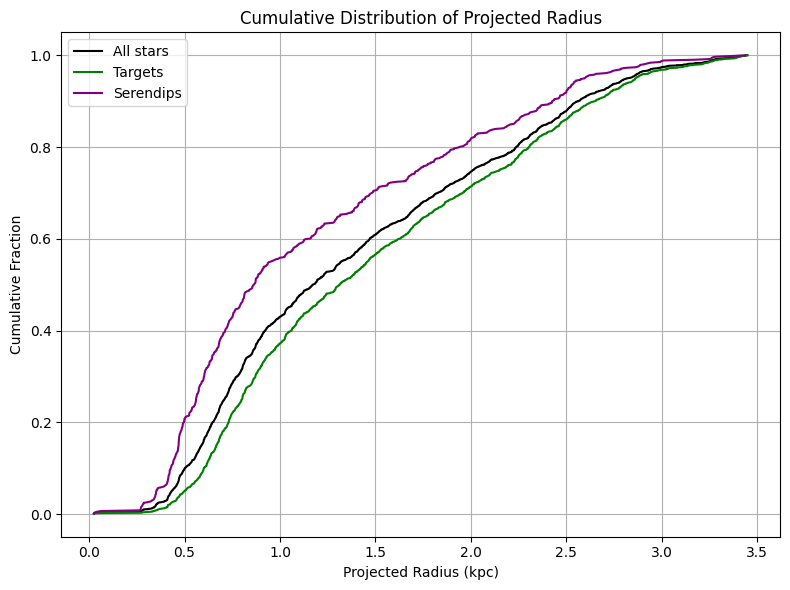

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pull projected radius values and remove NaNs
r_proj_all      = df['R_proj_kpc'].dropna()
r_proj_target   = df[df['TYPE'] == 'target']['R_proj_kpc'].dropna()
r_proj_serendip = df[df['TYPE'] == 'serendip']['R_proj_kpc'].dropna()

# Sort them for cumulative plotting
r_all_sorted      = np.sort(r_proj_all)
r_target_sorted   = np.sort(r_proj_target)
r_serendip_sorted = np.sort(r_proj_serendip)

# Generate normalized cumulative arrays
cdf_all      = np.arange(1, len(r_all_sorted) + 1) / len(r_all_sorted)
cdf_target   = np.arange(1, len(r_target_sorted) + 1) / len(r_target_sorted)
cdf_serendip = np.arange(1, len(r_serendip_sorted) + 1) / len(r_serendip_sorted)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(r_all_sorted, cdf_all, label='All stars', color='black')
plt.plot(r_target_sorted, cdf_target, label='Targets', color='green')
plt.plot(r_serendip_sorted, cdf_serendip, label='Serendips', color='purple')

plt.xlabel('Projected Radius (kpc)')
plt.ylabel('Cumulative Fraction')
plt.title('Cumulative Distribution of Projected Radius')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


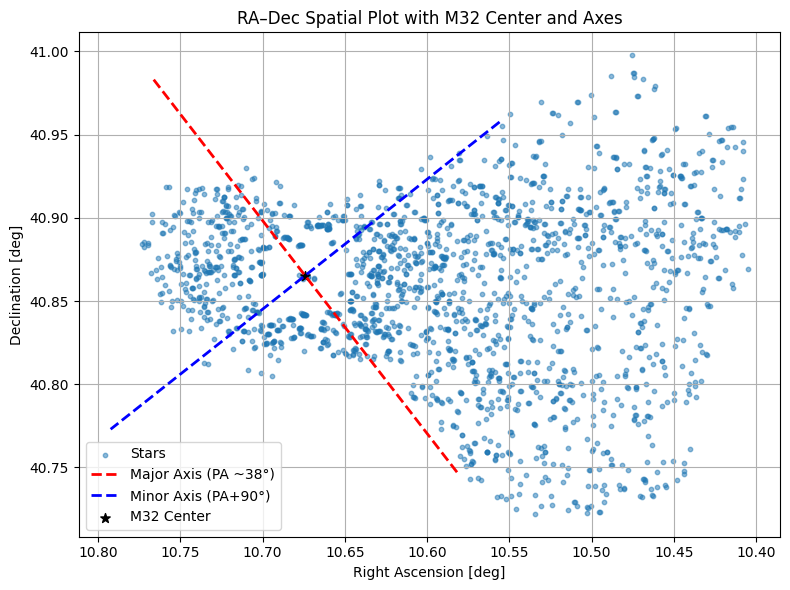

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("M32_Final.csv")

# M32 central position (in degrees)
ra_m32_deg = (0 + 42/60 + 41.8/3600) * 15      # ~10.67416667 deg
dec_m32_deg = 40 + 51/60 + 55/3600             # ~40.86527778 deg

# Length of axes (± around center, in degrees)
axis_length = 0.15

# Major axis PA (aligned roughly north-northwest/south-southeast in study)
PA_deg = 38.0
PA_rad = np.deg2rad(PA_deg)

# Major axis endpoints
delta_ra_major = axis_length * np.sin(PA_rad)
delta_dec_major = axis_length * np.cos(PA_rad)
ra_major = [ra_m32_deg - delta_ra_major, ra_m32_deg + delta_ra_major]
dec_major = [dec_m32_deg - delta_dec_major, dec_m32_deg + delta_dec_major]

# Minor axis is perpendicular: PA + 90 deg
PA_minor_rad = PA_rad + np.pi / 2
delta_ra_minor = axis_length * np.sin(PA_minor_rad)
delta_dec_minor = axis_length * np.cos(PA_minor_rad)
ra_minor = [ra_m32_deg - delta_ra_minor, ra_m32_deg + delta_ra_minor]
dec_minor = [dec_m32_deg - delta_dec_minor, dec_m32_deg + delta_dec_minor]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(df['RA'], df['DEC'], s=10, alpha=0.5, label='Stars')
plt.plot(ra_major, dec_major, 'r--', lw=2, label='Major Axis (PA ~38°)')
plt.plot(ra_minor, dec_minor, 'b--', lw=2, label='Minor Axis (PA+90°)')
plt.scatter(ra_m32_deg, dec_m32_deg, c='k', s=50, marker='*', label='M32 Center')
plt.xlabel("Right Ascension [deg]")
plt.ylabel("Declination [deg]")
plt.title("RA–Dec Spatial Plot with M32 Center and Axes")
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import seaborn as sns

df = pd.read_csv("M32_Final.csv")  # or use your iterated version

def plot_velocity_radius(df):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    # Projected Radius vs v_helio
    ax[0].scatter(df['R_disk_kpc_final'], df['v_helio'], c='gray', s=10, alpha=0.7)
    ax[0].set_title("v_helio vs Projected Radius")
    ax[0].set_xlabel("R_disk [kpc]")
    ax[0].set_ylabel("v_helio [km/s]")

    # Deprojected Radius vs v_offset
    ax[1].scatter(df['R_disk_kpc_final'], df['v_offset'], c='blue', s=10, alpha=0.7)
    ax[1].set_title("v_offset vs Deprojected Radius")
    ax[1].set_xlabel("R_disk [kpc]")
    ax[1].set_ylabel("v_offset [km/s]")

    plt.tight_layout()
    plt.show()

def plot_PA_vs_radius(df):
    plt.figure(figsize=(7,5))
    plt.plot(df['R_disk_kpc_final'], df['PA_deg'], '.', alpha=0.6)
    plt.xlabel("Radius [kpc]")
    plt.ylabel("PA [deg]")
    plt.title("Position Angle vs Radius")
    plt.grid(True)
    plt.show()

def plot_velocity_dispersion(df, bins=10):
    r = df['R_disk_kpc_final']
    v = df['v_helio']

    bin_means, bin_edges, _ = binned_statistic(r, v, statistic='std', bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    plt.figure(figsize=(7,5))
    plt.plot(bin_centers, bin_means, marker='o', color='darkred')
    plt.xlabel("R_disk [kpc]")
    plt.ylabel("σ(v_helio) [km/s]")
    plt.title("Velocity Dispersion Profile")
    plt.grid(True)
    plt.show()

def velocity_map(df, threshold=70):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    for ax, mask, title in zip(
        axs,
        [(df['v_offset'].abs() <= threshold), (df['v_offset'].abs() > threshold)],
        ["Inliers", "Outliers"]
    ):
        sc = ax.scatter(df.loc[mask, 'xi_kpc'], df.loc[mask, 'eta_kpc'],
                        c=df.loc[mask, 'v_offset'], cmap='coolwarm', s=30, edgecolor='k')
        ax.set_title(title)
        ax.set_xlabel(r"$\xi$ [kpc]")
        ax.set_ylabel(r"$\eta$ [kpc]")
        ax.grid(True)

    plt.colorbar(sc, ax=axs, label="v_offset [km/s]")
    plt.tight_layout()
    plt.show()

def plot_cmd_colored_by_tag(df, mag_col='F814W', color_col='F606W-F814W'):
    plt.figure(figsize=(7,6))
    tags = df['TAG'].unique()
    for tag in tags:
        sub = df[df['TAG'] == tag]
        plt.scatter(sub[color_col], sub[mag_col], s=15, alpha=0.6, label=tag)

    plt.gca().invert_yaxis()
    plt.xlabel("Color [F606W − F814W]")
    plt.ylabel("F814W Mag")
    plt.title("CMD by Population Tag")
    plt.legend()
    plt.grid(True)
    plt.show()


def population_bar_pie(df):
    tag_counts = df['TAG'].value_counts()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Bar Chart
    axs[0].bar(tag_counts.index, tag_counts.values, color='skyblue')
    axs[0].set_title("Component Membership Histogram")
    axs[0].set_ylabel("Number of Stars")

    # Pie Chart
    axs[1].pie(tag_counts.values, labels=tag_counts.index, autopct='%1.1f%%')
    axs[1].set_title("Component Fractions")

    plt.tight_layout()
    plt.show()


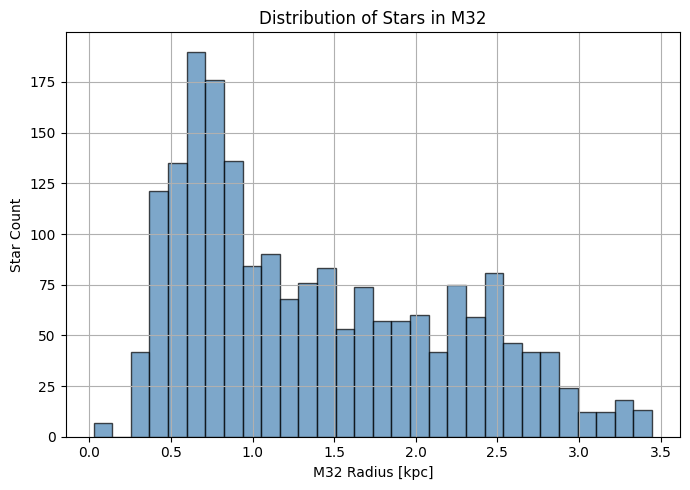

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(df['R_proj_M32_kpc'].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("M32 Radius [kpc]")
plt.ylabel("Star Count")
plt.title("Distribution of Stars in M32")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

df_raw=pd.read_csv("M32_Final.csv")

# ----------------------------
# Function: Choose subset
# ----------------------------
def sample_choose(df_raw, ser=False, clear=False, contam=False, target=False):
    """
    Returns a subset of stars from df_raw based on a single selection flag.

    Parameters
    ----------
    ser : bool
        Select serendipitous stars (TYPE == 'serendip')
    clear : bool
        Select stars with CONTAM < 0.2
    contam : bool
        Select stars with CONTAM >= 0.2
    target : bool
        Select stars with TYPE == 'target'

    Returns
    -------
    df : pd.DataFrame
        Filtered DataFrame
    """
    flags = [ser, clear, contam, target]
    if sum(flags) > 1:
        raise ValueError("Only one of 'ser', 'clear', 'contam', or 'target' should be True.")

    if ser:
        df = df_raw[df_raw['TYPE'] == 'serendip'].copy()
    elif clear:
        df = df_raw[df_raw['CONTAM'] < 0.2].copy()
    elif contam:
        df = df_raw[df_raw['CONTAM'] >= 0.2].copy()
    elif target:
        df = df_raw[df_raw['TYPE'] == 'target'].copy()
    else:
        df = df_raw.copy()

    return df

# ----------------------------
# Function: Assign f_rot
# ----------------------------
def assign_f_rot(row, f_target, f_serendip, f_light, f_contam, contam_thresh=0.2):
    """
    Assign f_rot per star based on TYPE and CONTAM.
    """
    if row['TYPE'] == 'target':
        return f_target
    elif row['TYPE'] == 'serendip':
        if row['CONTAM'] < contam_thresh:
            return f_light
        else:
            return f_contam
    else:
        return f_serendip  # fallback

# ----------------------------
# Function: Compute v_offset
# ----------------------------
def compute_v_offset_rowwise(row, v_sys=-300):
    """
    Compute v_model - v_helio using per-star f_rot and geometry.
    """
    v_model = v_sys + row['f_rot'] * row['v_rot_M31_model'] * np.cos(row['theta_j']) * np.sin(row['i_j_rad'])
    return v_model - row['v_helio']

# ----------------------------
# Example Usage
# ----------------------------

# Set flags (only one should be True)
ser = False
clear = True
contam = False
target = False

# Example f_rot values from model fits
f_target   = 1.02
f_serendip = 1.21
f_light    = 1.03
f_contam   = 1.2

# Apply the pipeline
df = sample_choose(df_raw, ser=ser, clear=clear, contam=contam, target=target)
df['f_rot'] = df.apply(assign_f_rot, axis=1, args=(f_target, f_serendip, f_light, f_contam))
df['v_offset'] = df.apply(compute_v_offset_rowwise, axis=1)


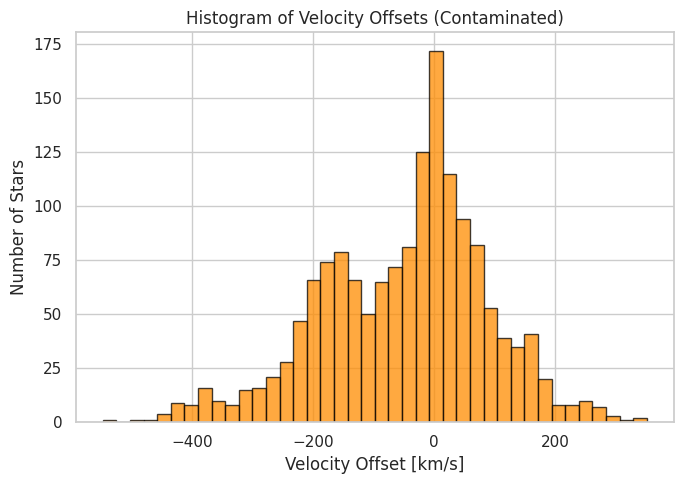

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(df['v_offset'].dropna(), bins=40, color='darkorange', edgecolor='black', alpha=0.75)
plt.xlabel("Velocity Offset [km/s]")
plt.ylabel("Number of Stars")
plt.title("Histogram of Velocity Offsets (Contaminated)")
plt.grid(True)
plt.tight_layout()
plt.show()


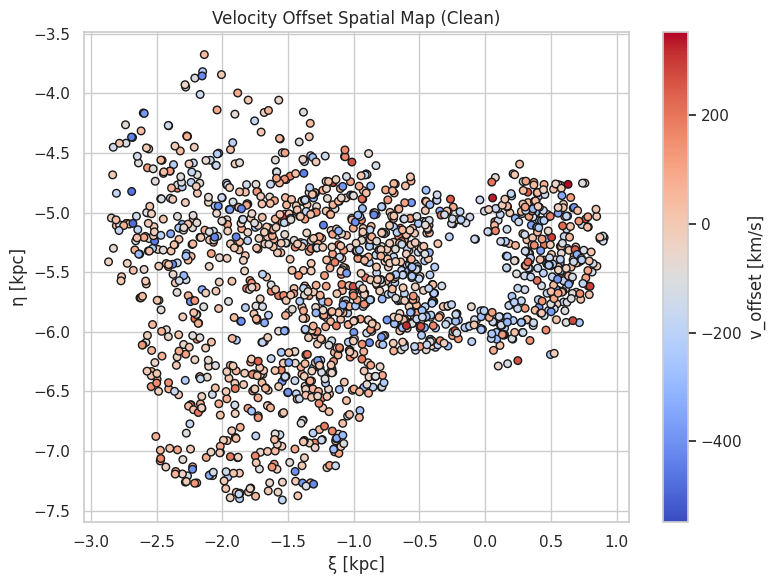

In [ ]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(df['xi_kpc'], df['eta_kpc'], c=df['v_offset'], cmap='coolwarm', s=30, edgecolor='k')
plt.xlabel("ξ [kpc]")
plt.ylabel("η [kpc]")
plt.title("Velocity Offset Spatial Map (Clean)")
plt.colorbar(sc, label="v_offset [km/s]")
plt.grid(True)
plt.tight_layout()
plt.show()


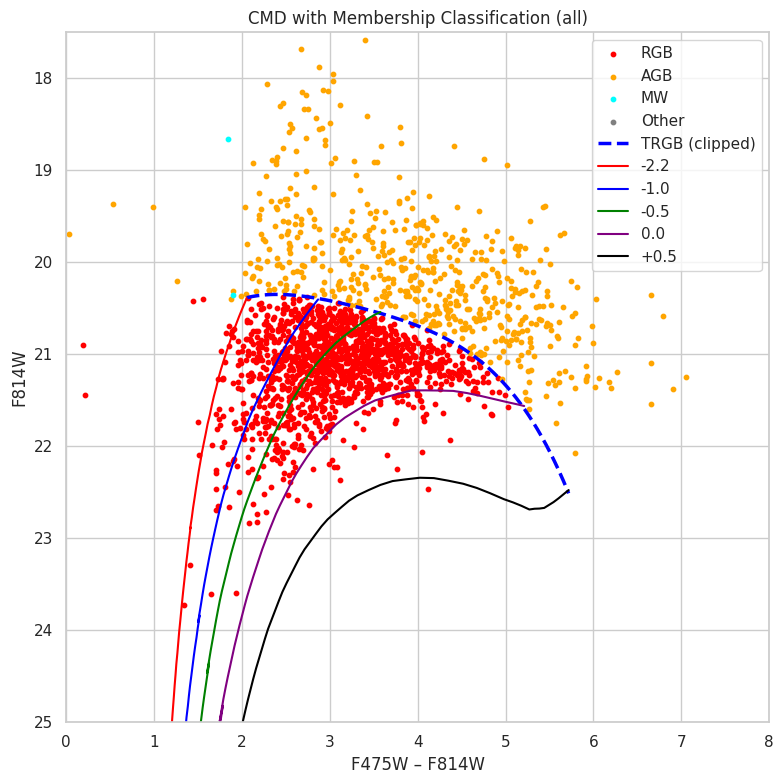

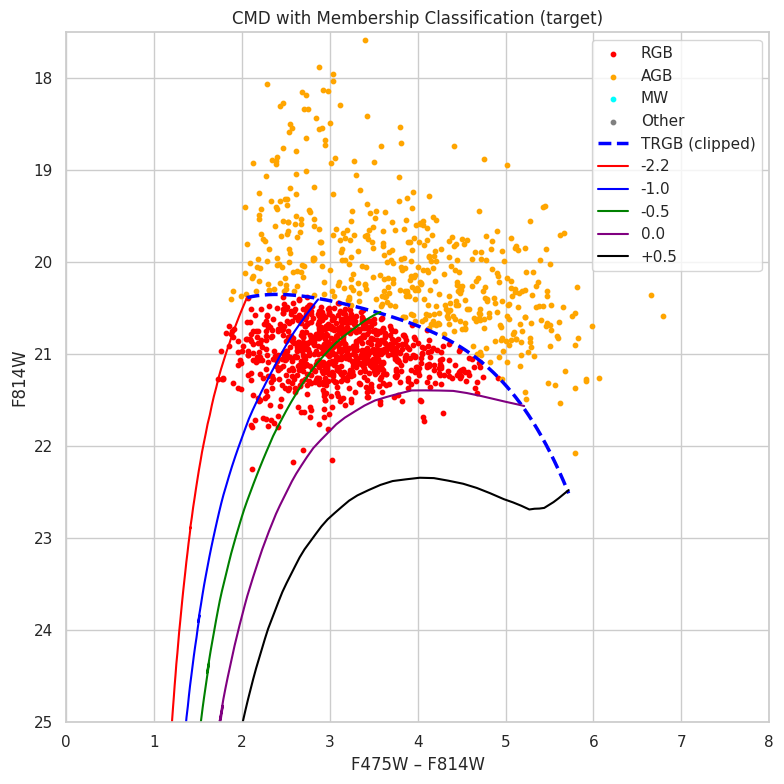

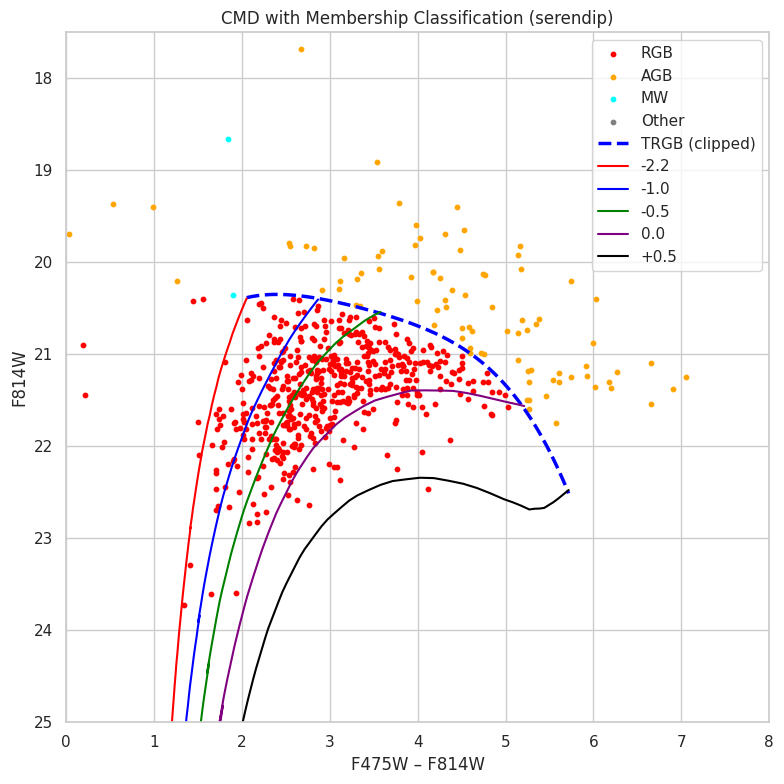

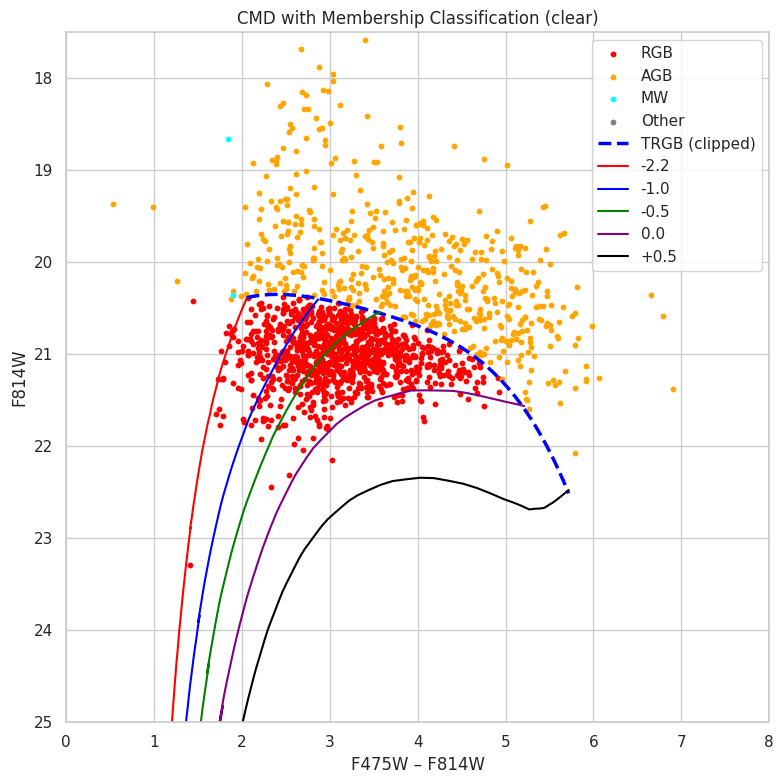

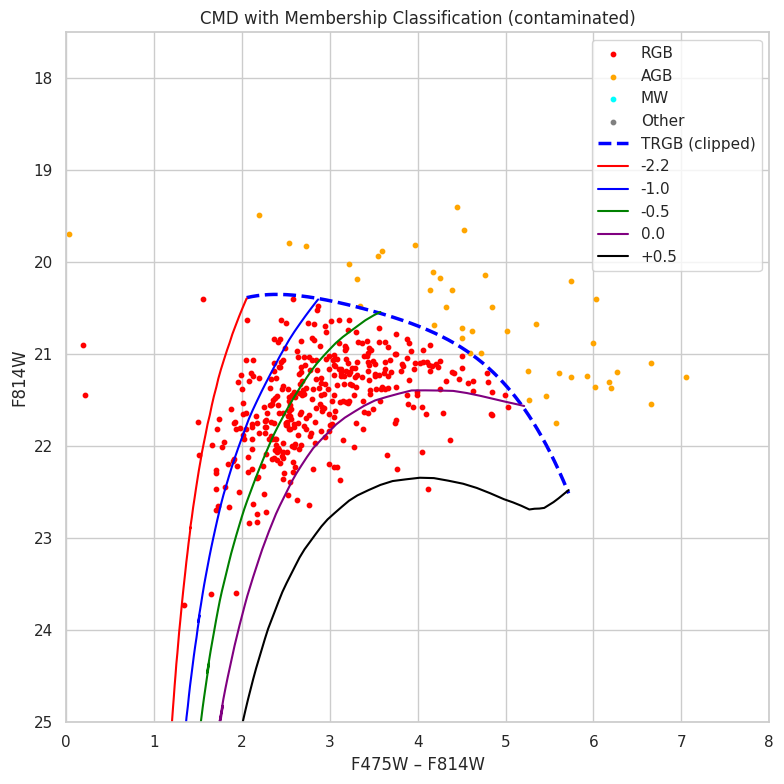

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- TRGB polynomial function ---
def trgb(x):
    return (
        0.0336792087211934*x**4 - 0.452060820118619*x**3 + 2.34319965297525*x**2 - 5.29639417200486*x + 24.6952483024551
    )

# --- Find intersection magnitude between TRGB and first curve ---
def find_intersection(trgb_func, curve):
    xs, ys = zip(*curve)
    xs = np.array(xs)
    ys = np.array(ys)
    trgb_ys = trgb_func(xs)
    diffs = np.abs(trgb_ys - ys)
    min_idx = np.argmin(diffs)
    intersection_y = ys[min_idx]
    return intersection_y

# --- Find intersection x-value for plotting restriction ---
def find_intersection_x(trgb_func, curve):
    xs, ys = zip(*curve)
    xs = np.array(xs)
    ys = np.array(ys)
    trgb_ys = trgb_func(xs)
    diffs = np.abs(trgb_ys - ys)
    min_idx = np.argmin(diffs)
    return xs[min_idx]

# --- Classification function with velocity check ---
def classify_member(row, trgb_func, first_curve, intersection_y, velocity_threshold=-150, mag_boundary=20.4):
    x, y = row['color'], row['mag']
    velocity = row.get('v_helio', None)

    def classify_cmd_pos(x_val, y_val):
        return 'RGB' if y_val > trgb_func(x_val) else 'AGB'

    if y < intersection_y:
        if x < 2:
            if velocity is None or velocity > velocity_threshold:
                return 'MW'
            return 'AGB' if y < mag_boundary else 'RGB'
    else:
        curve_xs, curve_ys = zip(*first_curve)
        sorted_indices = np.argsort(curve_ys)
        sorted_ys = np.array(curve_ys)[sorted_indices]
        sorted_xs = np.array(curve_xs)[sorted_indices]

        if y < sorted_ys.min() or y > sorted_ys.max():
            if velocity is None or velocity > velocity_threshold:
                return 'MW'
            return 'AGB' if y < mag_boundary else 'RGB'

        x_on_curve = np.interp(y, sorted_ys, sorted_xs)
        if x < x_on_curve:
            if velocity is None or velocity > velocity_threshold:
                return 'MW'
            return 'AGB' if y < mag_boundary else 'RGB'

    return classify_cmd_pos(x, y)

# --- Monte Carlo bivariate classifier for probabilistic class breakdown ---
def classify_bivariate_probabilities(row, trgb_func, first_curve, intersection_y, N_MC=1000,
                                     sigma_color=0.03, sigma_mag=0.006,
                                     velocity_threshold=-150, mag_boundary=20.3):
    c0, m0 = row['color'], row['mag']
    velocity = row.get('v_helio', None)
    c_samples = np.random.normal(c0, sigma_color, N_MC)
    m_samples = np.random.normal(m0, sigma_mag, N_MC)

    def classify_sample(x, y):
        sample_row = {'color': x, 'mag': y, 'v_helio': velocity}
        return classify_member(sample_row, trgb_func, first_curve, intersection_y,
                               velocity_threshold=velocity_threshold, mag_boundary=mag_boundary)

    results = [classify_sample(c, m) for c, m in zip(c_samples, m_samples)]
    return pd.Series({
        'p_AGB': np.mean([r == 'AGB' for r in results]),
        'p_RGB': np.mean([r == 'RGB' for r in results]),
        'p_MW':  np.mean([r == 'MW'  for r in results])
    })

# --- CMD plot function ---
def CMD_plot(star_type='all', failreason=True, fitting_function=trgb, isochrones=None):
    df = pd.read_csv('M32_Final.csv')

    # Extinction correction
    A_475, A_814 = 0.38, 0.12
    df['F475W_1_corr'] = df['F475W'] - A_475
    df['F814W_1_corr'] = df['F814W'] - A_814
    df['color'] = df['F475W_1_corr'] - df['F814W_1_corr']
    df['mag'] = df['F814W']

    # --- Sample filters ---
    if star_type == 'target':
        df = df[df['TYPE'].str.lower() == 'target']
    elif star_type == 'serendip':
        df = df[df['TYPE'].str.lower().str.contains('serendip')]
    elif star_type == 'clear':
        df = df[df['CONTAM'] < 0.2]
    elif star_type == 'contaminated':
        df = df[df['CONTAM'] >= 0.2]

    df = df.copy()

    if not isochrones:
        print("Warning: No isochrones provided!")
        df['class'] = 'Other'
    else:
        first_curve = isochrones[0]
        intersection_y = find_intersection(fitting_function, first_curve)

        df['class'] = df.apply(
            lambda row: classify_member(row, fitting_function, first_curve, intersection_y),
            axis=1
        )

        df[['p_AGB', 'p_RGB', 'p_MW']] = df.apply(
            lambda row: classify_bivariate_probabilities(row, fitting_function, first_curve, intersection_y),
            axis=1
        )

    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'RGB': 'red', 'AGB': 'orange', 'MW': 'cyan', 'Other': 'gray'}
    for cls in ['RGB', 'AGB', 'MW', 'Other']:
        subset = df[df['class'] == cls]
        ax.scatter(subset['color'], subset['mag'], s=10, c=colors.get(cls, 'gray'), label=cls)

    if failreason and 'failure_reason' in df.columns:
        fail_df = df[df['failure_reason'] == 'v_measurement_fail']
        ax.scatter(fail_df['color'], fail_df['F814W_1_corr'], s=20, c='blue', label='v_measurement_fail')

    # Restrict TRGB curve to intersection boundaries
    start_x = find_intersection_x(fitting_function, isochrones[0])
    end_x = find_intersection_x(fitting_function, isochrones[4])
    trgb_x = np.linspace(start_x, end_x, 300)
    trgb_y = fitting_function(trgb_x)
    ax.plot(trgb_x, trgb_y, linestyle='--', color='blue', linewidth=2.5, label='TRGB (clipped)')

    # Isochrone labels
    if isochrones:
        curve_labels = ['-2.2', '-1.0', '-0.5', '0.0', '+0.5']
        curve_colors = ['red', 'blue', 'green', 'purple', 'black']
        for i, curve in enumerate(isochrones):
            xs, ys = zip(*curve)
            ax.plot(xs, ys, color=curve_colors[i % len(curve_colors)], label=f'{curve_labels[i]}')

    ax.set_ylim(17.5, 25)
    ax.set_xlim(0, 8)
    ax.invert_yaxis()
    ax.set_xlabel('F475W – F814W')
    ax.set_ylabel('F814W')
    ax.set_title(f'CMD with Membership Classification ({star_type})')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# --- Load isochrones ---
def load_isochrone(filepath):
    with open(filepath) as f:
        raw = eval(f.read())
        return [(float(x), float(y)) for x, y in raw]

# Load 5 curves corresponding to ['-1.0', '-0.5', '0.0', '-2.2', '+0.5']
isochrones = [load_isochrone(f'{fname}') for fname in ['hi1.txt', 'hi2.txt', 'hi3.txt', 'hi4.txt', 'hi5.txt']]

# Run the plots
CMD_plot(star_type='all', isochrones=isochrones)
CMD_plot(star_type='target', isochrones=isochrones)
CMD_plot(star_type='serendip', isochrones=isochrones)
CMD_plot(star_type='clear', isochrones=isochrones)
CMD_plot(star_type='contaminated', isochrones=isochrones)

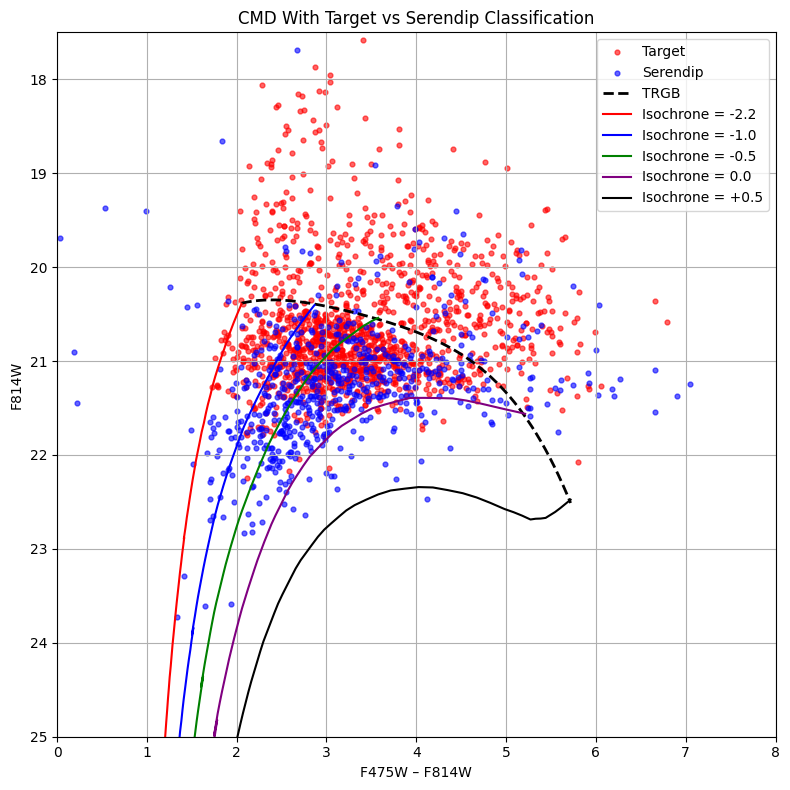

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde

# --- TRGB polynomial function ---
def trgb(x):
    return (0.0336792087211934*x**4 - 0.452060820118619*x**3 +
            2.34319965297525*x**2 - 5.29639417200486*x + 24.6952483024551)

# --- Isochrone loader ---
def load_isochrone(filepath):
    with open(filepath) as f:
        raw = eval(f.read())
        return [(float(x), float(y)) for x, y in raw]

# --- Find clipped TRGB range ---
def find_intersection_x(func, curve):
    xs = np.array([pt[0] for pt in curve])
    ys = np.array([pt[1] for pt in curve])
    return xs[np.argmin(np.abs(func(xs) - ys))]

# --- Compute KDE peak location ---
def kde_peak(x, y):
    data = np.vstack([x, y])
    kde = gaussian_kde(data)
    xi, yi = np.mgrid[x.min():x.max():300j, y.min():y.max():300j]
    grid_coords = np.vstack([xi.ravel(), yi.ravel()])
    z = kde(grid_coords)
    max_idx = np.argmax(z)
    return grid_coords[:, max_idx]

# --- Load isochrones ---
isochrones = [load_isochrone(fname) for fname in ['hi1.txt', 'hi2.txt', 'hi3.txt', 'hi4.txt', 'hi5.txt']]

# --- Load and prep data ---
df = pd.read_csv("M32_Final.csv")
A_475, A_814 = 0.38, 0.12
df['F475W_corr'] = df['F475W'] - A_475
df['F814W_corr'] = df['F814W'] - A_814
df['color'] = df['F475W_corr'] - df['F814W_corr']
df['mag']   = df['F814W']

# --- Subsets ---
df_target   = df[df['TYPE'].str.lower() == 'target']
df_serendip = df[df['TYPE'].str.lower().str.contains('serendip')]

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 8))

# Plot serendip and target points
ax.scatter(df_target['color'], df_target['mag'],   s=12, c='red',   alpha=0.6, label='Target')
ax.scatter(df_serendip['color'], df_serendip['mag'], s=12, c='blue',  alpha=0.6, label='Serendip')

# TRGB curve clipped to isochrone domain
x_start = find_intersection_x(trgb, isochrones[0])
x_end   = find_intersection_x(trgb, isochrones[-1])
trgb_x  = np.linspace(x_start, x_end, 300)
trgb_y  = trgb(trgb_x)
ax.plot(trgb_x, trgb_y, linestyle='--', color='black', linewidth=2, label='TRGB')

# Isochrones
curve_colors = ['red', 'blue', 'green', 'purple', 'black']
labels       = ['-2.2', '-1.0', '-0.5', '0.0', '+0.5']
for i, curve in enumerate(isochrones):
    xs, ys = zip(*curve)
    ax.plot(xs, ys, color=curve_colors[i], label=f"Isochrone = {labels[i]}")


# Final labels
ax.set_xlabel("F475W – F814W")
ax.set_ylabel("F814W")
ax.set_title("CMD With Target vs Serendip Classification")
ax.invert_yaxis()
ax.set_xlim(0, 8)
ax.set_ylim(25, 17.5)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

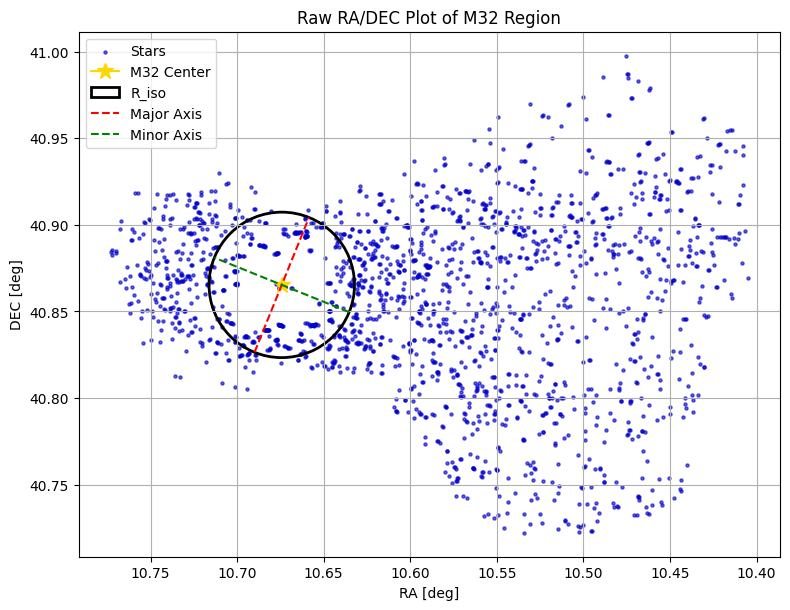

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load data ---
df = pd.read_csv("M32_Final.csv")

# --- Extract coordinates ---
ra = df['RA'].astype(float).values
dec = df['DEC'].astype(float).values

# --- M32 center coordinates ---
ra_center = 10.6742    # RA in degrees (00:42:41.8)
dec_center = 40.8653   # DEC in degrees (+40:51:55)

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, s=5, c='mediumblue', alpha=0.6, label='Stars')
ax.plot(ra_center, dec_center, marker='*', markersize=12, color='gold', label='M32 Center')

# --- Isophotal radius circle (approximate R_iso = 150 arcsec = 0.042 deg) ---
circle = plt.Circle((ra_center, dec_center), 0.042, color='k', fill=False, lw=2, label='R_iso')
ax.add_patch(circle)

# --- Major and Minor Axes ---
pa_deg = -22  # major axis position angle, degrees E of N
r_iso = 0.042

# Convert P.A. to radians
pa_rad = np.deg2rad(pa_deg)

# Vector endpoints
dx_major = r_iso * np.sin(pa_rad)
dy_major = r_iso * np.cos(pa_rad)
dx_minor = r_iso * np.sin(pa_rad + np.pi/2)
dy_minor = r_iso * np.cos(pa_rad + np.pi/2)

# Plot axes
ax.plot([ra_center - dx_major, ra_center + dx_major],
        [dec_center - dy_major, dec_center + dy_major],
        'r--', lw=1.5, label='Major Axis')
ax.plot([ra_center - dx_minor, ra_center + dx_minor],
        [dec_center - dy_minor, dec_center + dy_minor],
        'g--', lw=1.5, label='Minor Axis')

# --- Final touches ---
ax.set_xlabel('RA [deg]')
ax.set_ylabel('DEC [deg]')
ax.set_title('Raw RA/DEC Plot of M32 Region')
ax.invert_xaxis()
ax.set_aspect('equal')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


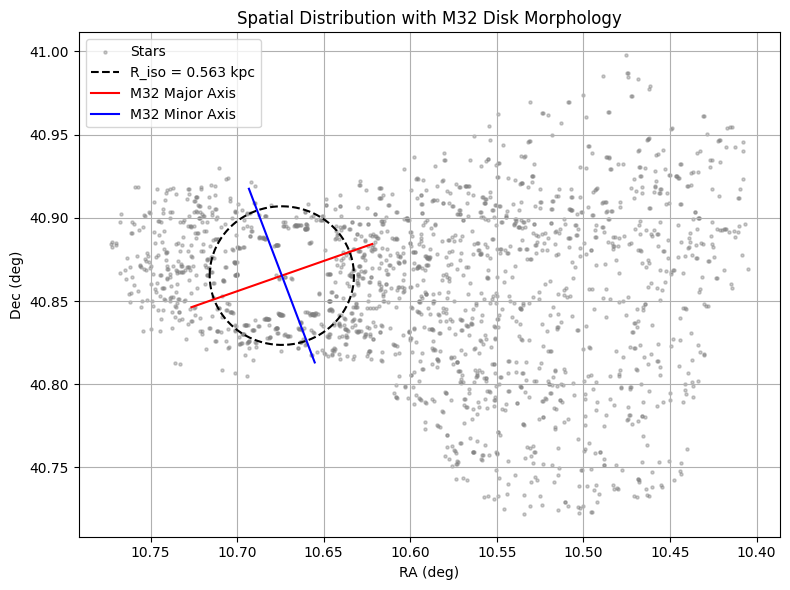

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u

# Use clear sample
df = pd.read_csv("M32_Final.csv")

# Define M32 center (RA, Dec in degrees)
RA_M32 = (0 + 42/60 + 41.8/3600) * 15      # = 10.711 deg
DEC_M32 = 40 + 51/60 + 55/3600             # = 40.865 deg
center = SkyCoord(ra=RA_M32 * u.deg, dec=DEC_M32 * u.deg)

# Transform star positions into offset frame centered on M32
coords = SkyCoord(ra=df['RA'].values * u.deg, dec=df['DEC'].values * u.deg)
offset_frame = SkyOffsetFrame(origin=center)
offset_coords = coords.transform_to(offset_frame)
xi = offset_coords.lon.arcsec
eta = offset_coords.lat.arcsec

# Escala projection: orientation of M31 disk
PA_disk = 38.0       # degrees
i_disk = 77.0        # degrees
DM31_kpc = 776.0     # kpc
PA_rad = np.deg2rad(PA_disk)
alpha = eta * np.cos(PA_rad) + xi * np.sin(PA_rad)
beta  = xi * np.cos(PA_rad) - eta * np.sin(PA_rad)
i_rad = np.deg2rad(i_disk)
theta_j = np.arctan2(beta, alpha * np.cos(i_rad))
R_proj_kpc = DM31_kpc * np.sqrt(alpha**2 + (beta / np.cos(theta_j))**2) / 206265.0
df['R_proj'] = R_proj_kpc

# Define inner/outer regions by disk-projected radius
df['Region'] = np.where(df['R_proj'] <= 0.563, 'inner', 'outer')

# ----- M32 Disk Morphology Projection -----
PA_M32 = 160.0  # position angle (degrees), update if needed
i_M32 = 60.0    # inclination angle (degrees), update if needed
PA_rad_M32 = np.deg2rad(PA_M32)
i_rad_M32 = np.deg2rad(i_M32)

# Rotate coordinate system to M32 disk frame
alpha_M32 = eta * np.cos(PA_rad_M32) + xi * np.sin(PA_rad_M32)
beta_M32  = xi * np.cos(PA_rad_M32) - eta * np.sin(PA_rad_M32)

X_proj = alpha_M32
Y_proj = beta_M32 / np.cos(i_rad_M32)

# Plot spatial distribution
plt.figure(figsize=(8, 6))
plt.scatter(df['RA'], df['DEC'], s=5, alpha=0.4, color='gray', label='Stars')

# Boundary circle (R_proj = 0.563 kpc = 150 arcsec)
theta = np.linspace(0, 2*np.pi, 200)
radius_deg = 150.0 / 3600.0
circle_ra = RA_M32 + radius_deg * np.cos(theta)
circle_dec = DEC_M32 + radius_deg * np.sin(theta)
plt.plot(circle_ra, circle_dec, 'k--', label='R_iso = 0.563 kpc')

# Major and minor axes overlays (±200 arcsec)
major_x = np.array([-200, 200])
major_y = np.array([0, 0])
minor_x = np.array([0, 0])
minor_y = np.array([-200, 200])

# Rotate major/minor axis into sky coords
major_ra = RA_M32 + (major_x * np.cos(PA_rad_M32) - major_y * np.sin(PA_rad_M32)) / 3600.0
major_dec = DEC_M32 + (major_x * np.sin(PA_rad_M32) + major_y * np.cos(PA_rad_M32)) / 3600.0

minor_ra = RA_M32 + (minor_x * np.cos(PA_rad_M32) - minor_y * np.sin(PA_rad_M32)) / 3600.0
minor_dec = DEC_M32 + (minor_x * np.sin(PA_rad_M32) + minor_y * np.cos(PA_rad_M32)) / 3600.0

# Add to plot
plt.plot(major_ra, major_dec, 'r-', label='M32 Major Axis')
plt.plot(minor_ra, minor_dec, 'b-', label='M32 Minor Axis')

# Plot settings
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Spatial Distribution with M32 Disk Morphology")
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

# --- Load data ---
df = pd.read_csv("M32_Final.csv")

# --- Clean RA/DEC ---
df = df.dropna(subset=['RA', 'DEC'])
df['RA'] = pd.to_numeric(df['RA'], errors='coerce')
df['DEC'] = pd.to_numeric(df['DEC'], errors='coerce')
df = df.dropna(subset=['RA', 'DEC'])

# --- M32 center coordinates (RA = 00:42:41.8, DEC = +40:51:55) ---
ra_m32 = (0 + 42/60 + 41.8/3600) * 15      # Convert to degrees
dec_m32 = 40 + 51/60 + 55/3600             # Degrees

# --- Create SkyCoord objects ---
coords = SkyCoord(ra=df['RA'].values * u.deg, dec=df['DEC'].values * u.deg)
center = SkyCoord(ra=ra_m32 * u.deg, dec=dec_m32 * u.deg)

# --- Angular separation in arcseconds ---
angular_sep_arcsec = center.separation(coords).arcsecond

# --- Convert to projected radius in kpc ---
# 1 radian = 206265 arcsec; assume distance to M32 = 785 kpc
distance_kpc = 785
df['Projected_Radius_kpc'] = (angular_sep_arcsec / 206265) * distance_kpc

# --- Save or preview ---
df.to_csv("M32_Final_with_kpc.csv", index=False)
print(df[['RA', 'DEC', 'Projected_Radius_kpc']].head())


          RA        DEC  Projected_Radius_kpc
0  10.693943  40.825365              0.583982
1  10.694495  40.824924              0.591662
2  10.693516  40.825516              0.580508
3  10.693251  40.825695              0.577257
4  10.692965  40.825964              0.572782


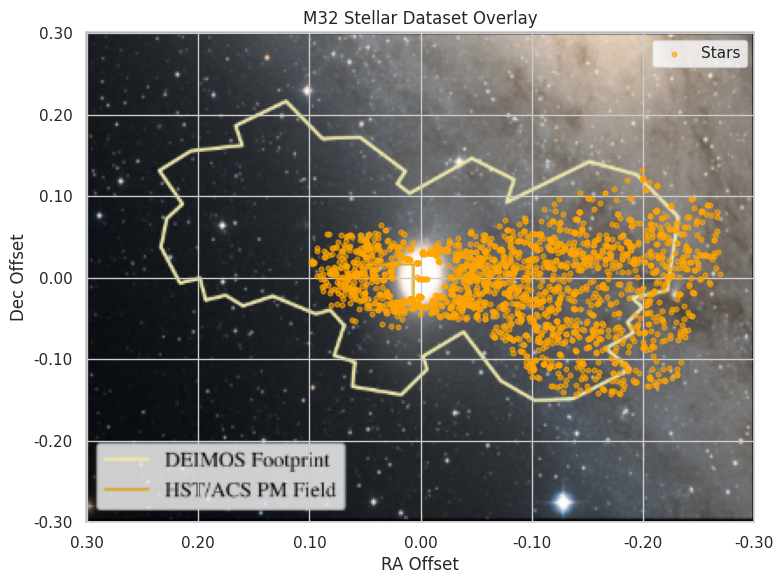

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# === Step 1: Load the image ===
image_path = "pic.png"
img = mpimg.imread(image_path)

img_height, img_width = img.shape[0], img.shape[1]

# === Step 2: Load the dataset ===
data_path = "M32_Final.csv"
df = pd.read_csv(data_path)

# === Step 3: Convert absolute RA/Dec to relative offsets ===
ra_m32_deg = (0 + 42/60 + 41.8/3600) * 15     # M32 center RA in degrees
dec_m32_deg = 40 + 51/60 + 55/3600            # M32 center Dec in degrees

RA_offset = df['RA'].values - ra_m32_deg
Dec_offset = df['DEC'].values - dec_m32_deg

# === Step 4: Convert offsets to pixel positions ===
RA_min, RA_max = -0.3, 0.3
Dec_min, Dec_max = -0.3, 0.3

def offset_to_pixel(ra_offset, dec_offset):
    x = img_width * (RA_max - ra_offset) / (RA_max - RA_min)  # keep RA inversion
    y = img_height * (Dec_max - dec_offset) / (Dec_max - Dec_min)  # flip Dec direction
    return x, y


x_pix, y_pix = offset_to_pixel(RA_offset, Dec_offset)

# === Step 5: Plot the overlay ===
plt.figure(figsize=(8, 8))
plt.imshow(img)

# Overlay stellar positions
plt.scatter(x_pix, y_pix, s=12, c='orange', alpha=0.6, label='Stars')

# Define correct tick labels
ra_ticks = np.linspace(RA_min, RA_max, 7)
dec_ticks = np.linspace(Dec_min, Dec_max, 7)

# Map to pixel positions
ra_tick_pix = img_width * (ra_ticks - RA_min) / (RA_max - RA_min)
dec_tick_pix = img_height * (dec_ticks - Dec_min) / (Dec_max - Dec_min)

# Apply ticks and labels
# Apply ticks and labels with reversed RA tick labels
plt.xticks(ra_tick_pix, [f"{val:.2f}" for val in ra_ticks[::-1]])
# Apply y-ticks with inverted label order
plt.yticks(dec_tick_pix, [f"{val:.2f}" for val in dec_ticks[::-1]])


plt.xlabel("RA Offset")
plt.ylabel("Dec Offset")
plt.title("M32 Stellar Dataset Overlay")

plt.legend()
plt.tight_layout()
plt.show()


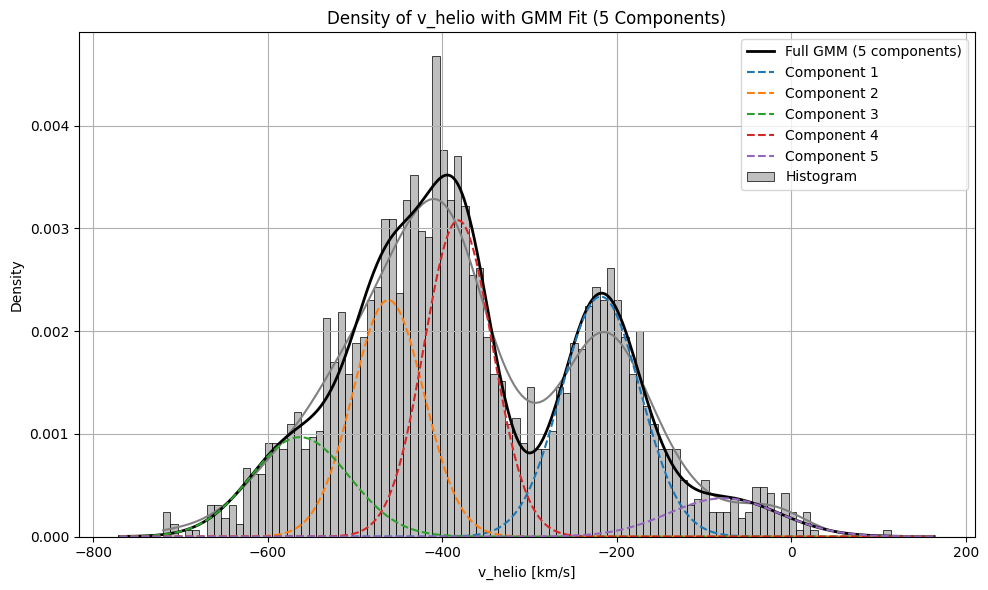

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# --- Load data ---
df = pd.read_csv("M32_Final.csv")

# --- Extract v_helio column and drop NaNs ---
v_helio = df["v_helio"].dropna().values.reshape(-1, 1)

# --- Plot density ---
plt.figure(figsize=(10, 6))
sns.histplot(v_helio.flatten(), bins=100, stat='density', kde=True, color='gray', alpha=0.5, label='Histogram')

# --- Fit full GMM (5 components) ---
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(v_helio)

# --- Evaluate the GMM on a fine velocity grid ---
x = np.linspace(v_helio.min() - 50, v_helio.max() + 50, 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, label='Full GMM (5 components)', color='black', linewidth=2)

# --- Plot individual components ---
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(np.array([np.diag(cov) for cov in gmm.covariances_])).flatten()

for i in range(5):
    component_pdf = weights[i] * (
        1 / (stds[i] * np.sqrt(2 * np.pi))
    ) * np.exp(-0.5 * ((x.flatten() - means[i]) / stds[i]) ** 2)
    plt.plot(x, component_pdf, linestyle='--', label=f'Component {i+1}')

# --- Final plot formatting ---
plt.xlabel("v_helio [km/s]")
plt.ylabel("Density")
plt.title("Density of v_helio with GMM Fit (5 Components)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[tar] M32 ⟨v⟩ = -203.5 km/s, σ = 29.7 km/s


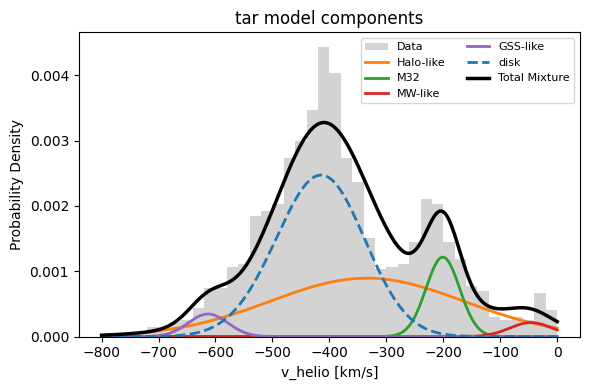

[ser] M32 ⟨v⟩ = -198.7 km/s, σ = 33.4 km/s


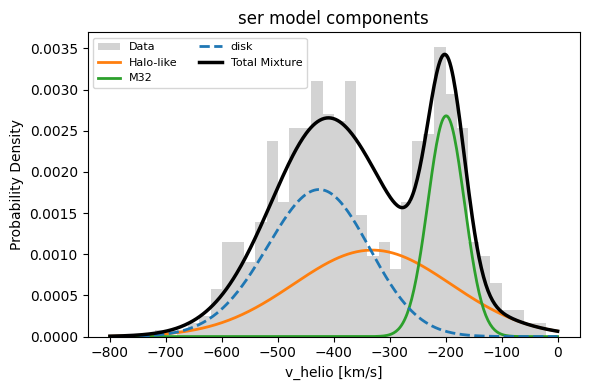

[clear] M32 ⟨v⟩ = -203.1 km/s, σ = 30.9 km/s


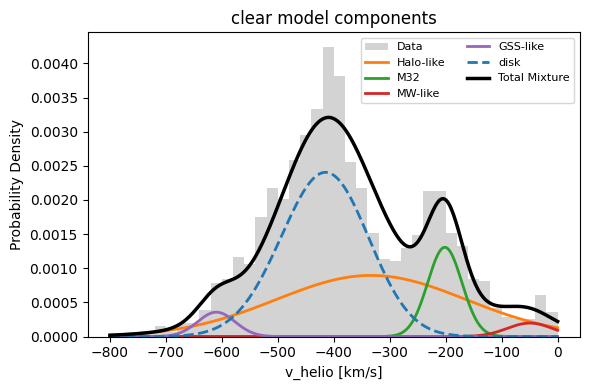

[contam] M32 ⟨v⟩ = -199.5 km/s, σ = 30.5 km/s


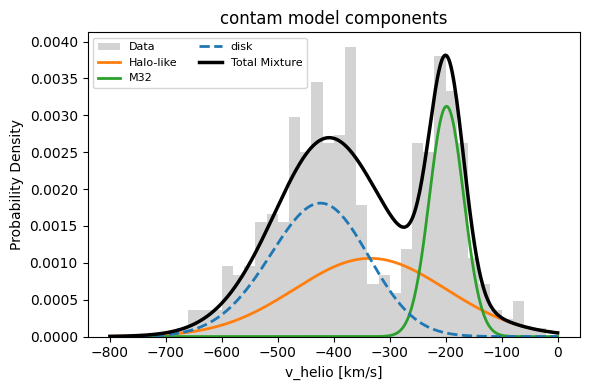

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# --- Constants ---
Vsys_M31 = -300.0  # systemic velocity of M31 [km/s]

# --- Load & split catalog ---
df_raw    = pd.read_csv("M32_Final.csv")
df_ser    = df_raw[df_raw['TYPE']   == 'serendip'].copy()
df_clear  = df_raw[df_raw['CONTAM'] <  0.2      ].copy()
df_contam = df_raw[df_raw['CONTAM'] >= 0.2      ].copy()
df_tar    = df_raw[df_raw['TYPE']   == 'target' ].copy()

# --- Model definitions ---
#   f_rot here scales the rotation speed, not the mixture weight
models = {
    "tar": {
        "params": {
            "Halo-like": {"f": 0.38, "mu": -333.96, "sigma": 169.58},
            "M32":       {"f": 0.09, "mu": -200.86, "sigma":  29.51},
            "MW-like":   {"f": 0.02, "mu":  -46.04, "sigma":  37.33},
            "GSS-like":  {"f": 0.03, "mu": -613.08, "sigma":  34.62},
        },
        "sigma_disk": 68.18,
        "f_rot":      1.02,
        "df":         df_tar,
    },
    "ser": {
        "params": {
            "Halo-like": {"f": 0.37, "mu": -331.32, "sigma": 140.54},
            "M32":       {"f": 0.22, "mu": -199.18, "sigma":  32.73},
        },
        "sigma_disk": 82.59,
        "f_rot":      1.21,
        "df":         df_ser,
    },
    "clear": {
        "params": {
            "Halo-like": {"f": 0.38, "mu": -333.27, "sigma": 169.24},
            "M32":       {"f": 0.10, "mu": -201.52, "sigma":  30.52},
            "MW-like":   {"f": 0.02, "mu":  -49.76, "sigma":  40.32},
            "GSS-like":  {"f": 0.03, "mu": -609.83, "sigma":  33.45},
        },
        "sigma_disk": 68.89,
        "f_rot":      1.03,
        "df":         df_clear,
    },
    "contam": {
        "params": {
            "Halo-like": {"f": 0.36, "mu": -334.79, "sigma": 135.35},
            "M32":       {"f": 0.24, "mu": -198.42, "sigma":  30.66},
        },
        "sigma_disk": 78.44,
        "f_rot":      1.20,
        "df":         df_contam,
    },
}

# --- Projected LOS disk velocity (both angles already in radians) ---
def compute_vdisk(df, f_rot):
    theta = df['theta_j'].values      # already in radians
    inc   = df['i_j_rad'].values      # already in radians
    vrot  = df['v_rot_M31_model'].values
    return Vsys_M31 + f_rot * vrot * np.cos(theta) * np.sin(inc)

# --- Build mixture PDFs + membership probabilities ---
def compute_mixture_with_disk_model(df, sigma_disk, comp_params, f_rot):
    v_helio = df['v_helio'].values
    v_disk  = compute_vdisk(df, f_rot)
    v_offset = v_helio - v_disk

    # static Gaussians
    pdfs = {}
    for name, p in comp_params.items():
        pdfs[name] = p['f'] * st.norm.pdf(
            v_helio, loc=p['mu'], scale=p['sigma']
        )

    # disk mixture fraction
    f_disk = 1.0 - sum(p['f'] for p in comp_params.values())

    # disk PDF: average of star‐by‐star kernels
    kernels = st.norm.pdf(
        v_helio[:, None],        # shape (Nstars, 1)
        loc=v_disk[None, :],      # shape (1, Nstars)
        scale=sigma_disk
    )
    pdfs['disk'] = f_disk * kernels.mean(axis=1)

    # total mixture PDF
    total_pdf = sum(pdfs.values())

    # store in DataFrame
    df['mixture_pdf'] = total_pdf
    df['v_offset']    = v_offset
    for name, arr in pdfs.items():
        df[f'pdf_{name}'] = arr
        df[f'P_{name}']   = arr / total_pdf

    return df, v_disk

# --- Plot styles ---
comp_styles = {
    'disk':     ('--', 'tab:blue'),
    'Halo-like':('-',  'tab:orange'),
    'M32':      ('-',  'tab:green'),
    'MW-like':  ('-',  'tab:red'),
    'GSS-like': ('-',  'tab:purple'),
}

# --- Run each model, compute stats, and plot ---
for key, m in models.items():
    df = m['df'].copy()
    df, v_disk = compute_mixture_with_disk_model(
        df,
        sigma_disk=m['sigma_disk'],
        comp_params=m['params'],
        f_rot=m['f_rot']
    )
    models[key]['df'] = df

    # M32 weighted mean & sigma
    weights = df['P_M32'].values
    vmean = np.average(df['v_helio'], weights=weights)
    vsig  = np.sqrt(np.average((df['v_helio'] - vmean)**2, weights=weights))
    print(f"[{key}] M32 ⟨v⟩ = {vmean:.1f} km/s, σ = {vsig:.1f} km/s")

    # build velocity grid for plotting
    vgrid = np.linspace(-800, 0, 400)
    comps = {}

    # static components on grid
    for name, p in m['params'].items():
        comps[name] = p['f'] * st.norm.pdf(
            vgrid, loc=p['mu'], scale=p['sigma']
        )

    # disk on grid
    f_disk = 1.0 - sum(p['f'] for p in m['params'].values())
    kernels = st.norm.pdf(
        vgrid[:, None],
        loc=v_disk[None, :],
        scale=m['sigma_disk']
    )
    comps['disk'] = f_disk * kernels.mean(axis=1)

    # total mixture
    pdf_total = sum(comps.values())

    # plot histogram + components
    plt.figure(figsize=(6, 4))
    plt.hist(
        df['v_helio'],
        bins=40, range=(-800, 0),
        density=True, color='lightgray', label='Data'
    )
    for name, pdf in comps.items():
        ls, color = comp_styles.get(name, ('-', 'k'))
        plt.plot(vgrid, pdf, linestyle=ls, color=color,
                 lw=2, label=name)

    plt.plot(vgrid, pdf_total,
             color='k', lw=2.5, label='Total Mixture')
    plt.title(f"{key} model components")
    plt.xlabel("v_helio [km/s]")
    plt.ylabel("Probability Density")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

✅ S/N table contains 7204 rows
✅ After color ≤ 20: 1946 rows remain


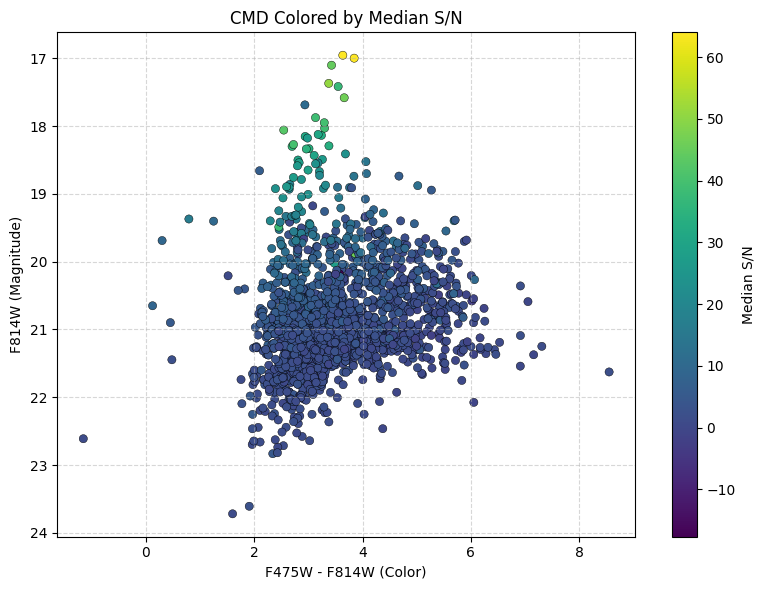

In [ ]:
import os
import tarfile
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

# --- SETTINGS ---
spec_root      = "/content"                # where your .s1d.tar.gz archives live
photometry_csv = "/content/M32_Final.csv"  # your photometry catalog
color_cut      = 20                      # drop any star with (F475W - F814W) > 0.2

# --- 1. Extract all .s1d.tar.gz files ---
def extract_all_archives(root):
    archives = [f for f in os.listdir(root) if f.endswith(".s1d.tar.gz")]
    for arc in archives:
        arc_path = os.path.join(root, arc)
        out_dir  = arc_path.replace(".s1d.tar.gz", "")
        if not os.path.exists(out_dir):
            print(f"Extracting {arc}…")
            with tarfile.open(arc_path, "r:gz") as tar:
                tar.extractall(path=out_dir)

# --- 2. Compute median S/N per star (no cuts) ---
def compute_snr_table(root):
    recs = []
    for subdir, _, files in os.walk(root):
        for fname in files:
            if not (fname.startswith("spec1d.") and fname.endswith(".fits.gz")):
                continue

            mask, slit_s, star_names = (
                fname.replace("spec1d.","")
                     .replace(".fits.gz","")
                     .split(".")
            )
            try:
                slit = int(slit_s)
            except ValueError:
                continue

            with fits.open(os.path.join(subdir, fname)) as hdul:
                data = hdul[1].data
                flux = np.atleast_2d(data["SPEC"])
                ivar = np.atleast_2d(data["IVAR"])

                for i, star in enumerate(star_names.split("+")):
                    if i >= flux.shape[0]:
                        continue
                    fvec, ivec = flux[i], ivar[i]
                    good = ivec > 0
                    snr_pix = fvec[good] * np.sqrt(ivec[good])
                    recs.append({
                        "MASK":      mask,
                        "SLIT":      slit,
                        "star_name": star.strip().upper(),
                        "snr":       np.median(snr_pix) if snr_pix.size else np.nan
                    })

    return pd.DataFrame(recs)

# --- 3. Load photometry, apply only color cut, merge & drop duplicates ---
def merge_and_filter(phot_csv, snr_df):
    phot = pd.read_csv(phot_csv)
    phot["SLIT"] = phot["SLIT"].astype(int)
    phot["star_name"] = phot["star_name"].str.strip().str.upper()

    # apply color cut only
    phot["color"] = phot["F475W"] - phot["F814W"]
    phot = phot[phot["color"] <= color_cut]

    # inner join on MASK, SLIT, star_name
    merged = phot.merge(snr_df, on=["MASK","SLIT","star_name"], how="inner")

    # drop any exact duplicate rows
    merged = merged.drop_duplicates(subset=["MASK","SLIT","star_name"])
    return merged.reset_index(drop=True)

# --- 4. CMD Plot ---
def plot_cmd(df):
    plt.figure(figsize=(8,6))
    sc = plt.scatter(
        df["color"], df["F814W"],
        c=df["snr"], cmap="viridis",
        s=35, edgecolor="k", linewidth=0.3
    )
    plt.gca().invert_yaxis()
    plt.xlabel("F475W - F814W (Color)")
    plt.ylabel("F814W (Magnitude)")
    plt.title("CMD Colored by Median S/N")
    plt.colorbar(sc, label="Median S/N")
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- 5. Run the full pipeline ---
extract_all_archives(spec_root)

snr_df = compute_snr_table(spec_root)
print(f"✅ S/N table contains {len(snr_df)} rows")

merged_df = merge_and_filter(photometry_csv, snr_df)
print(f"✅ After color ≤ {color_cut}: {len(merged_df)} rows remain")

plot_cmd(merged_df)

=== DATASET SIZES ===
Photometry entries       : 1975  (1368 unique stars)
S/N table entries        : 7204  (1448 unique stars)

=== MERGE REPORT ===
Matched (inner join)     : 2466
 Photometry‐only (lost)  : 742
 S/N‐only (unmatched)    : 4738

=== CUTS REPORT (on {n_merge} merged entries) ===
 S/N ≥ 5.0           : 436 pass
 VEL_ERR_FINAL ≤ 20.0 : 2466 pass
 After both cuts          : 436 pass

=== STATISTICS ===
snr distribution:


count      mean       std       min      25%       50%       75%  \
snr  2464.0  3.185189  2.600757 -5.190774  1.51593  2.682381  4.286917   

           max  
snr  23.395176

VEL_ERR_FINAL distribution:


count      mean       std       min       25%       50%  \
VEL_ERR_FINAL  2466.0  2.802768  0.628073  2.202592  2.433858  2.625671   

                    75%       max  
VEL_ERR_FINAL  2.955894  7.323968

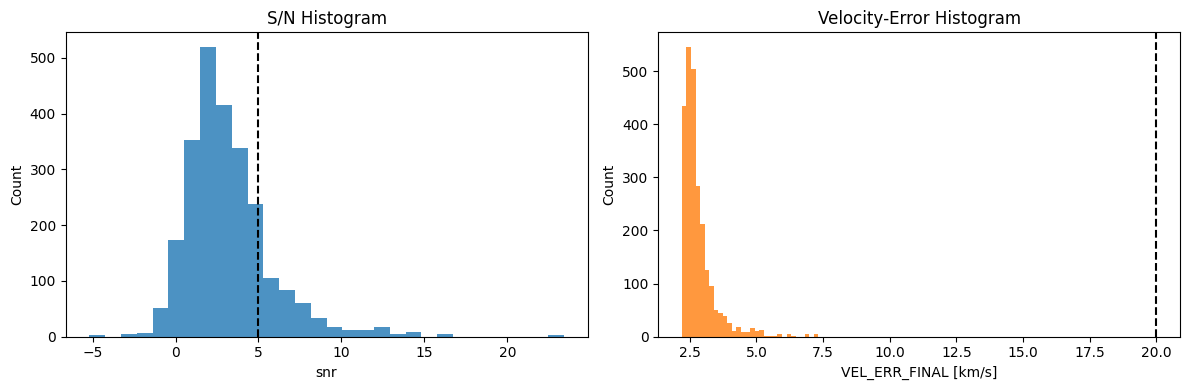

In [ ]:
# --- QUALIFY RESULTS ---

# 1) Reload photometry & your snr/clean tables
phot_df = pd.read_csv(photometry_csv)
phot_df["SLIT"] = phot_df["SLIT"].astype(int)
n_phot   = len(phot_df)
u_phot   = phot_df["star_name"].nunique()

n_snr    = len(snr_df)
u_snr    = snr_df["star_name"].nunique()

# 2) Do an outer merge to see who got matched
merged_all = phot_df.merge(
    snr_df, on=["MASK","SLIT","star_name"],
    how="outer", indicator=True
)

n_both   = (merged_all["_merge"]=="both").sum()
n_phot_o = (merged_all["_merge"]=="left_only").sum()
n_snr_o  = (merged_all["_merge"]=="right_only").sum()

# 3) Re‐merge the “good” inner join and apply your cuts
merged = phot_df.merge(snr_df, on=["MASK","SLIT","star_name"], how="inner")
n_merge = len(merged)

clean  = merged[
    (merged["snr"]           >= snr_cut) &
    (merged["VEL_ERR_FINAL"] <= velerr_cut)
]
n_snr_cut    = (merged["snr"]           >= snr_cut).sum()
n_velerr_cut = (merged["VEL_ERR_FINAL"] <= velerr_cut).sum()
n_clean      = len(clean)

# 4) Print a summary
print("=== DATASET SIZES ===")
print(f"Photometry entries       : {n_phot}  ({u_phot} unique stars)")
print(f"S/N table entries        : {n_snr}  ({u_snr} unique stars)")
print()
print("=== MERGE REPORT ===")
print(f"Matched (inner join)     : {n_both}")
print(f" Photometry‐only (lost)  : {n_phot_o}")
print(f" S/N‐only (unmatched)    : {n_snr_o}")
print()
print("=== CUTS REPORT (on {n_merge} merged entries) ===")
print(f" S/N ≥ {snr_cut}           : {n_snr_cut} pass")
print(f" VEL_ERR_FINAL ≤ {velerr_cut} : {n_velerr_cut} pass")
print(f" After both cuts          : {n_clean} pass")
print()

# 5) Quick stats on S/N and VEL_ERR_FINAL
print("=== STATISTICS ===")
print("snr distribution:")
display(merged["snr"].describe().to_frame().T)

print("VEL_ERR_FINAL distribution:")
display(merged["VEL_ERR_FINAL"].describe().to_frame().T)

# 6) Histograms (optional)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(merged["snr"].dropna(), bins=30, alpha=0.8, color="C0")
axes[0].axvline(snr_cut, color="k", linestyle="--")
axes[0].set_xlabel("snr"); axes[0].set_ylabel("Count"); axes[0].set_title("S/N Histogram")

axes[1].hist(merged["VEL_ERR_FINAL"].dropna(), bins=30, alpha=0.8, color="C1")
axes[1].axvline(velerr_cut, color="k", linestyle="--")
axes[1].set_xlabel("VEL_ERR_FINAL [km/s]"); axes[1].set_ylabel("Count")
axes[1].set_title("Velocity‐Error Histogram")

plt.tight_layout()
plt.show()

In [ ]:
# 1) Identify photometry‐only & spectrum‐only entries
lost_phot = merged_all[merged_all["_merge"]=="left_only"]
lost_spec = merged_all[merged_all["_merge"]=="right_only"]

print("Photometry‐only stars:", lost_phot["star_name"].unique())
print("Spectrum‐only stars :", lost_spec["star_name"].unique()[:20], "...")

# 2) How many unique stars survive
print("Unique stars after cuts:", clean["star_name"].nunique())

# 3) Negative S/N cases
neg_snr = merged[merged["snr"] < 0]
print(f"Entries with snr<0: {len(neg_snr)}")
display(neg_snr.head())

# 4) Propose a stricter vel_err cut
for thr in [5, 3]:
    print(f"VEL_ERR ≤ {thr} km/s:", (merged["VEL_ERR_FINAL"] <= thr).sum(), "rows")

Photometry‐only stars: ['os1' 'os2' 'os3' 'os4' 'os5' 'os8' 'os7' 'RHeB2844' 'RHeB2848'
 'RHeB2856' 'RHeB2864' 'RHeB2868' 'RHeB2871' 'RHeB2888' 'RHeB2889'
 'RHeB2893' 'RHeB2895' 'RHeB28118' 'RHeB28122' 'RHeB28128' 'RHeB28129'
 'RHeB28144' 'RHeB28147' 'RHeB28149' 'RHeB28154' 'RHeB28163' 'RHeB28166'
 'RHeB28179' 'RHeB28181' 'RHeB28184' 'RHeB2929' 'RHeB2936' 'RHeB2940'
 'RHeB30239' 'PNe_49' 'PNe_107' 'PNe_126' 'PNe_147' 'PNe_h8' 'os9' 'os6'
 'RHeB2830' 'RHeB2833' 'RHeB2838' 'RHeB2841' 'RHeB2843' 'RHeB2853'
 'RHeB2859' 'RHeB2869' 'RHeB2874' 'RHeB2879' 'RHeB2883' 'RHeB2884'
 'RHeB2886' 'RHeB2891' 'RHeB2892' 'RHeB2897' 'RHeB28108' 'RHeB28110'
 'RHeB28113' 'RHeB28114' 'RHeB28137' 'RHeB28146' 'RHeB295' 'RHeB298'
 'RHeB2916' 'RHeB2918' 'RHeB30210' 'RHeB30216' 'RHeB30232' 'RHeB30235'
 'PNe_25' 'PNe_56' 'PNe_69' 'PNe_72' 'PNe_77' 'PNe_85' 'PNe_h2' 'RHeB2816'
 'RHeB2826' 'RHeB2837' 'RHeB2840' 'RHeB2846' 'RHeB2850' 'RHeB2851'
 'RHeB2854' 'RHeB2857' 'RHeB2861' 'RHeB2862' 'RHeB2887' 'RHeB28104'
 'RHe

Unnamed: 0    MASK  SLIT  star_name         RA        DEC   F814W  \
106          89  M32RA1    72  RGB281096  10.717311  40.874974  21.221   
107          89  M32RA1    72  RGB281096  10.717311  40.874974  21.221   
116          98  M32RA1    79  RGB281198  10.575787  40.880178  21.591   
117          98  M32RA1    79  RGB281198  10.575787  40.880178  21.591   
122         101  M32RA1    82  RGB281377  10.622010  40.888873  21.043   

         F475W     v_helio    TYPE  ...   eta_kpc  R_init_deproj_M31_kpc  \
106  24.748000 -395.158343  target  ... -5.340249              16.289171   
107  24.748000 -395.158343  target  ... -5.340249              16.289171   
116  24.785001 -600.729574  target  ... -5.269113              11.576583   
117  24.785001 -600.729574  target  ... -5.269113              11.576583   
122  25.220000 -351.908404  target  ... -5.151781              12.663971   

     v_rot_M31_model   theta_j  R_final_deproj_M31_kpc   i_j_rad    PA_rad  \
106       261.370756  1.880751               13.519261  1.302761  0.628233   
107       261.370756  1.880751               13.519261  1.302761  0.628233   
116       266.074388  2.008720               11.346369  1.333093  0.674373   
117       266.074388  2.008720               11.346369  1.333093  0.674373   
122       264.744651  1.942936               12.208279  1.331827  0.668885   

     VEL_ERR_FINAL  R_proj_M32_kpc       snr  
106       3.095772        0.502596 -0.698712  
107       3.095772        0.502596 -0.698712  
116       4.933615        1.030027 -0.513342  
117       4.933615        1.030027 -0.513342  
122       2.458957        0.661488 -1.480116  

[5 rows x 23 columns]

VEL_ERR ≤ 5 km/s: 2428 rows
VEL_ERR ≤ 3 km/s: 1910 rows


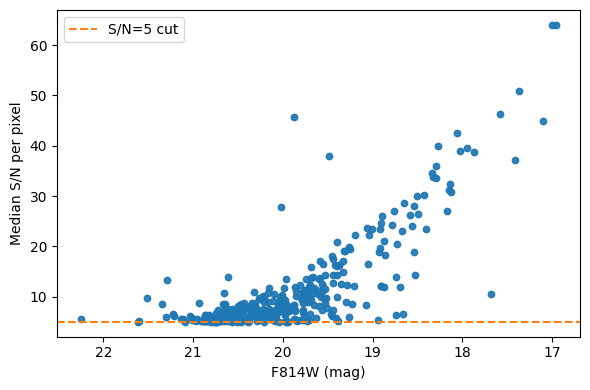

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(clean_df["F814W"], clean_df["snr"], s=20, alpha=0.7)
plt.gca().invert_xaxis()
plt.axhline(5, color="C1", linestyle="--", label="S/N=5 cut")
plt.xlabel("F814W (mag)")
plt.ylabel("Median S/N per pixel")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_raw    = pd.read_csv("M32_Final.csv")
df_ser    = df_raw[df_raw['TYPE']   == 'serendip'].copy()
df_clear  = df_raw[df_raw['CONTAM'] <  0.2      ].copy()
df_contam = df_raw[df_raw['CONTAM'] >= 0.2      ].copy()
df_tar    = df_raw[df_raw['TYPE']   == 'target' ].copy()

In [ ]:
print(df_ser.columns)

Index(['Unnamed: 0', 'MASK', 'SLIT', 'star_name', 'RA', 'DEC', 'F814W',
       'F475W', 'v_helio', 'TYPE', 'CONTAM', 'VEL_ERR', 'xi_kpc', 'eta_kpc',
       'R_init_deproj_M31_kpc', 'v_rot_M31_model', 'theta_j',
       'R_final_deproj_M31_kpc', 'i_j_rad', 'PA_rad', 'VEL_ERR_FINAL',
       'R_proj_M32_kpc'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
import FunctionsM32 as FM
from scipy.stats import norm

# ――― Helper: turn flat list → parameter dict ―――
def parse_param_dict(param_values):
    """
    param_values is length 14 (5‐comp) or 8 (3‐comp).
    Returns dict with keys
      'sigma_disk', 'f1','mu1','sigma1', …, 'f_rot'
    """
    L = len(param_values)
    d = {}

    if L == 14:   # five Gaussians + disk
        d['sigma_disk'] = param_values[0]
        idx = 1
        for i in range(1,5):
            d[f'f{i}']     = param_values[idx];   idx += 1
            d[f'mu{i}']    = param_values[idx];   idx += 1
            d[f'sigma{i}'] = param_values[idx];   idx += 1
        d['f_rot'] = param_values[idx]

    elif L == 8:  # two Gaussians + disk
        d['sigma_disk'] = param_values[0]
        idx = 1
        for i in range(1,3):
            d[f'f{i}']     = param_values[idx];   idx += 1
            d[f'mu{i}']    = param_values[idx];   idx += 1
            d[f'sigma{i}'] = param_values[idx];   idx += 1
        d['f_rot'] = param_values[idx]

    else:
        raise ValueError(f"Unsupported parameter length {L}; expected 8 or 14.")
    return d

# ――― Mentor’s function, untouched ―――
def compute_all_component_probabilities(
    df_star,
    params_row,
    num_components=5,
    f_rot_key='f_rot',
    sigma_disk_key='sigma_disk',
    v_sys=-300.0
):
    """
    Returns dict of per‐star probabilities { 'P1','P2',…,'Pdisk' }.
    """
    # 1) kinematics in → v_offset
    theta_j, i_j_rad, v_helio, v_rot_M31_model = FM.input_data(df_star)
    v_offset, _ = FM.calculate_voffset(
        f_rot           = params_row[f_rot_key],
        v_rot_M31_model = v_rot_M31_model,
        theta_j         = theta_j,
        i_j_rad         = i_j_rad,
        v_helio         = v_helio,
        v_sys           = v_sys
    )

    # 2) build PDFs
    denom = np.zeros_like(v_helio)
    probs = {}

    # 3) how many static Gaussians?
    if num_components == 5:
        n_gauss = 4
    elif num_components == 3:
        n_gauss = 2
    else:
        raise ValueError("num_components must be 3 or 5")

    # 4) static Gaussian components
    for i in range(1, n_gauss+1):
        f_i   = params_row[f'f{i}']
        mu_i  = params_row[f'mu{i}']
        sig_i = params_row[f'sigma{i}']
        pdf_i = f_i * norm.pdf(v_helio, loc=mu_i, scale=sig_i)
        probs[f'P{i}'] = pdf_i
        denom += pdf_i

    # 5) rotating disk component
    f_disk     = params_row[f_rot_key]
    sigma_disk = params_row[sigma_disk_key]
    pdf_disk   = f_disk * norm.pdf(v_offset, loc=0, scale=sigma_disk)
    probs['Pdisk'] = pdf_disk
    denom += pdf_disk

    # 6) normalize to unity
    eps = np.finfo(float).eps
    denom += eps
    for k in probs:
        probs[k] = probs[k] / denom

    return probs

# ――― 1) Your best‐fit parameters for each sample ―――
param_target  = [68.18,
                 0.38, -333.96, 169.58,
                 0.09, -200.86,  29.51,
                 0.02,  -46.04,   37.33,
                 0.03, -613.08,   34.62,
                 1.02]

param_ser     = [82.59,
                 0.37, -331.32, 140.54,
                 0.22, -199.18,  32.73,
                 1.21]

param_clear   = [68.89,
                 0.38, -333.27, 169.24,
                 0.10, -201.52,  30.52,
                 0.02,  -49.76,   40.32,
                 0.03, -609.83,   33.45,
                 1.03]

param_contam  = [78.44,
                 0.36, -334.79, 135.35,
                 0.24, -198.42,  30.66,
                 1.20]

# parse into dicts
p_tar   = parse_param_dict(param_target)
p_ser   = parse_param_dict(param_ser)
p_clear = parse_param_dict(param_clear)
p_cont  = parse_param_dict(param_contam)

# ――― 2) Load & split the master catalog ―――
df_raw = pd.read_csv("M32_Final.csv")

df_target = FM.sample_choose(df_raw, target=True,  ser=False, clear=False, contam=False)
df_ser    = FM.sample_choose(df_raw, target=False, ser=True,  clear=False, contam=False)
df_clear  = FM.sample_choose(df_raw, target=False, ser=False, clear=True,  contam=False)
df_contam = FM.sample_choose(df_raw, target=False, ser=False, clear=False, contam=True)

# threshold for membership
P_THRESH = 0
V_SYS    = -300.0   # make explicit

# ――― 3) Compute, assign, filter, save ―――
for name, (df, params, ncomp) in {
    'target':  (df_target,  p_tar,   5),
    'serendip':(df_ser,     p_ser,   3),
    'clear':   (df_clear,   p_clear, 5),
    'contam':  (df_contam,  p_cont,  3)
}.items():

    # compute all P_i
    probs = compute_all_component_probabilities(
        df_star        = df,
        params_row     = params,
        num_components = ncomp,
        v_sys          = V_SYS
    )

    # THIS is the true disk membership
    df['P_M32'] = probs['P2']

    # apply your cut and save
    df_cut = df.query("P_M32 > @P_THRESH").reset_index(drop=True)
    df_cut.to_csv(f"{name}_PM32.csv", index=False)
    print(f"{name:9s}: {len(df_cut)} stars (P_M32>{P_THRESH:.2f})")

print("Done: saved *_PM32.csv with corrected P_M32 = Pdisk.")

target   : 1359 stars (P_M32>0.00)
serendip : 616 stars (P_M32>0.00)
clear    : 1553 stars (P_M32>0.00)
contam   : 422 stars (P_M32>0.00)
Done: saved *_PM32.csv with corrected P_M32 = Pdisk.


/tmp/ipython-input-2199689385.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P_M32'] = probs['P2']
/tmp/ipython-input-2199689385.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P_M32'] = probs['P2']
/tmp/ipython-input-2199689385.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

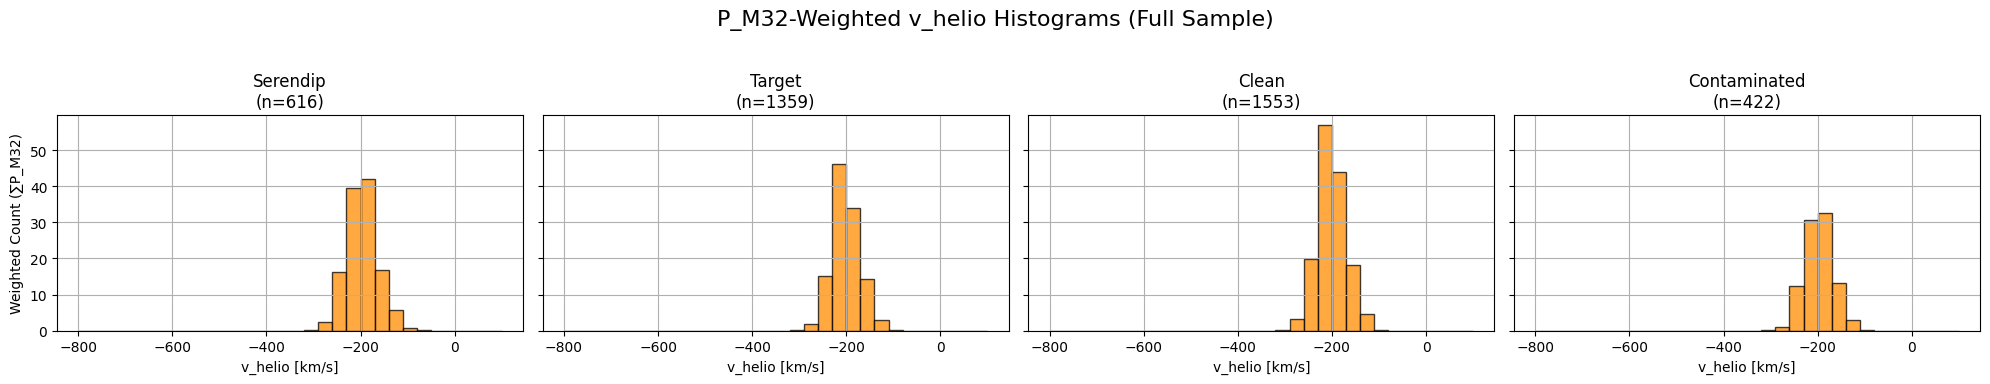

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Paths to your four P_M32‐filtered catalogs
files = {
    'Serendip':   "serendip_PM32.csv",
    'Target':     "target_PM32.csv",
    'Clean':      "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

# 2) Load into DataFrames
groups = {name: pd.read_csv(path) for name, path in files.items()}

# 3) Histogram settings
bin_n    = 30
v_range  = (-800, 100)
bins     = np.linspace(v_range[0], v_range[1], bin_n + 1)

# 4) Plot one row of four histograms (no radial split)
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
fig.suptitle("P_M32‐Weighted v_helio Histograms (Full Sample)", fontsize=16)

for ax, (title, df) in zip(axes, groups.items()):
    v = df['v_helio'].values
    w = df['P_M32'].values

    ax.hist(
        v,
        bins=bins,
        weights=w,
        range=v_range,
        color='darkorange',
        edgecolor='black',
        alpha=0.75
    )
    ax.set_title(f"{title}\n(n={len(v)})")
    ax.set_xlabel("v_helio [km/s]")
    ax.grid(True)

axes[0].set_ylabel("Weighted Count (∑P_M32)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

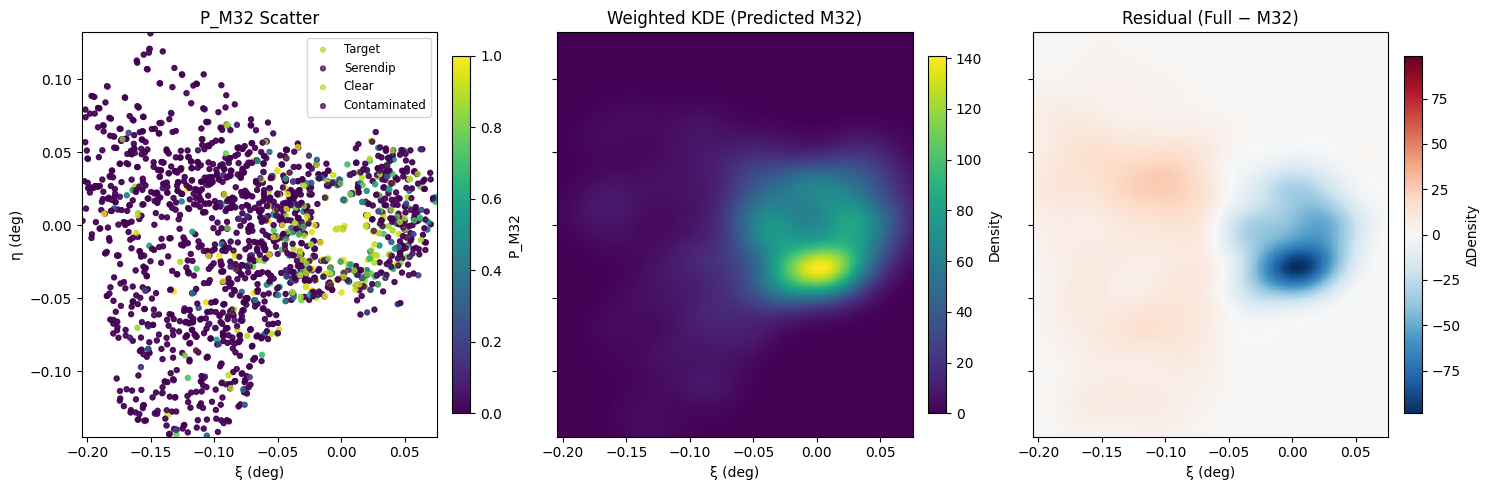

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ── CONFIGURE YOUR INPUT FILES ───────────────────────────────────────────────
catalog = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

# M32 center (deg)
RA0_deg, Dec0_deg = 10.67417, 40.86639

def compute_xi_eta(df):
    """
    Convert (RA, DEC) into tangential offsets (ξ, η) in degrees.
    """
    dRA  = (df['RA']  - RA0_deg) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    return dRA, dDec

# ── LOAD DATA & BUILD FULL SAMPLE KDE ────────────────────────────────────────
# Read each subset into a dict of DataFrames
dfs = {name: pd.read_csv(path) for name, path in catalog.items()}

# Concatenate for the full‐sample KDE
full_df = pd.concat(dfs.values(), ignore_index=True)
xi_full, eta_full = compute_xi_eta(full_df)

# Grid for evaluating KDEs
ngrid = 200
xi_grid, eta_grid = np.meshgrid(
    np.linspace(xi_full.min(), xi_full.max(), ngrid),
    np.linspace(eta_full.min(), eta_full.max(), ngrid)
)
positions = np.vstack([xi_grid.ravel(), eta_grid.ravel()])

# Full‐sample (unweighted) KDE
full_kde     = gaussian_kde(np.vstack([xi_full, eta_full]))
full_density = full_kde(positions).reshape(ngrid, ngrid)

# ── COMPUTE WEIGHTED KDE (using P_M32) ────────────────────────────────────────
# Stack all ξ, η, and weights = P_M32
xi_all  = np.hstack([compute_xi_eta(df)[0] for df in dfs.values()])
eta_all = np.hstack([compute_xi_eta(df)[1] for df in dfs.values()])
w_all   = np.hstack([df['P_M32'].values       for df in dfs.values()])

kde_w    = gaussian_kde(np.vstack([xi_all, eta_all]), weights=w_all)
dens_w   = kde_w(positions).reshape(ngrid, ngrid)

# ── PLOTTING ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    ncols=3,
    figsize=(15, 5),
    sharex=True,
    sharey=True
)

# Panel 1: scatter of P_M32
ax = axes[0]
for label, df in dfs.items():
    xi, eta = compute_xi_eta(df)
    ax.scatter(xi, eta,
               c=df['P_M32'],
               cmap='viridis',
               s=12, alpha=0.7,
               label=label)
ax.set_title("P_M32 Scatter")
ax.set_xlabel("ξ (deg)")
ax.set_ylabel("η (deg)")
ax.legend(fontsize='small')
cb = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis'),
    ax=ax, fraction=0.046, pad=0.04
)
cb.set_label("P_M32")

# Panel 2: weighted KDE → predicted M32 density
ax = axes[1]
pcm = ax.pcolormesh(
    xi_grid, eta_grid, dens_w,
    shading='auto', cmap='viridis'
)
ax.set_title("Weighted KDE (Predicted M32)")
ax.set_xlabel("ξ (deg)")
cb = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("Density")

# Panel 3: residuals (full − weighted)
resid = full_density - dens_w
vmax  = np.abs(resid).max()

ax = axes[2]
pcm = ax.pcolormesh(
    xi_grid, eta_grid, resid,
    shading='auto', cmap='RdBu_r',
    vmin=-vmax, vmax=vmax
)
ax.set_title("Residual (Full − M32)")
ax.set_xlabel("ξ (deg)")
cb = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("ΔDensity")

plt.tight_layout()
plt.show()


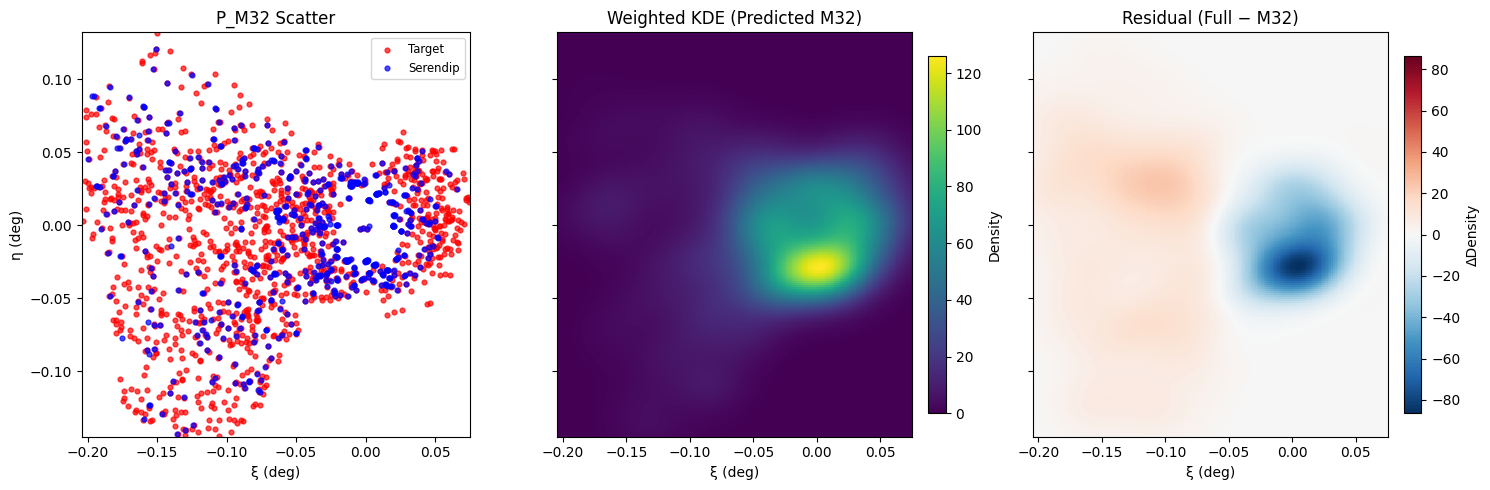

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ── INPUT FILES ──────────────────────────────────────────────────────────────
catalog = {
    'Target':   "target_PM32.csv",
    'Serendip': "serendip_PM32.csv"
}

RA0_deg, Dec0_deg = 10.67417, 40.86639

def compute_xi_eta(df):
    dRA  = (df['RA']  - RA0_deg) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    return dRA, dDec

# ── LOAD & KDE ───────────────────────────────────────────────────────────────
dfs = {name: pd.read_csv(path) for name, path in catalog.items()}
full_df = pd.concat(dfs.values(), ignore_index=True)
xi_full, eta_full = compute_xi_eta(full_df)

ngrid = 200
xi_grid, eta_grid = np.meshgrid(
    np.linspace(xi_full.min(), xi_full.max(), ngrid),
    np.linspace(eta_full.min(), eta_full.max(), ngrid)
)
positions = np.vstack([xi_grid.ravel(), eta_grid.ravel()])

full_kde     = gaussian_kde(np.vstack([xi_full, eta_full]))
full_density = full_kde(positions).reshape(ngrid, ngrid)

xi_all  = np.hstack([compute_xi_eta(df)[0] for df in dfs.values()])
eta_all = np.hstack([compute_xi_eta(df)[1] for df in dfs.values()])
w_all   = np.hstack([df['P_M32'].values       for df in dfs.values()])

kde_w    = gaussian_kde(np.vstack([xi_all, eta_all]), weights=w_all)
dens_w   = kde_w(positions).reshape(ngrid, ngrid)

# ── PLOTTING ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Panel 1: scatter
ax = axes[0]
color_dict = {'Target': 'red', 'Serendip': 'blue'}
for label, df in dfs.items():
    xi, eta = compute_xi_eta(df)
    ax.scatter(xi, eta, c=color_dict[label], s=12, alpha=0.7, label=label)
ax.set_title("P_M32 Scatter")
ax.set_xlabel("ξ (deg)")
ax.set_ylabel("η (deg)")
ax.legend(fontsize='small')

# Panel 2: weighted KDE
ax = axes[1]
pcm = ax.pcolormesh(xi_grid, eta_grid, dens_w, shading='auto', cmap='viridis')
ax.set_title("Weighted KDE (Predicted M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("Density")

# Panel 3: residuals
resid = full_density - dens_w
vmax  = np.abs(resid).max()
ax = axes[2]
pcm = ax.pcolormesh(xi_grid, eta_grid, resid, shading='auto', cmap='RdBu_r',
                    vmin=-vmax, vmax=vmax)
ax.set_title("Residual (Full − M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("ΔDensity")

plt.tight_layout()
plt.show()

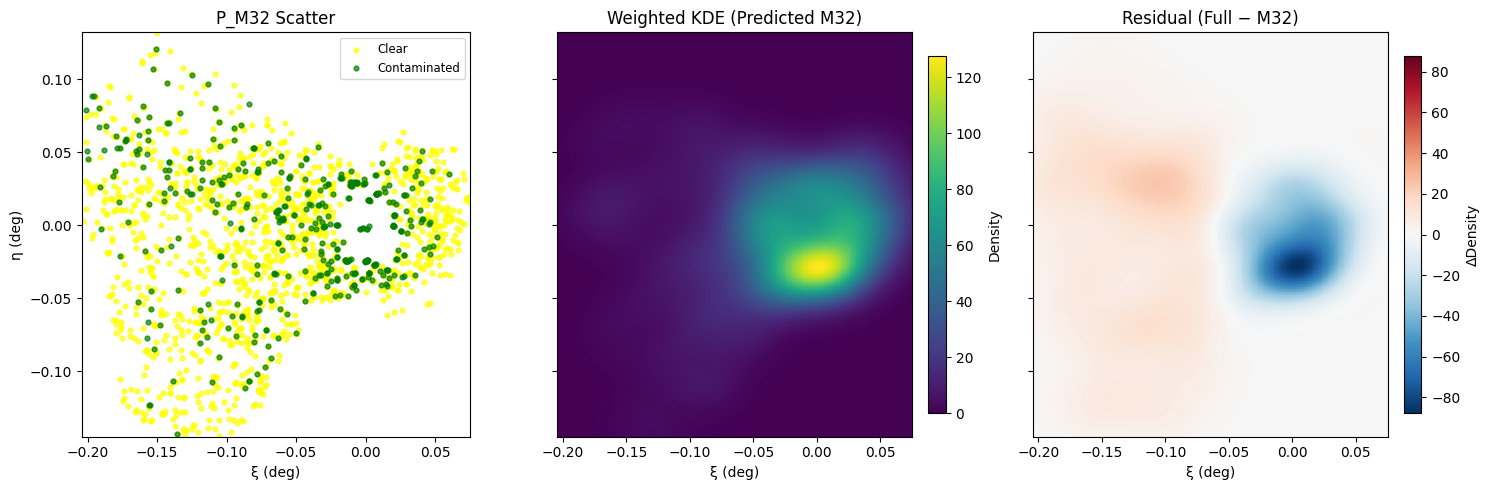

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ── INPUT FILES ──────────────────────────────────────────────────────────────
catalog = {
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

RA0_deg, Dec0_deg = 10.67417, 40.86639

def compute_xi_eta(df):
    dRA  = (df['RA']  - RA0_deg) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    return dRA, dDec

# ── LOAD & KDE ───────────────────────────────────────────────────────────────
dfs = {name: pd.read_csv(path) for name, path in catalog.items()}
full_df = pd.concat(dfs.values(), ignore_index=True)
xi_full, eta_full = compute_xi_eta(full_df)

ngrid = 200
xi_grid, eta_grid = np.meshgrid(
    np.linspace(xi_full.min(), xi_full.max(), ngrid),
    np.linspace(eta_full.min(), eta_full.max(), ngrid)
)
positions = np.vstack([xi_grid.ravel(), eta_grid.ravel()])

full_kde     = gaussian_kde(np.vstack([xi_full, eta_full]))
full_density = full_kde(positions).reshape(ngrid, ngrid)

xi_all  = np.hstack([compute_xi_eta(df)[0] for df in dfs.values()])
eta_all = np.hstack([compute_xi_eta(df)[1] for df in dfs.values()])
w_all   = np.hstack([df['P_M32'].values       for df in dfs.values()])

kde_w    = gaussian_kde(np.vstack([xi_all, eta_all]), weights=w_all)
dens_w   = kde_w(positions).reshape(ngrid, ngrid)

# ── PLOTTING ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Panel 1: scatter
ax = axes[0]
color_dict = {'Clear': 'yellow', 'Contaminated': 'green'}
for label, df in dfs.items():
    xi, eta = compute_xi_eta(df)
    ax.scatter(xi, eta, c=color_dict[label], s=12, alpha=0.7, label=label)
ax.set_title("P_M32 Scatter")
ax.set_xlabel("ξ (deg)")
ax.set_ylabel("η (deg)")
ax.legend(fontsize='small')

# Panel 2: weighted KDE
ax = axes[1]
pcm = ax.pcolormesh(xi_grid, eta_grid, dens_w, shading='auto', cmap='viridis')
ax.set_title("Weighted KDE (Predicted M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("Density")

# Panel 3: residuals
resid = full_density - dens_w
vmax  = np.abs(resid).max()
ax = axes[2]
pcm = ax.pcolormesh(xi_grid, eta_grid, resid, shading='auto', cmap='RdBu_r',
                    vmin=-vmax, vmax=vmax)
ax.set_title("Residual (Full − M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("ΔDensity")

plt.tight_layout()
plt.show()

/tmp/ipython-input-3562138385.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


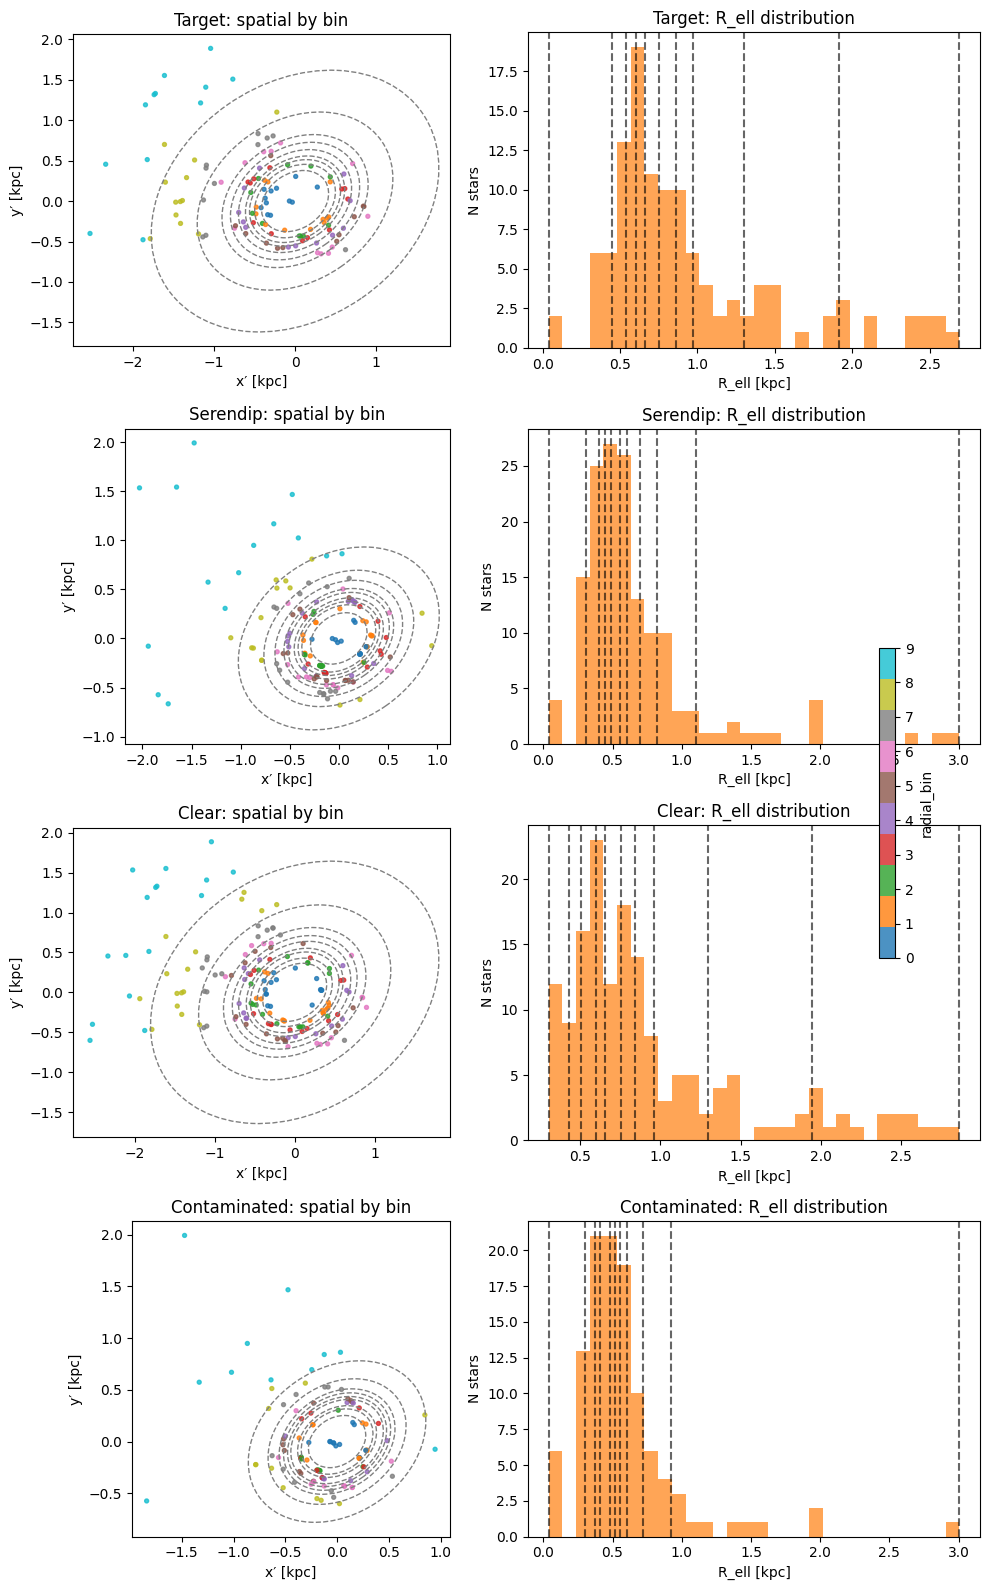

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# 1) Load your four P_M32‐filtered catalogs
files = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}
catalogs = {name: pd.read_csv(path) for name, path in files.items()}

# 2) M32 morphology + geometry parameters
RA0_deg, Dec0_deg = 10.67417, 40.86639    # center (deg)
PA_deg, q          = 34.7, 0.76           # major‐axis PA (deg) & axis ratio
Dist_kpc           = 780.0                # distance (kpc)
PA_rad             = np.deg2rad(PA_deg)

# 3) helper to compute deprojected elliptical radius
def compute_R_ell(df):
    dRA  = (df['RA']  - RA0_deg ) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    x = Dist_kpc * np.deg2rad(dRA)
    y = Dist_kpc * np.deg2rad(dDec)
    # rotate into galaxy frame
    x_pr =  x * np.cos(PA_rad) + y * np.sin(PA_rad)
    y_pr = -x * np.sin(PA_rad) + y * np.cos(PA_rad)
    return np.sqrt(x_pr**2 + (y_pr / q)**2), x_pr, y_pr

# 4) radial‐binning parameters
NBINS    = 10
quantile = np.linspace(0, 1, NBINS + 1)

# 5) compute R_ell, x_pr, y_pr, assign bins for each catalog
for name, df in catalogs.items():
    df = df.query("P_M32 >= 0.5").copy()
    R_ell, x_pr, y_pr = compute_R_ell(df)
    df['R_ell_kpc'] = R_ell
    # compute bin‐edges (equal‐count annuli)
    edges = np.quantile(R_ell, quantile)
    df['radial_bin'] = pd.cut(
        R_ell, bins=edges,
        labels=False,
        include_lowest=True
    )
    df['x_pr'], df['y_pr'] = x_pr, y_pr
    catalogs[name] = df

# 6) Plotting: 4×2 grid + single colorbar on the right
fig, axes = plt.subplots(
    4, 2, figsize=(10, 16),
    gridspec_kw={'width_ratios': [1, 1.2]}
)

for ax_row, (name, df) in zip(axes, catalogs.items()):
    # LEFT: scatter in deprojected coords colored by bin
    sc = ax_row[0].scatter(
        df['x_pr'], df['y_pr'],
        c=df['radial_bin'], cmap='tab10',
        s=8, alpha=0.8
    )
    ax_row[0].set_aspect('equal', 'box')
    ax_row[0].set_title(f"{name}: spatial by bin")
    ax_row[0].set_xlabel("x′ [kpc]")
    ax_row[0].set_ylabel("y′ [kpc]")

    # overlay ellipses at each bin‐edge
    edges = np.quantile(df['R_ell_kpc'], quantile)
    for r in edges[1:-1]:
        ell = Ellipse(
            xy=(0, 0),
            width=2*r, height=2*r*q,
            angle=PA_deg,
            edgecolor='gray',
            facecolor='none',
            linestyle='--'
        )
        ax_row[0].add_patch(ell)

    # RIGHT: histogram of R_ell with bin‐edge lines
    ax_row[1].hist(df['R_ell_kpc'], bins=30, color='C1', alpha=0.7)
    for edge in edges:
        ax_row[1].axvline(edge, color='k', ls='--', alpha=0.6)
    ax_row[1].set_title(f"{name}: R_ell distribution")
    ax_row[1].set_xlabel("R_ell [kpc]")
    ax_row[1].set_ylabel("N stars")

# 7) Single colorbar spanning all left‐panels
all_axes = axes.ravel().tolist()
cbar = fig.colorbar(
    sc,
    ax=all_axes,
    orientation='vertical',
    fraction=0.02,  # thickness relative to figure width
    pad=0.03,       # space between panels and bar
    label='radial_bin'
)

fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# ――― Bootstrap error estimators ―――
def bootstrap_mean_err(v, w, n_boot=500):
    """Bootstrap uncertainty on weighted mean."""
    if len(v) == 0 or w.sum() == 0:
        return np.nan
    p = w / w.sum()
    means = []
    for _ in range(n_boot):
        idx = np.random.choice(len(v), size=len(v), replace=True, p=p)
        means.append(np.average(v[idx], weights=w[idx]))
    return np.std(means)

def bootstrap_disp_err(v, w, n_boot=500):
    """Bootstrap uncertainty on weighted dispersion."""
    if len(v) == 0 or w.sum() == 0:
        return np.nan
    p = w / w.sum()
    sigs = []
    for _ in range(n_boot):
        idx = np.random.choice(len(v), size=len(v), replace=True, p=p)
        vr, wi = v[idx], w[idx]
        m    = np.average(vr, weights=wi)
        var  = np.average((vr - m)**2, weights=wi)
        sigs.append(np.sqrt(var))
    return np.std(sigs)

# ――― Settings ―――
V_SYS     = -200.0    # systemic velocity of M32 [km/s]
MIN_COUNT = 10        # minimum stars per bin
N_BOOT    = 500       # number of bootstrap resamples

# catalogs: dict of DataFrames from Step 1, each with
#  - 'v_helio'
#  - 'P_M32'
#  - 'R_ell_kpc'
#  - 'radial_bin' (0…NBINS-1)
# e.g. catalogs['Target'], catalogs['Serendip'], etc.

profiles = {}

for name, df in catalogs.items():
    # prepare storage
    nbins = df['radial_bin'].max() + 1
    r_cent    = np.zeros(nbins)
    v_mean    = np.zeros(nbins)
    v_mean_e  = np.zeros(nbins)
    v_disp    = np.zeros(nbins)
    v_disp_e  = np.zeros(nbins)

    # compute per‐bin stats
    for b in range(nbins):
        sub = df[df['radial_bin'] == b]
        r_cent[b] = sub['R_ell_kpc'].mean()

        if len(sub) < MIN_COUNT:
            v_mean[b]   = np.nan
            v_mean_e[b] = np.nan
            v_disp[b]   = np.nan
            v_disp_e[b] = np.nan
            continue

        # velocities relative to systemic
        v = sub['v_helio'].values - V_SYS
        w = sub['P_M32'].values

        # weighted mean and dispersion
        μ     = np.average(v, weights=w)
        var   = np.average((v - μ)**2, weights=w)
        σ     = np.sqrt(var)

        # bootstrap uncertainties
        eμ = bootstrap_mean_err(v, w, n_boot=N_BOOT)
        eσ = bootstrap_disp_err(v, w, n_boot=N_BOOT)

        v_mean[b], v_mean_e[b] = μ,  eμ
        v_disp[b], v_disp_e[b] = σ,  eσ

    # assemble into a DataFrame for easy plotting/fitting
    profiles[name] = pd.DataFrame({
        'R_cent_kpc':   r_cent,
        'v_mean':       v_mean,
        'v_mean_err':   v_mean_e,
        'v_disp':       v_disp,
        'v_disp_err':   v_disp_e
    })

    print(f"{name}:")
    print(profiles[name].to_string(index=False, float_format='%.2f'))
    print("\n" + "-"*60 + "\n")

# `profiles` now holds one DataFrame per dataset with your binned ⟨v⟩(R) and σ(R).

Target:
 R_cent_kpc  v_mean  v_mean_err  v_disp  v_disp_err
       0.32    5.48        3.62   13.13        2.14
       0.50    8.39        3.52   13.33        2.21
       0.58   -3.98        2.65    9.21        2.26
       0.63    6.22        3.94   14.28        2.00
       0.72   10.75        4.16   15.36        2.07
       0.81    3.88        3.92   13.40        2.22
       0.91   -2.00        3.91   13.69        2.96
       1.14    5.08        4.74   15.97        2.43
       1.52   -0.34        5.42   19.07        2.28
       2.32   -0.60        5.58   20.02        2.49

------------------------------------------------------------

Serendip:
 R_cent_kpc  v_mean  v_mean_err  v_disp  v_disp_err
       0.23    8.04        4.27   18.34        3.53
       0.36    4.34        4.36   17.32        2.02
       0.41   14.63        3.75   16.42        3.48
       0.48   -0.63        4.80   20.83        3.74
       0.52    3.54        5.94   25.02        3.32
       0.57   11.14        6.16   2

Best‐fit rotation‐curve parameters:
Target        V0 = -2.71 ± 2.87 km/s, R0 = -0.00 ± 0.97 kpc
Serendip      V0 = 8.00 ± 3.81 km/s, R0 = 0.00 ± 0.30 kpc
Clear         V0 = -2.55 ± 2.86 km/s, R0 = -0.00 ± 1.00 kpc
Contaminated  V0 = 6.27 ± 3.50 km/s, R0 = 0.00 ± 0.27 kpc


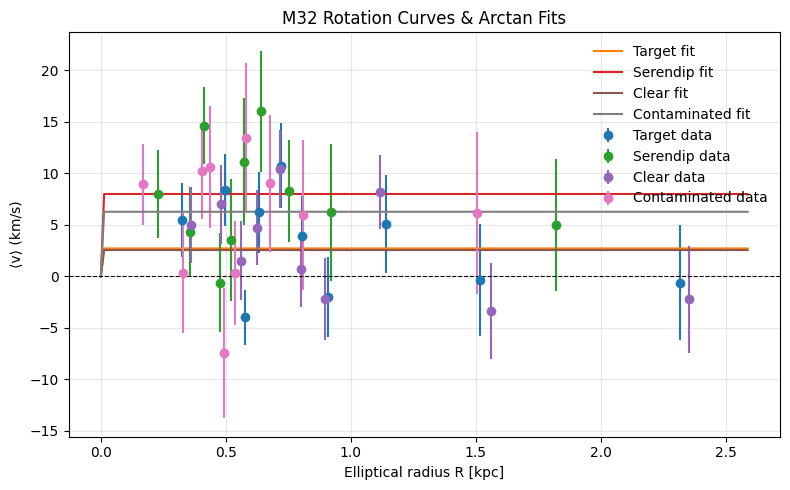

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1) Define the arctan rotation‐curve model
def arctan_model(R, V0, R0):
    """
    v(R) = (2 V0 / π) * arctan(R / R0)
    R [kpc], V0 [km/s], R0 [kpc]
    """
    return 2 * V0 / np.pi * np.arctan(R / R0)

# 2) Prepare containers for best‐fit parameters
fit_results = {}

# 3) Fit the model to each profile’s rotation curve
for name, df in profiles.items():
    # drop bins with NaN or too large errors
    mask = (~df['v_mean'].isna()) & (~df['v_mean_err'].isna())
    R = df.loc[mask, 'R_cent_kpc'].values
    v = df.loc[mask, 'v_mean'].values
    v_err = df.loc[mask, 'v_mean_err'].values

    # initial guess: V0 ∼ max(|v|), R0 ∼ median(R)
    p0 = [np.nanmax(np.abs(v)), np.median(R)]

    # weighted least‐squares fit
    popt, pcov = curve_fit(
        arctan_model,
        R, v,
        sigma=v_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=5000
    )
    V0, R0 = popt
    err_V0, err_R0 = np.sqrt(np.diag(pcov))

    fit_results[name] = {
        'V0': V0,         'V0_err': err_V0,
        'R0': R0,         'R0_err': err_R0
    }

# 4) Print out the fit parameters
print("Best‐fit rotation‐curve parameters:")
for name, params in fit_results.items():
    print(f"{name:12s}  V0 = {params['V0']:.2f} ± {params['V0_err']:.2f} km/s, "
          f"R0 = {params['R0']:.2f} ± {params['R0_err']:.2f} kpc")

# 5) Plot data + best‐fit curves
fig, ax = plt.subplots(figsize=(8, 5))

# define a smooth R grid for plotting
R_fit = np.linspace(0, max(df['R_cent_kpc'].max() for df in profiles.values())*1.1, 200)

for name, df in profiles.items():
    # data points with error bars
    ax.errorbar(
        df['R_cent_kpc'], df['v_mean'],
        yerr=df['v_mean_err'],
        fmt='o', label=f"{name} data"
    )
    # overplot best‐fit model
    V0, R0 = fit_results[name]['V0'], fit_results[name]['R0']
    ax.plot(
        R_fit, arctan_model(R_fit, V0, R0),
        '-', label=f"{name} fit"
    )

ax.axhline(0, color='k', linestyle='--', lw=0.8)
ax.set_xlabel("Elliptical radius R [kpc]")
ax.set_ylabel("⟨v⟩ (km/s)")
ax.set_title("M32 Rotation Curves & Arctan Fits")
ax.legend(frameon=False, loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-3894673522.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


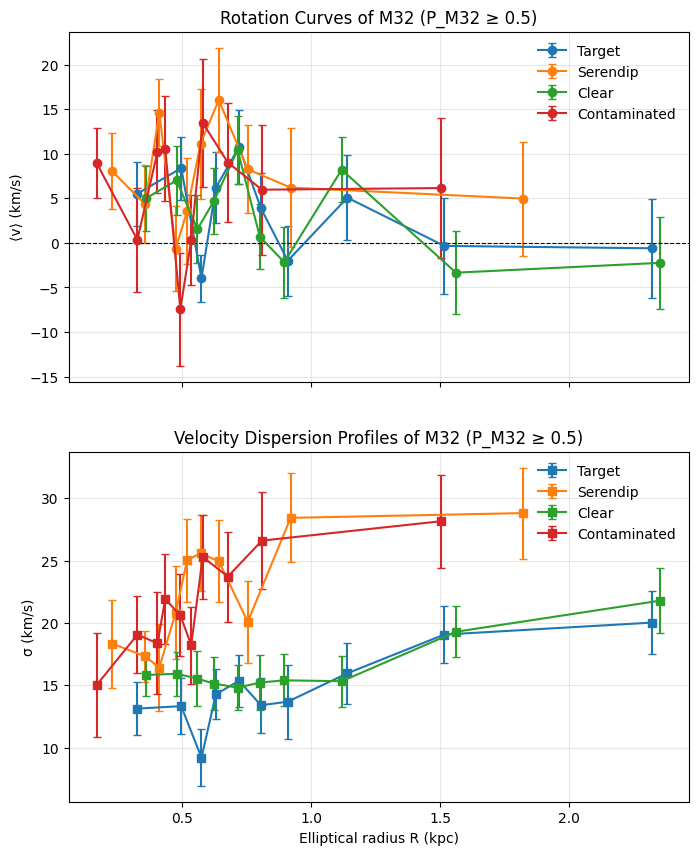

In [ ]:
import matplotlib.pyplot as plt

# Assume `profiles` dict from your previous step:
# profiles = {
#     'Target':       DataFrame(...),
#     'Serendip':     DataFrame(...),
#     'Clear':        DataFrame(...),
#     'Contaminated': DataFrame(...)
# }

# Optional: define a consistent color cycle for each catalog
colors = {
    'Target':       'C0',
    'Serendip':     'C1',
    'Clear':        'C2',
    'Contaminated': 'C3'
}

# Create a figure with two vertical panels: rotation curve & dispersion profile
fig, (ax_rot, ax_disp) = plt.subplots(
    2, 1,
    figsize=(8, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.2}
)

# 1) Plot rotation curves (v_mean vs R_cent_kpc)
for name, df in profiles.items():
    ax_rot.errorbar(
        df['R_cent_kpc'],
        df['v_mean'],
        yerr=df['v_mean_err'],
        marker='o',
        linestyle='-',
        label=name,
        color=colors[name],
        capsize=3
    )

ax_rot.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax_rot.set_ylabel('⟨v⟩ (km/s)')
ax_rot.set_title('Rotation Curves of M32 (P_M32 ≥ 0.5)')
ax_rot.legend(frameon=False, loc='upper right')
ax_rot.grid(alpha=0.3)

# 2) Plot dispersion profiles (v_disp vs R_cent_kpc)
for name, df in profiles.items():
    ax_disp.errorbar(
        df['R_cent_kpc'],
        df['v_disp'],
        yerr=df['v_disp_err'],
        marker='s',
        linestyle='-',
        label=name,
        color=colors[name],
        capsize=3
    )

ax_disp.set_xlabel('Elliptical radius R (kpc)')
ax_disp.set_ylabel('σ (km/s)')
ax_disp.set_title('Velocity Dispersion Profiles of M32 (P_M32 ≥ 0.5)')
ax_disp.legend(frameon=False, loc='upper right')
ax_disp.grid(alpha=0.3)

plt.tight_layout()
plt.show()

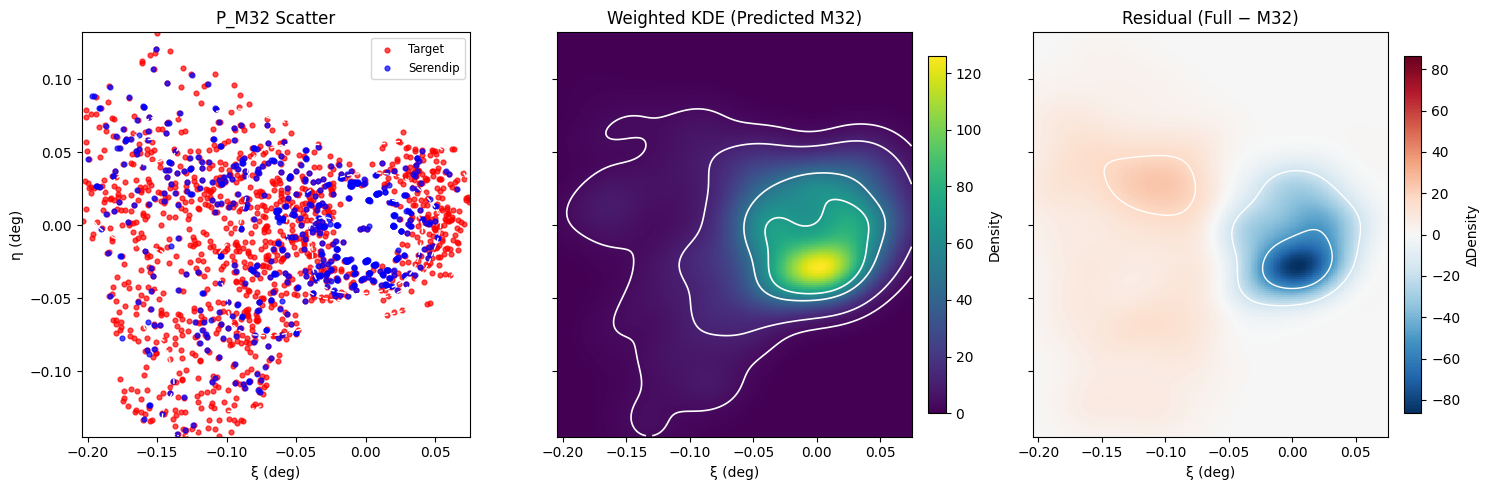

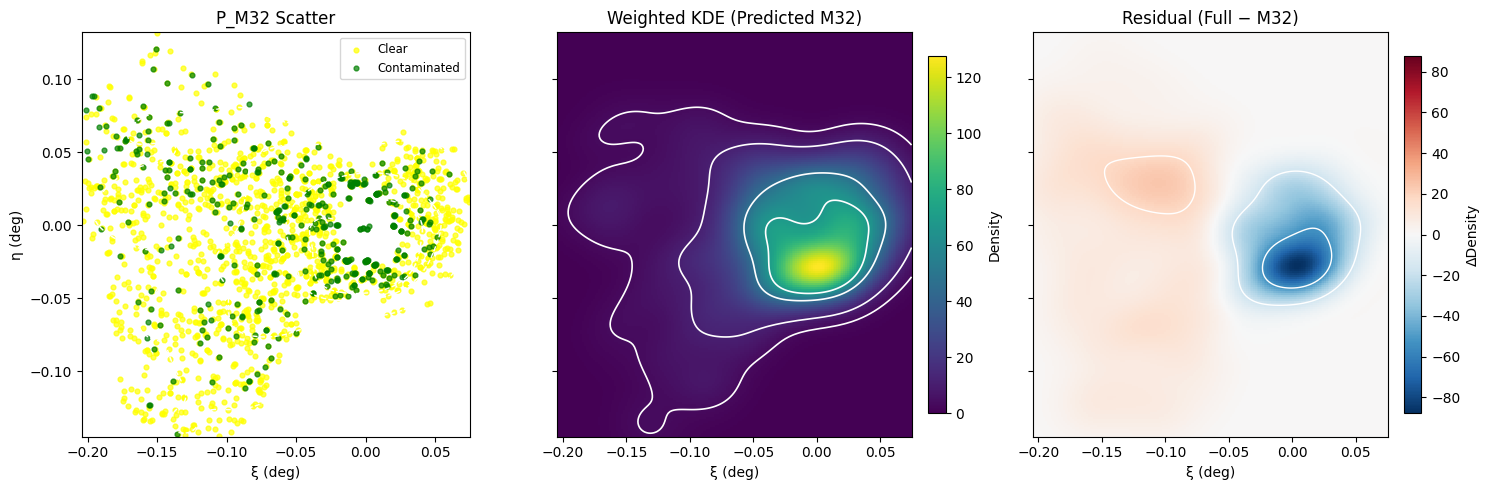

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ── INPUT FILES ──────────────────────────────────────────────────────────────
catalog = {
    'Target':   "target_PM32.csv",
    'Serendip': "serendip_PM32.csv"
}

RA0_deg, Dec0_deg = 10.67417, 40.86639

def compute_xi_eta(df):
    dRA  = (df['RA']  - RA0_deg) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    return dRA, dDec

# ── LOAD & KDE ───────────────────────────────────────────────────────────────
dfs = {name: pd.read_csv(path) for name, path in catalog.items()}
full_df = pd.concat(dfs.values(), ignore_index=True)
xi_full, eta_full = compute_xi_eta(full_df)

ngrid = 200
xi_grid, eta_grid = np.meshgrid(
    np.linspace(xi_full.min(), xi_full.max(), ngrid),
    np.linspace(eta_full.min(), eta_full.max(), ngrid)
)
positions = np.vstack([xi_grid.ravel(), eta_grid.ravel()])

full_kde     = gaussian_kde(np.vstack([xi_full, eta_full]))
full_density = full_kde(positions).reshape(ngrid, ngrid)

xi_all  = np.hstack([compute_xi_eta(df)[0] for df in dfs.values()])
eta_all = np.hstack([compute_xi_eta(df)[1] for df in dfs.values()])
w_all   = np.hstack([df['P_M32'].values       for df in dfs.values()])
kde_w   = gaussian_kde(np.vstack([xi_all, eta_all]), weights=w_all)
dens_w  = kde_w(positions).reshape(ngrid, ngrid)

resid = full_density - dens_w
vmax  = np.abs(resid).max()
contour_levels = np.percentile(dens_w, [50, 75, 90, 95])

# ── PLOTTING ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Panel 1: scatter
ax = axes[0]
color_dict = {'Target': 'red', 'Serendip': 'blue'}
for label, df in dfs.items():
    xi, eta = compute_xi_eta(df)
    ax.scatter(xi, eta, c=color_dict[label], s=12, alpha=0.7, label=label)
ax.contour(xi_grid, eta_grid, dens_w, colors='white', linewidths=1, linestyles='--', levels=contour_levels)
ax.set_title("P_M32 Scatter")
ax.set_xlabel("ξ (deg)")
ax.set_ylabel("η (deg)")
ax.legend(fontsize='small')

# Panel 2: KDE
ax = axes[1]
pcm = ax.pcolormesh(xi_grid, eta_grid, dens_w, shading='auto', cmap='viridis')
ax.contour(xi_grid, eta_grid, dens_w, colors='white', linewidths=1.2, linestyles='solid', levels=contour_levels)
ax.set_title("Weighted KDE (Predicted M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("Density")

# Panel 3: residual
ax = axes[2]
pcm = ax.pcolormesh(xi_grid, eta_grid, resid, shading='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
ax.contour(xi_grid, eta_grid, resid, colors='white', linewidths=1, linestyles='solid', levels=np.linspace(-vmax, vmax, 6))
ax.set_title("Residual (Full − M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("ΔDensity")

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ── INPUT FILES ──────────────────────────────────────────────────────────────
catalog = {
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

RA0_deg, Dec0_deg = 10.67417, 40.86639

def compute_xi_eta(df):
    dRA  = (df['RA']  - RA0_deg) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    return dRA, dDec

# ── LOAD & KDE ───────────────────────────────────────────────────────────────
dfs = {name: pd.read_csv(path) for name, path in catalog.items()}
full_df = pd.concat(dfs.values(), ignore_index=True)
xi_full, eta_full = compute_xi_eta(full_df)

ngrid = 200
xi_grid, eta_grid = np.meshgrid(
    np.linspace(xi_full.min(), xi_full.max(), ngrid),
    np.linspace(eta_full.min(), eta_full.max(), ngrid)
)
positions = np.vstack([xi_grid.ravel(), eta_grid.ravel()])

full_kde     = gaussian_kde(np.vstack([xi_full, eta_full]))
full_density = full_kde(positions).reshape(ngrid, ngrid)

xi_all  = np.hstack([compute_xi_eta(df)[0] for df in dfs.values()])
eta_all = np.hstack([compute_xi_eta(df)[1] for df in dfs.values()])
w_all   = np.hstack([df['P_M32'].values       for df in dfs.values()])
kde_w   = gaussian_kde(np.vstack([xi_all, eta_all]), weights=w_all)
dens_w  = kde_w(positions).reshape(ngrid, ngrid)

resid = full_density - dens_w
vmax  = np.abs(resid).max()
contour_levels = np.percentile(dens_w, [50, 75, 90, 95])

# ── PLOTTING ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Panel 1: scatter
ax = axes[0]
color_dict = {'Clear': 'yellow', 'Contaminated': 'green'}
for label, df in dfs.items():
    xi, eta = compute_xi_eta(df)
    ax.scatter(xi, eta, c=color_dict[label], s=12, alpha=0.7, label=label)
ax.contour(xi_grid, eta_grid, dens_w, colors='white', linewidths=1, linestyles='--', levels=contour_levels)
ax.set_title("P_M32 Scatter")
ax.set_xlabel("ξ (deg)")
ax.set_ylabel("η (deg)")
ax.legend(fontsize='small')

# Panel 2: KDE
ax = axes[1]
pcm = ax.pcolormesh(xi_grid, eta_grid, dens_w, shading='auto', cmap='viridis')
ax.contour(xi_grid, eta_grid, dens_w, colors='white', linewidths=1.2, linestyles='solid', levels=contour_levels)
ax.set_title("Weighted KDE (Predicted M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("Density")

# Panel 3: residual
ax = axes[2]
pcm = ax.pcolormesh(xi_grid, eta_grid, resid, shading='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
ax.contour(xi_grid, eta_grid, resid, colors='white', linewidths=1, linestyles='solid', levels=np.linspace(-vmax, vmax, 6))
ax.set_title("Residual (Full − M32)")
ax.set_xlabel("ξ (deg)")
fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04).set_label("ΔDensity")

plt.tight_layout()
plt.show()

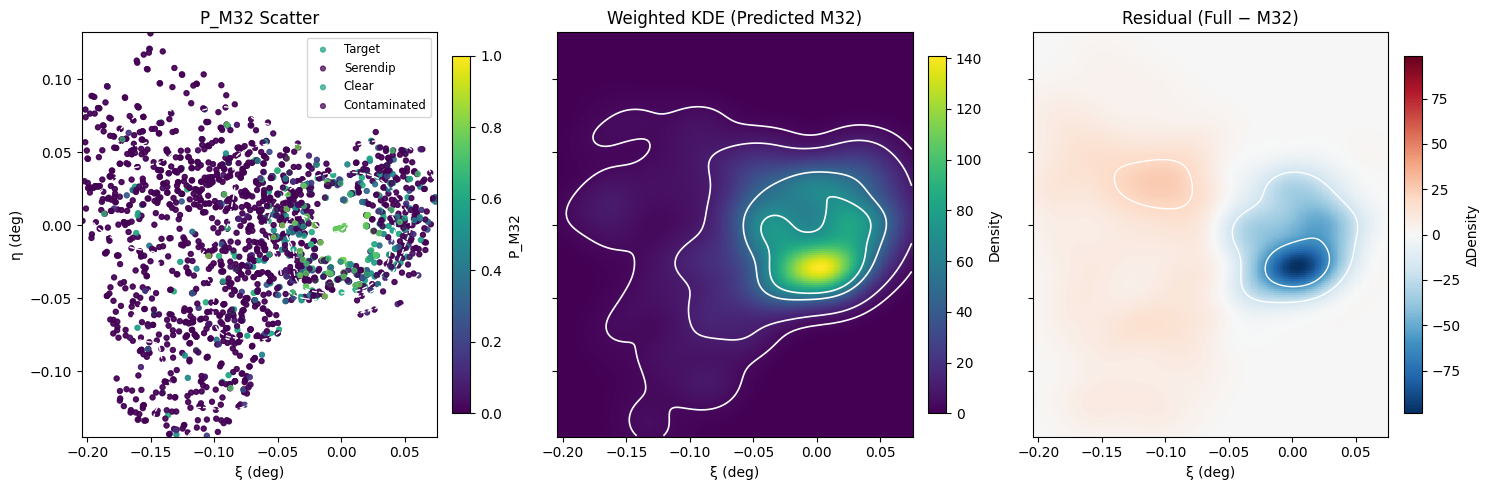

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ── CONFIGURE YOUR INPUT FILES ───────────────────────────────────────────────
catalog = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

# M32 center (deg)
RA0_deg, Dec0_deg = 10.67417, 40.86639

def compute_xi_eta(df):
    """
    Convert (RA, DEC) into tangential offsets (ξ, η) in degrees.
    """
    dRA  = (df['RA']  - RA0_deg) * np.cos(np.deg2rad(Dec0_deg))
    dDec =  df['DEC'] - Dec0_deg
    return dRA, dDec

# ── LOAD DATA & BUILD FULL SAMPLE KDE ────────────────────────────────────────
dfs = {name: pd.read_csv(path) for name, path in catalog.items()}
full_df = pd.concat(dfs.values(), ignore_index=True)
xi_full, eta_full = compute_xi_eta(full_df)

# Grid for KDE evaluation
ngrid = 200
xi_grid, eta_grid = np.meshgrid(
    np.linspace(xi_full.min(), xi_full.max(), ngrid),
    np.linspace(eta_full.min(), eta_full.max(), ngrid)
)
positions = np.vstack([xi_grid.ravel(), eta_grid.ravel()])

# KDEs: full sample (unweighted) and weighted (by P_M32)
full_kde     = gaussian_kde(np.vstack([xi_full, eta_full]))
full_density = full_kde(positions).reshape(ngrid, ngrid)

xi_all  = np.hstack([compute_xi_eta(df)[0] for df in dfs.values()])
eta_all = np.hstack([compute_xi_eta(df)[1] for df in dfs.values()])
w_all   = np.hstack([df['P_M32'].values       for df in dfs.values()])
kde_w   = gaussian_kde(np.vstack([xi_all, eta_all]), weights=w_all)
dens_w  = kde_w(positions).reshape(ngrid, ngrid)

# Residual
resid = full_density - dens_w
vmax  = np.abs(resid).max()

# ── PLOTTING ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Panel 1: scatter with contours
ax = axes[0]
for label, df in dfs.items():
    xi, eta = compute_xi_eta(df)
    ax.scatter(xi, eta,
               c=df['P_M32'], cmap='viridis', s=12, alpha=0.7,
               label=label, vmin=0, vmax=1)

contour_levels = np.percentile(dens_w, [50, 75, 90, 95])
ax.contour(xi_grid, eta_grid, dens_w, colors='white', linewidths=1, linestyles='--', levels=contour_levels)

ax.set_title("P_M32 Scatter")
ax.set_xlabel("ξ (deg)")
ax.set_ylabel("η (deg)")
ax.legend(fontsize='small')
cb = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax, fraction=0.046, pad=0.04)
cb.set_label("P_M32")

# Panel 2: KDE with contours
ax = axes[1]
pcm = ax.pcolormesh(xi_grid, eta_grid, dens_w, shading='auto', cmap='viridis')
ax.contour(xi_grid, eta_grid, dens_w, colors='white', linewidths=1.2, linestyles='solid', levels=contour_levels)

ax.set_title("Weighted KDE (Predicted M32)")
ax.set_xlabel("ξ (deg)")
cb = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("Density")

# Panel 3: residual with contours
ax = axes[2]
pcm = ax.pcolormesh(xi_grid, eta_grid, resid, shading='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
resid_levels = np.linspace(-vmax, vmax, 6)
ax.contour(xi_grid, eta_grid, resid, colors='white', linewidths=1, linestyles='solid', levels=resid_levels)

ax.set_title("Residual (Full − M32)")
ax.set_xlabel("ξ (deg)")
cb = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("ΔDensity")

plt.tight_layout()
plt.show()


Velocity Moments (mean, σ, skew, kurtosis):
  Inner :  ⟨v⟩ =  -199.0  σ=  28.0  skew=  0.23  kurt= -0.19
  Outer :  ⟨v⟩ =  -199.6  σ=  33.3  skew=  0.19  kurt= -0.66


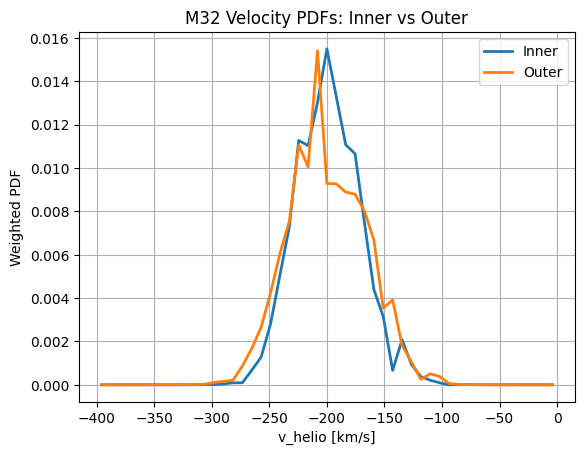


Linear Velocity Gradient Fits:
  Inner :  v0 =  -201.4 km/s,  k =  0.099 km/s per arcsec,  φ =  -74.2°


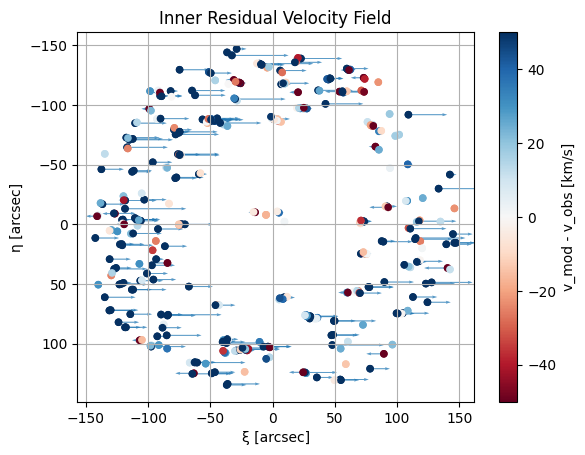

  Outer :  v0 =  -197.6 km/s,  k =  0.020 km/s per arcsec,  φ =  -31.2°


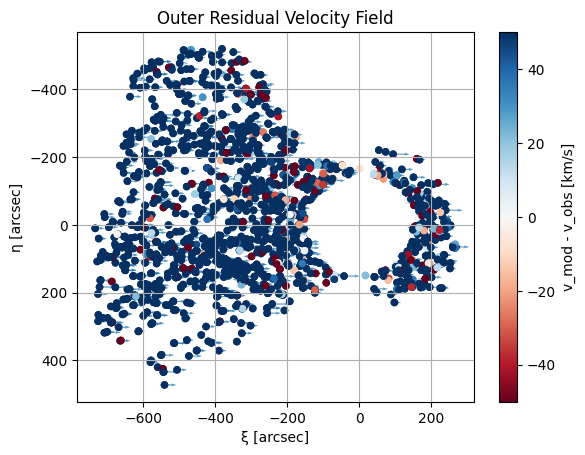

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize

# ── CONFIG ──────────────────────────────────────────────
files = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

# M32 center (deg)
RA0, Dec0 = 10.67417, 40.86639
R_iso_arcsec = 150.0

# ── UTILS ───────────────────────────────────────────────
def tangential_offsets(df):
    """Return xi, eta in arcsec relative to M32 center."""
    dra  = (df['RA']  - RA0) * np.cos(np.deg2rad(Dec0))
    ddec = df['DEC'] - Dec0
    # convert deg→arcsec
    return dra*3600, ddec*3600

def weighted_moments(v, w):
    """Return mean, std, skew, kurtosis of v with weights w."""
    mean = np.average(v, weights=w)
    var  = np.average((v-mean)**2, weights=w)
    std  = np.sqrt(var)
    # scipy skew/kurtosis want data unweighted; implement manually:
    # but here approximate by sampling
    # for large N this is okay
    skewness = skew(np.repeat(v, (w*1e3).astype(int)), bias=False)
    kurt = kurtosis(np.repeat(v, (w*1e3).astype(int)), fisher=True, bias=False)
    return mean, std, skewness, kurt

def fit_linear_gradient(xi, eta, v, w):
    """
    Fit v = v0 + k * ( xi*cos(φ) + eta*sin(φ) )
    Return best (v0, k, φ).
    """
    def model(params):
        v0, k, phi = params
        vmod = v0 + k*( xi*np.cos(phi) + eta*np.sin(phi) )
        return np.sum(w*(v-vmod)**2)

    # initial guess: v0 ~ mean(v), k~0, phi~0
    p0 = [np.average(v,weights=w), 0.0, 0.0]
    res = minimize(model, p0, method='Powell')
    return res.x  # v0, k, phi

# ── LOAD & CONCAT ───────────────────────────────────────
dfs = {name: pd.read_csv(fn) for name,fn in files.items()}
all_df = pd.concat(dfs.values(), ignore_index=True)

# compute xi, eta, radius
all_df['xi_arcsec'], all_df['eta_arcsec'] = tangential_offsets(all_df)
all_df['R_arcsec'] = np.sqrt(all_df['xi_arcsec']**2 + all_df['eta_arcsec']**2)

# only keep stars with P_M32 > 0 (already all should)
mask = all_df['P_M32'] > 0
df = all_df[mask].copy()

# split inner/outside
inner = df[df['R_arcsec'] <= R_iso_arcsec]
outer = df[df['R_arcsec'] >  R_iso_arcsec]

regions = {'Inner': inner, 'Outer': outer}

# ── 1) Velocity PDFs & 2) Moments ────────────────────────
print("Velocity Moments (mean, σ, skew, kurtosis):")
for name, sub in regions.items():
    v   = sub['v_helio'].values
    w   = sub['P_M32'].values
    mean, std, sk, kt = weighted_moments(v, w/np.sum(w))
    print(f"  {name:6s}:  ⟨v⟩ = {mean:7.1f}  σ={std:6.1f}  skew={sk:6.2f}  kurt={kt:6.2f}")

    # Plot PDF
    bins = np.linspace(-400,  0, 50)
    pdf, edges = np.histogram(v, bins=bins, weights=w, density=True)
    centers = 0.5*(edges[:-1]+edges[1:])
    plt.plot(centers, pdf, lw=2, label=name)

plt.xlabel("v_helio [km/s]")
plt.ylabel("Weighted PDF")
plt.legend()
plt.title("M32 Velocity PDFs: Inner vs Outer")
plt.grid(True)
plt.show()

# ── 3) Linear Velocity Gradient Fit ──────────────────────
print("\nLinear Velocity Gradient Fits:")
for name, sub in regions.items():
    xi = sub['xi_arcsec'].values
    eta= sub['eta_arcsec'].values
    v  = sub['v_helio'].values
    w  = sub['P_M32'].values / np.sum(sub['P_M32'].values)

    v0, k, phi = fit_linear_gradient(xi, eta, v, w)
    phi_deg    = np.rad2deg(phi)
    print(f"  {name:6s}:  v0 = {v0:7.1f} km/s,  k = {k:6.3f} km/s per arcsec,  φ = {phi_deg:6.1f}°")

    # Optional: plot residual velocities
    vmod = v0 + k*( xi*np.cos(phi) + eta*np.sin(phi) )
    plt.quiver(sub['xi_arcsec'], sub['eta_arcsec'],
               vmod - v, np.zeros_like(v),
               angles='xy', scale_units='xy', scale=1e1, color='C0', alpha=0.5)
    plt.scatter(sub['xi_arcsec'], sub['eta_arcsec'], c=vmod-v, cmap='RdBu', vmin=-50, vmax=50, s=20)
    plt.colorbar(label='v_mod - v_obs [km/s]')
    plt.title(f"{name} Residual Velocity Field")
    plt.xlabel("ξ [arcsec]")
    plt.ylabel("η [arcsec]")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()


Bootstrap σ and kurtosis:
Inner: σ=28.0(+0.7/-0.7), kurt=0.06(+0.19/-0.16)
Outer: σ=33.3(+0.4/-0.4), kurt=-0.21(+0.08/-0.07)


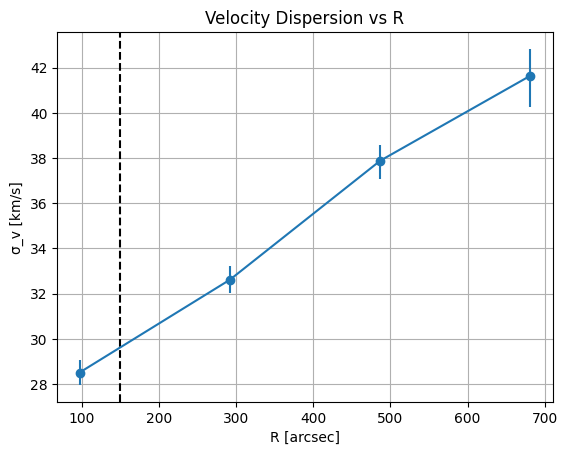

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [00:17<00:00, 114.47it/s]


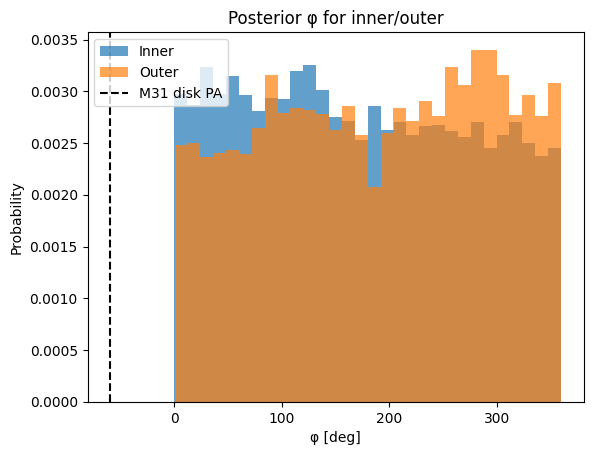

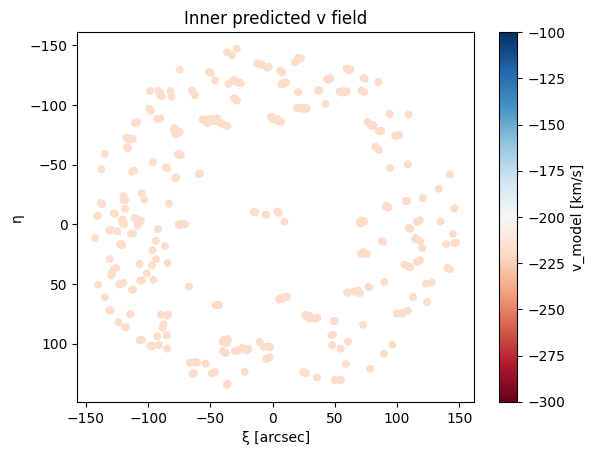

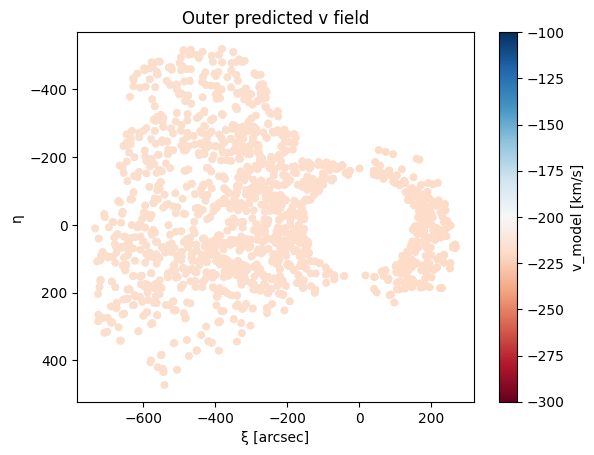

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import emcee

# ── CONFIG ──────────────────────────────────────────────
files = {
    'Clear':        "clear_PM32.csv",
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}
RA0, Dec0 = 10.67417, 40.86639
R_iso = 150.0  # arcsec
n_boot = 500   # bootstrap samples

# ── UTILITIES ───────────────────────────────────────────
def tangential_offsets(df):
    dra  = (df['RA']-RA0)*np.cos(np.deg2rad(Dec0))
    ddec = df['DEC']-Dec0
    return dra*3600, ddec*3600  # arcsec

def weighted_sigma(v, w):
    mu = np.average(v, weights=w)
    return np.sqrt(np.average((v-mu)**2, weights=w))

def bootstrap_moment(v, w, func, n_boot=500):
    N = len(v)
    vals = []
    # build a CDF for sampling
    w_norm = w/np.sum(w)
    for _ in range(n_boot):
        idx = np.random.choice(N, size=N, p=w_norm)
        vals.append(func(v[idx]))
    return np.percentile(vals, [16,50,84])

# linear gradient model
def lin_model(theta, xi, eta):
    v0, k, phi = theta
    return v0 + k*(xi*np.cos(phi) + eta*np.sin(phi))

def lnprob(theta, xi, eta, v, w):
    v0, k, phi = theta
    vmod = lin_model(theta, xi, eta)
    # assume scatter = weighted sigma of residuals
    res = v - vmod
    sigma = np.sqrt(np.average(res**2, weights=w))
    lnL  = -0.5*np.sum(w*((res/sigma)**2 + np.log(2*np.pi*sigma**2)))
    # flat priors: v0 in [-500,0], k in [-1,1], phi in [0,2π]
    if not (-500<v0<0 and -1<k<1 and 0<phi<2*np.pi): return -np.inf
    return lnL

# ── LOAD DATA ───────────────────────────────────────────
df = pd.concat([pd.read_csv(fn) for fn in files.values()], ignore_index=True)
df['xi'], df['eta'] = tangential_offsets(df)
df['R'] = np.hypot(df['xi'], df['eta'])
mask = df['P_M32']>0
df = df[mask].copy()

# split
regions = {
    'Inner': df[df['R']<=R_iso],
    'Outer': df[df['R']> R_iso]
}

# ── 1) Moments + Bootstrap ──────────────────────────────
print("Bootstrap σ and kurtosis:")
for name, sub in regions.items():
    v = sub['v_helio'].values
    w = sub['P_M32'].values
    # wk sigma
    sig = weighted_sigma(v,w)
    sig_lo, sig_med, sig_hi = bootstrap_moment(v,w, lambda x: np.std(x), n_boot)
    # weighted kurtosis (upsample)
    # approximate: bootstrap the kurtosis of repeated array
    def kurt_fn(arr): return kurtosis(arr, fisher=True, bias=False)
    kurt_lo, kurt_med, kurt_hi = bootstrap_moment(v, w, kurt_fn, n_boot)
    print(f"{name:5s}: σ={sig_med:.1f}(+{sig_hi-sig_med:.1f}/-{sig_med-sig_lo:.1f}), kurt={kurt_med:.2f}(+{kurt_hi-kurt_med:.2f}/-{kurt_med-kurt_lo:.2f})")

# ── 2) σ vs R profile ────────────────────────────────────
bins = np.linspace(0, df['R'].max(), 5)
centers = 0.5*(bins[:-1]+bins[1:])
sigmas = []
sig_err_lo = []; sig_err_hi = []
for i in range(len(bins)-1):
    sel = (df['R']>=bins[i])&(df['R']<bins[i+1])
    v = df.loc[sel,'v_helio'].values
    w = df.loc[sel,'P_M32'].values
    lo,med,hi = bootstrap_moment(v,w, lambda x: np.std(x), n_boot)
    sigmas.append(med)
    sig_err_lo.append(med-lo); sig_err_hi.append(hi-med)
plt.errorbar(centers, sigmas, yerr=[sig_err_lo,sig_err_hi], marker='o')
plt.axvline(R_iso,color='k',ls='--')
plt.xlabel("R [arcsec]"); plt.ylabel("σ_v [km/s]"); plt.title("Velocity Dispersion vs R")
plt.grid(True); plt.show()

# ── 3) MCMC fit of gradient + posterior φ plots ─────────
for name, sub in regions.items():
    xi = sub['xi'].values; eta = sub['eta'].values
    v  = sub['v_helio'].values; w = sub['P_M32'].values/np.sum(sub['P_M32'].values)

    ndim, nwalkers = 3, 50
    # initial around least-sq solution
    p0 = np.zeros(ndim)
    p0[0] = np.average(v,weights=w)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xi,eta,v,w))
    sampler.run_mcmc(p0 + 1e-3*np.random.randn(nwalkers,ndim), 2000, progress=True)
    samples = sampler.get_chain(discard=500, thin=10, flat=True)
    phi_samples = samples[:,2]
    phi_deg = np.rad2deg(phi_samples)

    # plot posterior φ
    plt.hist(phi_deg, bins=30, density=True, alpha=0.7, label=name)
# overlay M31 disk PA = -60°
plt.axvline(-60, color='k', ls='--', label="M31 disk PA")
plt.xlabel("φ [deg]"); plt.ylabel("Probability"); plt.legend(); plt.title("Posterior φ for inner/outer")
plt.show()

# ── 4) On-sky model velocity maps ────────────────────────
for name, sub in regions.items():
    xi= sub['xi'].values; eta=sub['eta'].values
    # use median of posterior
    phi_m = np.deg2rad(np.median(phi_deg))
    # reuse median v0,k from samples[:,:2]
    v0_m, k_m = np.median(samples[:,:2],axis=0)
    vmod = v0_m + k_m*( xi*np.cos(phi_m) + eta*np.sin(phi_m) )
    plt.scatter(xi, eta, c=vmod, cmap='RdBu', vmin=-300, vmax=-100, s=20)
    plt.colorbar(label="v_model [km/s]")
    plt.title(f"{name} predicted v field")
    plt.xlabel("ξ [arcsec]"); plt.ylabel("η")
    plt.gca().invert_yaxis(); plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import emcee

# ── CONFIG ──────────────────────────────────────────────
files = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}
RA0, Dec0 = 10.67417, 40.86639
R_iso = 150.0        # arcsec
n_boot = 500         # bootstrap draws for moments
n_phi_walkers = 50   # for MCMC on phi
n_phi_steps   = 2000

# ── UTILITIES ───────────────────────────────────────────
def tangential_offsets(df):
    dra  = (df['RA']-RA0)*np.cos(np.deg2rad(Dec0))
    ddec = df['DEC']-Dec0
    return dra*3600, ddec*3600

def weighted_moments(v, w):
    # normalize weights
    w = w/np.sum(w)
    mean = np.average(v, weights=w)
    var  = np.average((v-mean)**2, weights=w)
    std  = np.sqrt(var)
    # approximate skew/kurtosis by upsampling
    rep = np.repeat(v, (w*1e3).astype(int))
    return mean, std, skew(rep, bias=False), kurtosis(rep, fisher=True, bias=False)

def bootstrap_ci(v, w, func, n=n_boot):
    # returns (lo,med,hi) = 16/50/84 pctile of func() on bootstrap draws
    N = len(v)
    p = w/np.sum(w)
    vals = []
    for _ in range(n):
        idx = np.random.choice(N, size=N, p=p)
        vals.append(func(v[idx]))
    lo, med, hi = np.percentile(vals, [16,50,84])
    return lo, med, hi

def fit_ls_gradient(xi, eta, v, w):
    # least-sq fit of v = v0 + k*(xi cosφ + eta sinφ)
    def obj(p):
        v0,k,phi = p
        vmod = v0 + k*(xi*np.cos(phi)+eta*np.sin(phi))
        return np.sum(w*(v-vmod)**2)
    p0 = [np.average(v,weights=w), 0.0, 0.0]
    res = minimize(obj, p0, method='Powell')
    return res.x  # v0,k,phi

def lnphi(phi, v0, k, xi, eta, v, w):
    # log-posterior for phi alone, Gaussian noise sigma from data
    vmod = v0 + k*(xi*np.cos(phi)+eta*np.sin(phi))
    res = v-vmod
    sigma = np.sqrt(np.average(res**2, weights=w))
    lnL = -0.5*np.sum(w*((res/sigma)**2 + np.log(2*np.pi*sigma**2)))
    # flat prior on phi
    if not (0<=phi<2*np.pi): return -np.inf
    return lnL

# ── LOAD & PREP ─────────────────────────────────────────
df = pd.concat([pd.read_csv(fn) for fn in files.values()], ignore_index=True)
df['xi'], df['eta'] = tangential_offsets(df)
df['R'] = np.hypot(df['xi'], df['eta'])
df = df[df['P_M32']>0].copy()

# split
regions = {
    'Inner': df[df['R']<=R_iso],
    'Outer': df[df['R']>R_iso]
}

# ── 1) PRINT MOMENTS & BOOTSTRAP CIs ──────────────────────
print("=== Weighted Velocity Moments ===")
for name, sub in regions.items():
    v, w = sub['v_helio'].values, sub['P_M32'].values
    mean, std, sk, kt = weighted_moments(v,w)
    std_lo,std_med,std_hi = bootstrap_ci(v,w, lambda x: np.std(x))
    kt_lo, kt_med, kt_hi = bootstrap_ci(v,w, lambda x: kurtosis(x, fisher=True, bias=False))
    print(f"{name:6s}: ⟨v⟩={mean:6.1f}, σ={std_med:5.1f} (+{std_hi-std_med:4.1f}/-{std_med-std_lo:4.1f}), "
          f"kurt={kt_med:5.2f} (+{kt_hi-kt_med:5.2f}/-{kt_med-kt_lo:5.2f})")

# ── 2) PRINT σ vs R PROFILE ───────────────────────────────
print("\n=== Velocity Dispersion vs Radius ===")
bins = np.linspace(0, df['R'].max(), 5)
centers = 0.5*(bins[:-1]+bins[1:])
for i in range(len(centers)):
    sel = df['R'].between(bins[i], bins[i+1], inclusive='left')
    v, w = df.loc[sel,'v_helio'].values, df.loc[sel,'P_M32'].values
    lo,med,hi = bootstrap_ci(v,w, lambda x: np.std(x))
    print(f"R={centers[i]:6.1f}'' : σ={med:5.1f} (+{hi-med:4.1f}/-{med-lo:4.1f})")

# ── 3) LEAST‐SQUARES FIT & PRINT ──────────────────────────
print("\n=== LS Gradient Fit ===")
ls_params = {}
for name, sub in regions.items():
    xi,eta,v,w = sub['xi'].values, sub['eta'].values, sub['v_helio'].values, sub['P_M32'].values/np.sum(sub['P_M32'].values)
    v0,k,phi = fit_ls_gradient(xi,eta,v,w)
    phi_deg = np.rad2deg(phi)
    ls_params[name] = (v0,k,phi)
    print(f"{name:6s}: v0={v0:6.1f}, k={k:6.3f}, φ={phi_deg:6.1f}°")

# ── 4) MCMC ON φ & PRINT POSTERIOR CI ────────────────────
print("\n=== MCMC φ Posterior (50,16,84 pctiles) ===")
np.random.seed(0)
for name, sub in regions.items():
    xi,eta,v,w = sub['xi'].values, sub['eta'].values, sub['v_helio'].values, sub['P_M32'].values/np.sum(sub['P_M32'].values)
    v0,k,_ = ls_params[name]
    # Initialize walkers
    ndim, nwalkers = 1, n_phi_walkers
    p0 = np.random.rand(nwalkers,ndim)*2*np.pi
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnphi, args=(v0,k,xi,eta,v,w))
    sampler.run_mcmc(p0, n_phi_steps, progress=False)
    chain = sampler.get_chain(discard=n_phi_steps//2, flat=True)
    phis = np.rad2deg(chain[:,0]) % 360
    lo,med,hi = np.percentile(phis, [16,50,84])
    print(f"{name:6s}: φ = {med:6.1f}° (+{hi-med:6.1f}/-{med-lo:6.1f})")



=== Weighted Velocity Moments ===
Inner : ⟨v⟩=-199.0, σ= 27.9 (+ 0.8/- 0.8), kurt= 0.06 (+ 0.20/- 0.15)
Outer : ⟨v⟩=-199.6, σ= 33.2 (+ 0.4/- 0.4), kurt=-0.21 (+ 0.08/- 0.08)

=== Velocity Dispersion vs Radius ===
R=  97.4'' : σ= 28.5 (+ 0.5/- 0.6)
R= 292.1'' : σ= 32.6 (+ 0.6/- 0.7)
R= 486.8'' : σ= 37.8 (+ 0.9/- 0.7)
R= 681.6'' : σ= 41.5 (+ 1.4/- 1.2)

=== LS Gradient Fit ===
Inner : v0=-201.4, k= 0.099, φ= -74.2°
Outer : v0=-197.6, k= 0.020, φ= -31.2°

=== MCMC φ Posterior (50,16,84 pctiles) ===
Inner : φ =  188.7° (+ 118.0/- 130.3)
Outer : φ =  176.6° (+ 124.0/- 120.9)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee

# ── CONFIG ──────────────────────────────────────────────
files = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}
RA0, Dec0 = 10.67417, 40.86639
R_iso = 150.0  # arcsec
nwalkers = 100
nsteps   = 3000
burnin   = 1000

# ── UTILITIES ───────────────────────────────────────────
def tangential_offsets(df):
    dra  = (df['RA']-RA0)*np.cos(np.deg2rad(Dec0))
    ddec = df['DEC']-Dec0
    return dra*3600, ddec*3600

def lnprior(theta):
    v0, k, phi = theta
    # broad flat priors
    if not (-300 < v0 < -100): return -np.inf
    if not (0 <= k < 0.5): return -np.inf
    if not (0 <= phi < 2*np.pi): return -np.inf
    return 0.0

def lnlike(theta, xi, eta, v, w):
    v0, k, phi = theta
    vmod = v0 + k*(xi*np.cos(phi) + eta*np.sin(phi))
    res  = v - vmod
    # weighted Gaussian with inflation to match variance
    sigma2 = np.average(res**2, weights=w)
    return -0.5*np.sum(w*(res**2/sigma2 + np.log(2*np.pi*sigma2)))

def lnprob(theta, xi, eta, v, w):
    lp = lnprior(theta)
    if lp == -np.inf: return lp
    return lp + lnlike(theta, xi, eta, v, w)

# ── LOAD & PREP ─────────────────────────────────────────
df = pd.concat([pd.read_csv(fn) for fn in files.values()], ignore_index=True)
df['xi'], df['eta'] = tangential_offsets(df)
df['R'] = np.hypot(df['xi'], df['eta'])
df = df[df['P_M32']>0].copy()

regions = {
    'Inner': df[df['R']<=R_iso],
    'Outer': df[df['R']> R_iso]
}

# ── LS INITIALIZATION ───────────────────────────────────
def fit_ls(xi, eta, v, w):
    def obj(p):
        v0,k,phi = p
        vmod = v0 + k*(xi*np.cos(phi)+eta*np.sin(phi))
        return np.sum(w*(v-vmod)**2)
    p0 = [np.average(v,weights=w), 0.1, 0.0]
    res = minimize(obj, p0, method='Powell')
    return res.x

# ── RUN MCMC & PRINT RESULTS ────────────────────────────
for name, sub in regions.items():
    xi = sub['xi'].values
    eta= sub['eta'].values
    v  = sub['v_helio'].values
    w  = sub['P_M32'].values; w /= w.sum()

    # LS fit for initialization
    v0_ls, k_ls, phi_ls = fit_ls(xi,eta,v,w)

    # Initialize walkers in a small ball around LS
    ndim = 3
    p0 = np.vstack([
        v0_ls + 1e-1*np.random.randn(nwalkers),
        k_ls   + 1e-2*np.random.randn(nwalkers),
        phi_ls + 1e-1*np.random.randn(nwalkers)
    ]).T

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xi,eta,v,w))
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.get_chain(discard=burnin, flat=True)

    # Percentiles
    for i, label in enumerate(['v0 (km/s)', 'k (km/s/″)', 'φ (deg)']):
        vals = samples[:, i]
        if label.startswith('φ'):
            vals = np.rad2deg(vals) % 360
        lo, med, hi = np.percentile(vals, [16,50,84])
        print(f"{name:6s} {label:10s}: {med:8.2f} (+{hi-med:6.2f}/-{med-lo:6.2f})")
    print()



  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:09<00:00, 303.99it/s]


Inner  v0 (km/s) :  -201.37 (+  0.09/-  0.12)
Inner  k (km/s/″):     0.10 (+  0.01/-  0.01)
Inner  φ (deg)   :   284.97 (+  5.33/-  4.90)



100%|██████████| 3000/3000 [00:21<00:00, 138.27it/s]

Outer  v0 (km/s) :  -198.04 (+ 57.55/- 60.51)
Outer  k (km/s/″):     0.20 (+  0.19/-  0.14)
Outer  φ (deg)   :   180.09 (+123.85/-120.96)



In [ ]:
import numpy as np
import pandas as pd
import emcee
from scipy.stats import norm
import os

# --- CONFIG ---
RA0, Dec0 = 10.67417, 40.86639
D_kpc = 776.2
ARCSEC_TO_RAD = np.pi / 180 / 3600
SPLIT_RADIUS_ARCSEC = 150.0

nwalkers, nsteps, burnin = 100, 4000, 1000

files = {
    "Clear":       "clear_PM32.csv",
    "Target":      "target_PM32.csv",
    "Serendip":    "serendip_PM32.csv",
    "Contaminated":"contam_PM32.csv"
}

regions = ['inner', 'outer', 'full']

# --- LOG PROBABILITY FUNCTIONS ---
def log_prior(params):
    V0, kR, phi = params
    if not (-300 < V0 < -100): return -np.inf
    if not (-30  < kR <  30):  return -np.inf
    if not (0 <= phi < 2*np.pi): return -np.inf
    return 0

def log_likelihood(params, theta, v, err, w):
    V0, kR, phi = params
    v_mod = V0 + kR * np.cos(theta - phi)
    return np.sum(w * norm.logpdf(v, loc=v_mod, scale=err))

def log_posterior(params, theta, v, err, w):
    lp = log_prior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + log_likelihood(params, theta, v, err, w)

# --- MAIN FITTING FUNCTION ---
def fit_uniform_rotation(df, region_name):
    dra  = (df['RA'] - RA0) * np.cos(np.deg2rad(Dec0))
    ddec =  df['DEC'] - Dec0
    df['xi_kpc']  = dra  * ARCSEC_TO_RAD * D_kpc
    df['eta_kpc'] = ddec * ARCSEC_TO_RAD * D_kpc
    df['theta_rad'] = np.arctan2(df['eta_kpc'], df['xi_kpc'])
    df['R_arcsec'] = np.hypot(dra*3600, ddec*3600)

    if region_name == 'inner':
        df = df[df['R_arcsec'] <= SPLIT_RADIUS_ARCSEC]
    elif region_name == 'outer':
        df = df[df['R_arcsec'] > SPLIT_RADIUS_ARCSEC]
    elif region_name != 'full':
        raise ValueError("Region must be one of: 'inner', 'outer', 'full'")

    if len(df) < 10:
        return None

    df = df[df['P_M32'] > 0].copy()
    theta = df['theta_rad'].values
    v     = df['v_helio'].values
    err   = df['VEL_ERR_FINAL'].values if 'VEL_ERR_FINAL' in df else np.full_like(v, 5.0)
    w     = df['P_M32'].values
    w    /= w.sum()

    ndim = 3
    init = np.array([-200.0, 0.0, 0.0])
    p0 = init + 1e-2 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(theta, v, err, w))
    sampler.run_mcmc(p0, nsteps, progress=False)
    samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

    def quantiles(x): return np.percentile(x, [16, 50, 84])
    V0_lo, V0_med, V0_hi = quantiles(samples[:, 0])
    kR_lo, kR_med, kR_hi = quantiles(samples[:, 1])
    phi_lo, phi_med, phi_hi = quantiles(np.rad2deg(samples[:, 2]) % 360)

    return {
        'V0':  (V0_med, V0_hi - V0_med, V0_med - V0_lo),
        'kR':  (kR_med, kR_hi - kR_med, kR_med - kR_lo),
        'phi': (phi_med, phi_hi - phi_med, phi_med - phi_lo)
    }

# --- RUN AND PRINT FORMATTED OUTPUT ---
for label, fname in files.items():
    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        continue

    df = pd.read_csv(fname)
    print(f"\n====== {label.upper()} Sample ======")

    for region in regions:
        result = fit_uniform_rotation(df.copy(), region)
        if result is None:
            continue

        V0, V0p, V0m = result['V0']
        kR, kRp, kRm = result['kR']
        phi, phip, phim = result['phi']

        print(f"  --- {region.title()} ---")
        print(f"  V0  = {V0:7.2f} (+{V0p:.2f}/-{V0m:.2f}) km/s")
        print(f"  kR  = {kR:7.2f} (+{kRp:.2f}/-{kRm:.2f}) km/s")
        print(f"  phi = {phi:7.2f} (+{phip:.2f}/-{phim:.2f}) deg")



====== CLEAR Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -203.13 (+2.77/-2.77) km/s
  kR  =   -2.72 (+14.23/-9.26) km/s
  phi =  137.37 (+150.02/-50.40) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -200.60 (+2.91/-2.93) km/s
  kR  =   -0.02 (+5.03/-4.97) km/s
  phi =  177.50 (+124.86/-119.68) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -201.42 (+2.79/-2.84) km/s
  kR  =   -0.09 (+5.79/-5.77) km/s
  phi =  175.68 (+129.75/-95.78) deg

====== TARGET Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -204.65 (+2.75/-2.77) km/s
  kR  =   -6.08 (+20.11/-8.77) km/s
  phi =  131.09 (+160.29/-35.66) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -200.85 (+2.83/-2.81) km/s
  kR  =   -0.08 (+4.84/-4.93) km/s
  phi =  179.65 (+115.39/-115.77) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -201.95 (+2.81/-2.81) km/s
  kR  =    0.07 (+4.88/-4.81) km/s
  phi =  186.60 (+120.51/-112.18) deg

====== SERENDIP Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -198.60 (+3.09/-3.10) km/s
  kR  =    0.94 (+9.58/-11.12) km/s
  phi =  204.11 (+77.86/-131.85) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -194.20 (+3.73/-3.71) km/s
  kR  =   -7.35 (+22.83/-8.97) km/s
  phi =  157.76 (+158.35/-40.31) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -198.15 (+3.07/-3.06) km/s
  kR  =   -0.14 (+11.36/-10.80) km/s
  phi =  177.75 (+117.15/-88.48) deg

====== CONTAMINATED Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -199.59 (+3.17/-3.28) km/s
  kR  =   -0.64 (+11.83/-10.76) km/s
  phi =  163.54 (+131.77/-76.38) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -200.42 (+3.39/-3.39) km/s
  kR  =    0.04 (+8.36/-8.58) km/s
  phi =  180.32 (+116.51/-100.47) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -199.84 (+3.21/-3.22) km/s
  kR  =   -0.25 (+10.95/-10.57) km/s
  phi =  170.60 (+124.92/-82.91) deg


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import emcee

# --- CONFIG ---
files = {
    "Clear":        "clear_PM32.csv",
    "Target":       "target_PM32.csv",
    "Serendip":     "serendip_PM32.csv",
    "Contaminated": "contam_PM32.csv"
}

RA0, Dec0 = 10.67417, 40.86639    # M32 center [deg]
D_kpc = 776.2                     # Distance to M31
n_annuli = 10                     # # radial bins

# --- UTILS ---
def tangential_offsets(df):
    dra  = (df.RA  - RA0)*np.cos(np.deg2rad(Dec0))
    ddec =  df.DEC - Dec0
    xi, eta = dra*3600, ddec*3600  # arcsec
    theta = np.arctan2(eta, xi)    # rad
    R = np.hypot(xi, eta) / 3600 * D_kpc  # kpc
    return R, theta

def bootstrap_mean(v, w, nboot=500):
    w0 = w/np.sum(w)
    means = []
    for _ in range(nboot):
        idx = np.random.choice(len(v), p=w0, size=len(v))
        means.append(np.average(v[idx], weights=w[idx]))
    return np.percentile(means, [16,50,84])

def arctan_model(theta, R):
    V0, Vmax, rt, phi = theta
    return V0 + (2*Vmax/np.pi)*np.arctan(R/rt)*np.cos(phi)

def lnprob(theta, R, v_obs, v_err):
    V0, Vmax, rt, phi = theta
    if not (-300< V0 < -100):     return -np.inf
    if not (0< Vmax < 50):        return -np.inf
    if not (0< rt   <   5):        return -np.inf
    if not (0<= phi < 2*np.pi):    return -np.inf
    vmod = arctan_model(theta, R)
    chi2 = ((v_obs-vmod)/v_err)**2 + np.log(2*np.pi*v_err**2)
    return -0.5*np.nansum(chi2)

# --- LOOP OVER FILES ---
for label, file in files.items():
    print(f"\n====== {label.upper()} Sample ======")

    df = pd.read_csv(file)
    df = df[df.P_M32 > 0]

    R, theta = tangential_offsets(df)
    v = df.v_helio.values
    w = df.P_M32.values

    # Bin into annuli
    bins = np.linspace(R.min(), R.max(), n_annuli+1)
    R_centers = 0.5*(bins[:-1]+bins[1:])
    v_means = np.zeros(n_annuli)
    v_errs  = np.zeros(n_annuli)

    for i in range(n_annuli):
        sel = (R >= bins[i]) & (R < bins[i+1])
        if sel.sum() > 5:
            v_means[i] = np.average(v[sel], weights=w[sel])
            lo, med, hi = bootstrap_mean(v[sel], w[sel])
            v_errs[i] = 0.5 * (hi - lo)
        else:
            v_means[i], v_errs[i] = np.nan, np.nan

    valid = ~np.isnan(v_means)

    # --- MCMC ---
    nwalkers, ndim = 50, 4
    p0 = [-200, 10, 1.0, 0.0] + 1e-3*np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(R_centers[valid], v_means[valid], v_errs[valid]))
    sampler.run_mcmc(p0, 2000, progress=False)

    samples = sampler.get_chain(discard=500, thin=5, flat=True)

    # --- REPORT ---
    names = ["V0", "Vmax", "r_t", "φ"]
    units = ["km/s", "km/s", "kpc", "deg"]
    for i, name in enumerate(names):
        lo, med, hi = np.percentile(samples[:,i], [16,50,84])
        if name == "φ":
            med, lo, hi = np.rad2deg(med), np.rad2deg(lo), np.rad2deg(hi)
        print(f"  {name:4s} = {med:7.2f} (+{hi - med:.2f}/-{med - lo:.2f}) {units[i]}")

    # Optional: corner plot
    # import corner
    # corner.corner(samples, labels=names)
    # plt.show()



====== CLEAR Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  V0   = -161.94 (+3.50/-6.13) km/s
  Vmax =   46.89 (+2.30/-5.51) km/s
  r_t  =    4.65 (+0.26/-0.56) kpc
  φ    =  178.93 (+19.19/-18.72) deg

====== TARGET Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  V0   = -246.69 (+0.22/-0.31) km/s
  Vmax =   49.92 (+0.06/-0.19) km/s
  r_t  =    4.99 (+0.01/-0.02) kpc
  φ    =  180.38 (+3.45/-2.71) deg

====== SERENDIP Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  V0   = -233.83 (+3.67/-2.04) km/s
  Vmax =   48.11 (+1.39/-3.26) km/s
  r_t  =    4.80 (+0.15/-0.33) kpc
  φ    =    9.53 (+10.50/-6.57) deg

====== CONTAMINATED Sample ======


/tmp/ipython-input-343222464.py:47: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((v_obs-vmod)/v_err)**2 + np.log(2*np.pi*v_err**2)
/tmp/ipython-input-343222464.py:47: RuntimeWarning: divide by zero encountered in log
  chi2 = ((v_obs-vmod)/v_err)**2 + np.log(2*np.pi*v_err**2)
/tmp/ipython-input-343222464.py:47: RuntimeWarning: invalid value encountered in add
  chi2 = ((v_obs-vmod)/v_err)**2 + np.log(2*np.pi*v_err**2)
/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  V0   = -172.80 (+0.01/-0.02) km/s
  Vmax =   49.99 (+0.01/-0.02) km/s
  r_t  =    5.00 (+0.00/-0.00) kpc
  φ    =  179.86 (+0.76/-1.02) deg


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
from scipy.stats import norm

# --- CONFIG -------------------------------------------------
files = {
    "Clear":        "clear_PM32.csv",
    "Target":       "target_PM32.csv",
    "Serendip":     "serendip_PM32.csv",
    "Contaminated": "contam_PM32.csv"
}

RA0, Dec0 = 10.67417, 40.86639  # M32 center (deg)
D_kpc = 776.2
arcsec_to_rad = np.pi / 180 / 3600
nwalkers, nsteps, burnin = 100, 5000, 1000

# ----------------------------------------------------------------
def process_dataset(name, df):
    print(f"\n====== {name.upper()} Sample ======")

    df = df[df['P_M32'] > 0].copy()

    dra  = (df['RA']  - RA0)*np.cos(np.deg2rad(Dec0))
    ddec =  df['DEC'] - Dec0
    xi_arcsec  = dra  * 3600
    eta_arcsec = ddec * 3600

    df['xi_kpc']  = xi_arcsec  * arcsec_to_rad * D_kpc
    df['eta_kpc'] = eta_arcsec * arcsec_to_rad * D_kpc
    df['R_kpc']     = np.hypot(df['xi_kpc'], df['eta_kpc'])
    df['theta_rad'] = np.arctan2(df['eta_kpc'], df['xi_kpc'])

    # per-star velocity error
    if 'VEL_ERR_FINAL' in df:
        df['sigma_v'] = df['VEL_ERR_FINAL']
    else:
        df['sigma_v'] = 5.0

    R_kpc   = df['R_kpc'].values
    theta   = df['theta_rad'].values
    v_helio = df['v_helio'].values
    sigma_v = df['sigma_v'].values
    weights = df['P_M32'].values
    weights /= weights.sum()

    # ----------------------------------------------------------------
    def log_prior(theta):
        V0, Vmax, rt, phi = theta
        if not (-300 < V0 < -100): return -np.inf
        if not (0 < Vmax < 50): return -np.inf
        if not (0 < rt < 5): return -np.inf
        if not (0 <= phi < 2*np.pi): return -np.inf
        return 0.0

    def log_likelihood(theta, R, th, v, sig, w):
        V0, Vmax, rt, phi = theta
        vmod = V0 + (2*Vmax/np.pi)*np.arctan(R/rt)*np.cos(th - phi)
        return np.sum(w * norm.logpdf(v, loc=vmod, scale=sig))

    def log_posterior(theta, R, th, v, sig, w):
        lp = log_prior(theta)
        if lp == -np.inf:
            return -np.inf
        return lp + log_likelihood(theta, R, th, v, sig, w)

    # ----------------------------------------------------------------
    # Initialize & Run EMCEE
    p0_center = np.array([-200, 10, 0.5, 0.0])
    p0 = p0_center + 1e-2 * np.random.randn(nwalkers, 4)

    sampler = emcee.EnsembleSampler(
        nwalkers, 4,
        log_posterior,
        args=(R_kpc, theta, v_helio, sigma_v, weights)
    )
    sampler.run_mcmc(p0, nsteps, progress=True)

    # ----------------------------------------------------------------
    flat = sampler.get_chain(discard=burnin, thin=10, flat=True)
    def pctiles(a): return np.percentile(a, [16, 50, 84])
    V0_q, Vmax_q, rt_q, phi_q = map(pctiles, flat.T)

    # Print results
    print("=== Posterior (16/50/84) ===")
    print(f"V0   = {V0_q[1]:7.2f} (+{V0_q[2]-V0_q[1]:.2f}/-{V0_q[1]-V0_q[0]:.2f}) km/s")
    print(f"Vmax = {Vmax_q[1]:7.2f} (+{Vmax_q[2]-Vmax_q[1]:.2f}/-{Vmax_q[1]-Vmax_q[0]:.2f}) km/s")
    print(f"rt   = {rt_q[1]:7.2f} (+{rt_q[2]-rt_q[1]:.2f}/-{rt_q[1]-rt_q[0]:.2f}) kpc")
    print(f"phi  = {np.rad2deg(phi_q[1]):7.1f}° (+{np.rad2deg(phi_q[2]-phi_q[1]):6.1f}/-{np.rad2deg(phi_q[1]-phi_q[0]):6.1f})°")

# ----------------------------------------------------------------
# MAIN LOOP
# ----------------------------------------------------------------
for name, path in files.items():
    df = pd.read_csv(path)
    process_dataset(name, df)



====== CLEAR Sample ======


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [01:28<00:00, 56.30it/s]


=== Posterior (16/50/84) ===
V0   = -200.96 (+2.79/-2.89) km/s
Vmax =   15.81 (+17.88/-11.25) km/s
rt   =    3.26 (+1.22/-1.66) kpc
phi  =   250.4° (+  76.6/- 204.6)°

====== TARGET Sample ======


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [01:16<00:00, 65.75it/s]


=== Posterior (16/50/84) ===
V0   = -201.60 (+2.87/-2.82) km/s
Vmax =   13.89 (+17.22/-9.99) km/s
rt   =    3.32 (+1.18/-1.68) kpc
phi  =   187.3° (+ 131.7/- 141.5)°

====== SERENDIP Sample ======


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:58<00:00, 85.20it/s]


=== Posterior (16/50/84) ===
V0   = -196.93 (+3.06/-3.12) km/s
Vmax =   26.01 (+15.82/-15.99) km/s
rt   =    2.32 (+1.76/-1.42) kpc
phi  =   284.1° (+  35.1/-  64.2)°

====== CONTAMINATED Sample ======


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:55<00:00, 90.78it/s]

=== Posterior (16/50/84) ===
V0   = -198.46 (+3.05/-3.13) km/s
Vmax =   26.47 (+15.96/-16.90) km/s
rt   =    2.41 (+1.71/-1.46) kpc
phi  =   283.5° (+  38.3/-  85.4)°


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee

# ── CONFIG ──────────────────────────────────────────────────────────────────
files = {
    'Target':       "target_PM32.csv",
    'Serendip':     "serendip_PM32.csv",
    'Clear':        "clear_PM32.csv",
    'Contaminated': "contam_PM32.csv"
}

RA0, Dec0     = 10.67417, 40.86639   # M32 center [deg]
D_kpc         = 776.2                # distance to M32 [kpc]
as_to_rad     = np.pi/180/3600       # arcsec → radians
R_iso_as      = 150.0                # isophotal radius [arcsec]
v_sys         = -200.0               # systemic velocity [km/s]

# MCMC settings
nwalkers, nsteps, burnin = 60, 2000, 500

# ── LOAD & PREPARE THE DATA ─────────────────────────────────────────────────
# concatenate all four catalogs
df = pd.concat([pd.read_csv(path) for path in files.values()], ignore_index=True)
# keep only nonzero P_M32
df = df[df['P_M32'] > 0].copy()

# compute tangential offsets in kpc
cosd = np.cos(np.deg2rad(Dec0))
df['xi_kpc']  = (df['RA']  - RA0) * cosd * 3600 * as_to_rad * D_kpc
df['eta_kpc'] = (df['DEC'] - Dec0) * 3600 * as_to_rad * D_kpc

# compute projected radius in arcsec for the split
df['R_as'] = np.hypot((df['RA'] - RA0)*cosd*3600,
                      (df['DEC']- Dec0)*3600)

# shift velocities by systemic
df['v'] = df['v_helio'] - v_sys

# split into Inner / Outer
regions = {
    'Inner': df[df['R_as'] <= R_iso_as],
    'Outer': df[df['R_as']  > R_iso_as]
}

# ── MODEL, PRIORS & LIKELIHOOD ───────────────────────────────────────────────
def log_prior(theta):
    """Flat priors: k_R ∈ [0, 30] km/s/kpc, θ ∈ [0,2π)."""
    k, phi = theta
    if not (0.0 <= k <= 30.0):      return -np.inf
    if not (0.0 <= phi < 2*np.pi):  return -np.inf
    return 0.0

def log_likelihood(theta, xi, eta, v, w):
    """Weighted Gaussian log‐likelihood with fixed unit dispersion."""
    k, phi = theta
    # uniform rotation model (Eq.12):
    #   v_mod = k * (ξ cosφ + η sinφ)
    v_mod = k * (xi*np.cos(phi) + eta*np.sin(phi))
    # assume σ=1 km/s for shape; weights w_i = P_M32_i
    resid = v - v_mod
    return np.sum(w * (-0.5*(resid**2) - 0.5*np.log(2*np.pi)))

def log_posterior(theta, xi, eta, v, w):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, xi, eta, v, w)

# ── RUN MCMC FOR EACH REGION ────────────────────────────────────────────────
results = {}
for name, sub in regions.items():
    xi  = sub['xi_kpc'].values
    eta = sub['eta_kpc'].values
    v   = sub['v'].values
    w   = sub['P_M32'].values
    w  /= w.sum()    # normalize weights

    # initialize walkers in a small ball around k~10, φ~π/2
    p0 = np.zeros((nwalkers, 2))
    p0[:,0] = 10.0 + 1.0*np.random.randn(nwalkers)     # k guess
    p0[:,1] = np.pi/2 + 0.1*np.random.randn(nwalkers)  # φ guess

    sampler = emcee.EnsembleSampler(
        nwalkers, 2, log_posterior,
        args=(xi, eta, v, w)
    )
    sampler.run_mcmc(p0, nsteps, progress=True)

    # discard burnin & flatten
    flat = sampler.get_chain(discard=burnin, thin=10, flat=True)

    # compute 16/50/84 percentiles
    def pct(vals):
        return np.percentile(vals, [16,50,84])

    k_q, phi_q = pct(flat[:,0]), pct(flat[:,1])

    results[name] = {
        'k':   (k_q[1], k_q[2]-k_q[1], k_q[1]-k_q[0]),
        'phi': (np.rad2deg(phi_q[1]), *np.rad2deg([phi_q[2]-phi_q[1], phi_q[1]-phi_q[0]]))
    }

# ── PRINT THE FINAL RESULTS ─────────────────────────────────────────────────
for name, vals in results.items():
    k, dkp, dkm = vals['k']
    phi, dpp, dpm = vals['phi']
    print(f"{name:6s} Region:")
    print(f"  k_R   = {k:.2f} +{dkp:.2f}/-{dkm:.2f} km/s/kpc")
    print(f"  θ_R   = {phi:.1f}° +{dpp:.1f}/-{dpm:.1f}°\n")

100%|██████████| 2000/2000 [00:08<00:00, 237.05it/s]

Inner  Region:
  k_R   = 21.70 +4.89/-17.19 km/s/kpc
  θ_R   = 279.0° +12.7/-276.6°

Outer  Region:
  k_R   = 2.63 +1.44/-1.21 km/s/kpc
  θ_R   = 19.6° +290.3/-15.2°



  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 4000/4000 [01:04<00:00, 62.27it/s]



=== Flat Rotation Fit (Inner Region) ===
V0   = -203.07 (+2.74/-2.78)  km/s
kR   =    1.98 (+9.72/-13.55)  km/s
phi  =  143.80 (+144.72/-57.36)  deg


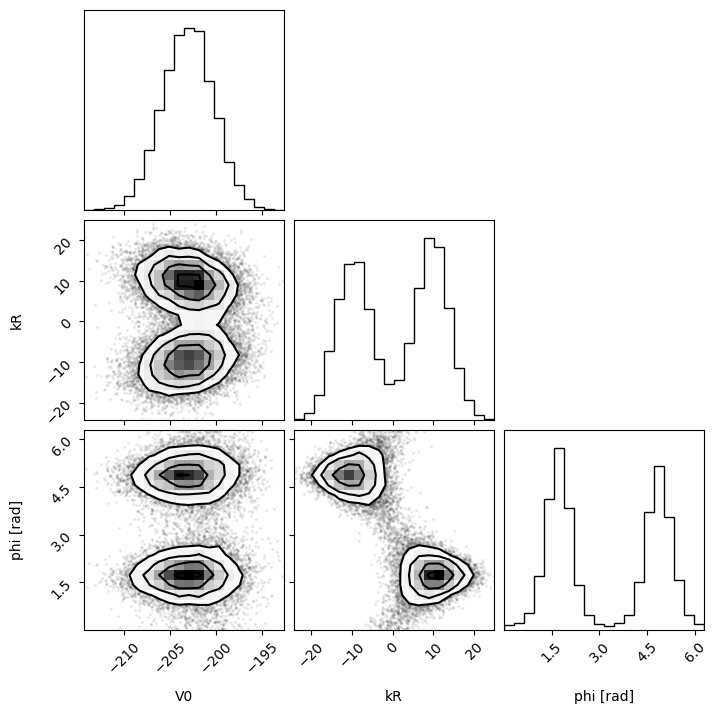

In [ ]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- CONFIG ----------------------------------------------------
FNAME = "clear_PM32.csv"  # or "target_PM32.csv", etc
RA0, Dec0 = 10.67417, 40.86639
D_kpc = 776.2
ARCSEC_TO_RAD = np.pi / 180 / 3600

split_radius_arcsec = 150.0
region_choice = 'inner'  # 'outer' or 'full'
nwalkers, nsteps, burnin = 100, 4000, 1000

# --- LOAD & PROCESS ---------------------------------------------
df = pd.read_csv(FNAME)
df = df[df['P_M32'] > 0].copy()

# Tangential offsets → (xi, eta) in kpc
dra  = (df['RA'] - RA0) * np.cos(np.deg2rad(Dec0))
ddec =  df['DEC'] - Dec0
df['xi_kpc']  = dra  * ARCSEC_TO_RAD * D_kpc
df['eta_kpc'] = ddec * ARCSEC_TO_RAD * D_kpc

df['R_arcsec'] = np.hypot(dra*3600, ddec*3600)
df['theta_rad'] = np.arctan2(df['eta_kpc'], df['xi_kpc'])

# Use VEL_ERR_FINAL or fallback
if 'VEL_ERR_FINAL' in df:
    df['v_err'] = df['VEL_ERR_FINAL']
else:
    df['v_err'] = 5.0

# Select region
if region_choice == 'inner':
    df = df[df['R_arcsec'] <= split_radius_arcsec].copy()
elif region_choice == 'outer':
    df = df[df['R_arcsec'] > split_radius_arcsec].copy()

# Extract arrays
theta = df['theta_rad'].values
v     = df['v_helio'].values
err   = df['v_err'].values
w     = df['P_M32'].values
w    /= w.sum()

# --- MCMC: Log-posterior -----------------------------------------
def log_prior(params):
    V0, kR, phi = params
    if not (-300 < V0 < -100): return -np.inf
    if not (-30  < kR <  30):  return -np.inf
    if not (0 <= phi < 2*np.pi): return -np.inf
    return 0

def log_likelihood(params, theta, v, err, w):
    V0, kR, phi = params
    v_mod = V0 - kR * np.cos(theta - phi)
    return np.sum(w * norm.logpdf(v, loc=v_mod, scale=err))

def log_posterior(params, theta, v, err, w):
    lp = log_prior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + log_likelihood(params, theta, v, err, w)

# --- RUN MCMC -----------------------------------------------------
ndim = 3
initial = np.array([-200.0, 10.0, 0.0])  # V0, kR, phi
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior,
    args=(theta, v, err, w)
)
sampler.run_mcmc(p0, nsteps, progress=True)

# --- REPORT RESULTS -----------------------------------------------
samples = sampler.get_chain(discard=burnin, thin=10, flat=True)
V0_samp, kR_samp, phi_samp = samples[:,0], samples[:,1], samples[:,2]

def qstr(arr, label):
    lo, med, hi = np.percentile(arr, [16, 50, 84])
    errp, errm = hi - med, med - lo
    if label == 'phi':
        med *= 180/np.pi
        errp *= 180/np.pi
        errm *= 180/np.pi
    return f"{label:4s} = {med:7.2f} (+{errp:.2f}/-{errm:.2f})"

print(f"\n=== Flat Rotation Fit ({region_choice.title()} Region) ===")
print(qstr(V0_samp,  "V0") + "  km/s")
print(qstr(kR_samp,  "kR") + "  km/s")
print(qstr(phi_samp, "phi") + "  deg")

# Optional: plot posterior
import corner
corner.corner(samples, labels=["V0", "kR", "phi [rad]"], truths=[None]*3)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# --- CONFIG ---
RA0, Dec0 = 10.67417, 40.86639  # M32 center
D_kpc = 776.2
ARCSEC_TO_RAD = np.pi / 180 / 3600
SPLIT_RADIUS_ARCSEC = 150.0

nwalkers, nsteps, burnin = 100, 4000, 1000

# --- FILES ---
files = [
    "clear_PM32.csv",
    "target_PM32.csv",
    "serendip_PM32.csv",
    "contam_PM32.csv"
]

regions = ['inner', 'outer', 'full']

# --- MCMC LOG PROBABILITY ---
def log_prior(params):
    V0, kR, phi = params
    if not (-300 < V0 < -100): return -np.inf
    if not (-30  < kR <  30):  return -np.inf
    if not (0 <= phi < 2*np.pi): return -np.inf
    return 0

def log_likelihood(params, theta, v, err, w):
    V0, kR, phi = params
    v_mod = V0 + kR * np.cos(theta - phi)
    return np.sum(w * norm.logpdf(v, loc=v_mod, scale=err))

def log_posterior(params, theta, v, err, w):
    lp = log_prior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + log_likelihood(params, theta, v, err, w)

# --- UTILITY ---
def fit_uniform_rotation(df, region_name):
    # Angular offsets
    dra  = (df['RA'] - RA0) * np.cos(np.deg2rad(Dec0))
    ddec =  df['DEC'] - Dec0
    df['xi_kpc']  = dra  * ARCSEC_TO_RAD * D_kpc
    df['eta_kpc'] = ddec * ARCSEC_TO_RAD * D_kpc
    df['theta_rad'] = np.arctan2(df['eta_kpc'], df['xi_kpc'])
    df['R_arcsec'] = np.hypot(dra*3600, ddec*3600)

    # Region selection
    if region_name == 'inner':
        df = df[df['R_arcsec'] <= SPLIT_RADIUS_ARCSEC]
    elif region_name == 'outer':
        df = df[df['R_arcsec'] > SPLIT_RADIUS_ARCSEC]
    elif region_name != 'full':
        raise ValueError("Region must be one of: 'inner', 'outer', 'full'")

    if len(df) < 10:
        print(f"⚠️ Not enough stars for {region_name}")
        return None

    # Required columns
    df = df[df['P_M32'] > 0].copy()
    theta = df['theta_rad'].values
    v     = df['v_helio'].values
    err   = df['VEL_ERR_FINAL'].values if 'VEL_ERR_FINAL' in df else np.full_like(v, 5.0)
    w     = df['P_M32'].values
    w    /= w.sum()

    # Initial guess and sampler
    ndim = 3
    init = np.array([-200.0, 10.0, 0.0])
    p0 = init + 1e-2 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(theta, v, err, w))
    sampler.run_mcmc(p0, nsteps, progress=False)
    samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

    V0_s, kR_s, phi_s = samples[:, 0], samples[:, 1], samples[:, 2]
    def quantiles(x): return np.percentile(x, [16, 50, 84])

    V0_lo, V0_med, V0_hi = quantiles(V0_s)
    kR_lo, kR_med, kR_hi = quantiles(kR_s)
    phi_lo, phi_med, phi_hi = quantiles(phi_s * 180 / np.pi)

    result = {
        'V0':  (V0_med, V0_hi - V0_med, V0_med - V0_lo),
        'kR':  (kR_med, kR_hi - kR_med, kR_med - kR_lo),
        'phi': (phi_med, phi_hi - phi_med, phi_med - phi_lo)
    }
    return result

# --- LOOP THROUGH FILES & REGIONS ---
for fname in files:
    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        continue

    df = pd.read_csv(fname)
    sample = fname.replace("_PM32.csv", "")
    print(f"\n====== {sample.upper()} Sample ======")

    for region in regions:
        result = fit_uniform_rotation(df.copy(), region)
        if result is None:
            continue
        V0, V0p, V0m = result['V0']
        kR, kRp, kRm = result['kR']
        phi, phip, phim = result['phi']
        print(f"  --- {region.title()} ---")
        print(f"  V0  = {V0:7.2f} (+{V0p:.2f}/-{V0m:.2f}) km/s")
        print(f"  kR  = {kR:7.2f} (+{kRp:.2f}/-{kRm:.2f}) km/s")
        print(f"  phi = {phi:7.2f} (+{phip:.2f}/-{phim:.2f}) deg")



====== CLEAR Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -203.09 (+2.76/-2.83) km/s
  kR  =    0.63 (+11.12/-12.40) km/s
  phi =  205.77 (+84.05/-116.50) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -200.57 (+2.93/-2.88) km/s
  kR  =    0.02 (+4.99/-4.98) km/s
  phi =  179.52 (+124.19/-122.07) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -201.55 (+2.79/-2.78) km/s
  kR  =   -0.00 (+5.85/-5.83) km/s
  phi =  179.00 (+126.31/-100.09) deg

====== TARGET Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -204.65 (+2.78/-2.79) km/s
  kR  =   -6.43 (+20.49/-8.32) km/s
  phi =  127.61 (+162.79/-33.31) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -200.81 (+2.78/-2.84) km/s
  kR  =    0.02 (+4.93/-4.92) km/s
  phi =  182.34 (+113.84/-117.46) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -201.87 (+2.82/-2.79) km/s
  kR  =   -0.00 (+4.99/-4.91) km/s
  phi =  181.53 (+122.59/-107.74) deg

====== SERENDIP Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -198.50 (+3.07/-3.16) km/s
  kR  =    0.12 (+10.36/-10.47) km/s
  phi =  179.79 (+100.39/-109.13) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -194.23 (+3.72/-3.84) km/s
  kR  =   -6.11 (+21.91/-10.14) km/s
  phi =  163.09 (+154.41/-45.55) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -198.22 (+3.10/-3.11) km/s
  kR  =   -0.54 (+11.81/-10.73) km/s
  phi =  166.73 (+127.45/-77.57) deg

====== CONTAM Sample ======


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Inner ---
  V0  = -199.60 (+3.32/-3.22) km/s
  kR  =    1.35 (+10.08/-12.38) km/s
  phi =  217.60 (+79.73/-128.77) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Outer ---
  V0  = -200.43 (+3.42/-3.31) km/s
  kR  =    0.07 (+8.56/-8.59) km/s
  phi =  186.02 (+111.75/-104.67) deg


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


  --- Full ---
  V0  = -199.76 (+3.19/-3.23) km/s
  kR  =   -0.03 (+10.50/-10.63) km/s
  phi =  183.14 (+113.55/-95.20) deg


In [ ]:
# --- Store results by region first ---
results = {region: {} for region in regions}

# Loop through files and collect
for fname in files:
    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        continue

    df = pd.read_csv(fname)
    sample = fname.replace("_PM32.csv", "")

    for region in regions:
        res = fit_uniform_rotation(df.copy(), region)
        if res is not None:
            results[region][sample] = res

# --- Print formatted output grouped by region ---
for region in regions:
    print(f"\n=== {region.title()} Region ===")
    for sample in files:
        sample_name = sample.replace("_PM32.csv", "")
        if sample_name not in results[region]:
            continue
        r = results[region][sample_name]
        k, kp, km = r['kR']
        phi, phip, phim = r['phi']
        print(f"{sample_name.title():<10s}:")
        print(f"  k_R   = {k:5.2f} +{kp:.2f}/-{km:.2f} km/s/kpc")
        print(f"  θ_R   = {phi:5.1f}° +{phip:.1f}/-{phim:.1f}°")


/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - stat


=== Inner Region ===
Clear     :
  k_R   =  1.07 +10.77/-12.76 km/s/kpc
  θ_R   = 219.3° +70.0/-130.6°
Target    :
  k_R   = -5.12 +19.26/-9.60 km/s/kpc
  θ_R   = 134.9° +156.6/-39.5°
Serendip  :
  k_R   =  0.23 +10.14/-10.57 km/s/kpc
  θ_R   = 191.1° +90.3/-119.8°
Contam    :
  k_R   =  0.74 +10.90/-11.98 km/s/kpc
  θ_R   = 207.0° +89.9/-117.6°

=== Outer Region ===
Clear     :
  k_R   = -0.03 +5.02/-5.00 km/s/kpc
  θ_R   = 179.0° +125.0/-118.9°
Target    :
  k_R   =  0.01 +4.87/-4.91 km/s/kpc
  θ_R   = 182.6° +112.6/-117.6°
Serendip  :
  k_R   = -9.23 +24.21/-7.64 km/s/kpc
  θ_R   = 150.4° +163.1/-33.9°
Contam    :
  k_R   =  0.15 +8.61/-8.77 km/s/kpc
  θ_R   = 186.3° +111.0/-105.1°

=== Full Region ===
Clear     :
  k_R   = -0.10 +5.82/-5.77 km/s/kpc
  θ_R   = 178.9° +127.1/-98.9°
Target    :
  k_R   = -0.06 +4.96/-4.90 km/s/kpc
  θ_R   = 182.3° +122.1/-108.3°
Serendip  :
  k_R   = -0.65 +11.79/-10.64 km/s/kpc
  θ_R   = 163.6° +130.6/-74.2°
Contam    :
  k_R   = -1.16 +11.70/-9.71 